In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize
import ddm
import ddm.plot
import os 
import paranoid as pns
pns.settings.Settings.set(enabled=False)

# Loss function definitions

In [2]:
class LossByMeans(ddm.LossFunction):
    # This is a shortcut loss function for optimizing fit to accuracy and mean RT, as opposed to full RT distribution
    name = 'Mean correct RT and accuracy'
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
        self.exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
        
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        MSE = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            mean_rt_exp_cor = self.exp_data[(self.exp_data.tta_condition == comb['tta_condition']) & 
                                            self.exp_data.is_turn_decision == True].RT.mean()
            comb_sample = self.sample.subset(**comb)
            MSE += (sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                MSE += (sols[c].mean_decision_time() - mean_rt_exp_cor)**2
        return MSE
    
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        solultions = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(solultions[c].prob_correct() - comb_sample.prob_correct())**2
            if solultions[c].prob_correct() > 0:
                model_rt_q = self.get_rt_quantiles(solultions[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                # this can be modified from R&T 2002: *comb_sample.prob_correct() can be removed to improve RT fit at low-p trials
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS

# Helper functions

In [25]:
def get_model_measures(model, tta_condition):
    sol = model.solve(conditions={'tta_condition': tta_condition})
    return tta_condition, sol.prob_correct(), sol.mean_decision_time()
        
def save_fitting_results(exp_data, fit_model):
    print(fit_model.name)
    print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
    print('Number of parameters: %i' % (len(fit_model.get_model_parameters())-1))
    print('Parameter values: ', fit_model.get_model_parameters())
    
    directory = 'model_fit_results/%s' % (fit_model.name.lower().replace(' ', '_'))
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    model_measures = [get_model_measures(fit_model, tta_condition) for tta_condition in exp_data.tta_condition.unique()]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'is_turn_decision', 'RT'])
    model_measures['loss'] = fit_model.get_fit_result().value()    
    model_measures.to_csv(os.path.join(directory, 'measures.csv'), index=False)
    
    rt_dfs = []
    for i, tta_condition in enumerate(exp_data.tta_condition.unique()):
        sol = fit_model.solve(conditions={'tta_condition': tta_condition})
        rt_df = pd.DataFrame({'condition': tta_condition,
                              't': fit_model.t_domain(),
                              'rt_corr_pdf': sol.pdf_corr()/sol.prob_correct()})
        rt_dfs.append(rt_df)
    rt_dfs = pd.concat(rt_dfs)
    rt_dfs.to_csv(os.path.join(directory, 'rt_pdf.csv'), index=False)

# Model definitions

Duration of model simulations is set to 2.5 (upper boundary on experimentally observed response times)

In [4]:
T_dur = 2.5

### Model 1. DDM with TTA-dependent drift 

In [5]:
class DriftTta(ddm.models.Drift):
    name = 'Drift depends on TTA'
    required_parameters = ['alpha', 'tta_crit']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        return self.alpha*(conditions['tta_condition'] - t - self.tta_crit)

In [6]:
model_tta_dependent_drift = ddm.Model(name='1 TTA-dependent drift',
                                      drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      T_dur=T_dur)

### Model 2. Model 1 + nondecision time

In [7]:
model_nondecision_time_fixed = ddm.Model(name='2 TTA-dependent drift and fixed nondecision time',
                                      drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      overlay=ddm.OverlayNonDecision(nondectime=ddm.Fittable(minval=0, maxval=0.5)),
                                      T_dur=T_dur)

### Model 3. Model 2 + nondecision time variability

In [8]:
model_nondecision_time_variable = ddm.Model(name='3 TTA-dependent drift and uniformly distributed nondecision time',
                                     drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                    tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                     noise=ddm.NoiseConstant(noise=1),
                                     bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                     overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                           halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                     T_dur=T_dur)

### Model 4. Model 3 + collapsing bounds

In [16]:
model_collapsing_bounds = ddm.Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds',
                                    drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3), 
                                                   tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                    noise=ddm.NoiseConstant(noise=1),
                                    bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=0.5, maxval=5), 
                                                                         tau=ddm.Fittable(minval=0.5, maxval=5)),
                                    overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                          halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                    T_dur=T_dur)

### Model 5. Model 3 + TTA-dependent bounds

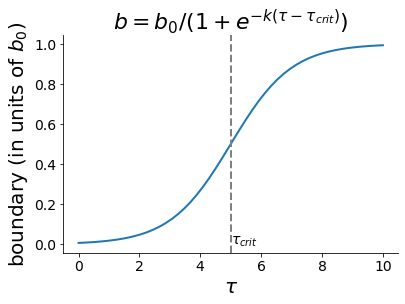

In [10]:
b_0 = 1
k = 1
tta_crit = 5
tau = np.linspace(0, 10)
b = lambda tau: b_0/(1+np.exp(-k*(tau-tta_crit)))

fig, ax = plt.subplots()
ax.plot(tau, b(tau))
ax.axvline(tta_crit, color='grey', ls='--')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('boundary (in units of $b_0$)')
# ax.legend(loc='lower right')
ax.set_title(r'$b = b_0/(1+e^{-k(\tau-\tau_{crit})})$')
ax.text(x=tta_crit, y=0, s=r'$\tau_{crit}$', fontsize=14);

In [11]:
class BoundCollapsingTta(ddm.models.Bound):
    name = 'Bounds collapsing with TTA'
    required_parameters = ['b_0', 'k', 'tta_crit']
    required_conditions = ['tta_condition'] 
    def get_bound(self, t, conditions, **kwargs):
        tau = conditions['tta_condition'] - t
        return self.b_0/(1+np.exp(-self.k*(tau-self.tta_crit)))

tta_crit = ddm.Fittable(minval=3, maxval=6)
    
model_TTA_bounds = ddm.Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time',
                             drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                            tta_crit=tta_crit),
                             noise=ddm.NoiseConstant(noise=1),
                             bound=BoundCollapsingTta(b_0=ddm.Fittable(minval=0.5, maxval=5), 
                                                      k=ddm.Fittable(minval=0.1, maxval=2),
                                                      tta_crit=tta_crit),
                             overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                   halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                             T_dur=T_dur)

# Model fitting

Reading experimental data

In [14]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

In [17]:
models = [model_tta_dependent_drift, 
          model_nondecision_time_fixed, 
          model_nondecision_time_variable,
          model_collapsing_bounds, 
          model_TTA_bounds]

fit_models = []
for model in models:
    print(model.name)
    fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model, lossfunction=LossWLS)
    save_fitting_results(exp_data, fit_model)
    fit_models.append(fit_model)

4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds
[1.5906231053743378, 3.6042059183154844, 3.931208985856968, 3.383144792057133, 0.460556694659645, 0.19918013829380687]
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.6867343099109404, minval=0.1, maxval=3), tta_crit=Fitted(4.748350326337432, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.552532557392917, minval=0.5, maxval=5), tau=Fitted(3.542029129183544, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.047815420577815126, minval=0, maxval=0.5), halfwidth=Fitted(0.12070182076817722, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.520271482839773
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.9815071950067726, minval=0.1, maxval=3), tta_crit=Fitted(5.07557895688588, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.9501373809407627, minval=0.5, maxval=5), tau=Fitted(3.347565162635128, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3786659862792633, minval=0, maxval=0.5), halfwidth=Fitted(0.19060074271122346, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3859293113781854
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.9859002497655567, minval=0.1, maxval=3), tta_crit=Fitted(5.868857882537275, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4437107478228621, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.5703530248196675, minval=0.1, maxval=3), tta_crit=Fitted(3.049021225868336, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4596204087902458, minval=0.5, maxval=5), tau=Fitted(4.740164617262593, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11811829564818332, minval=0, maxval=0.5), halfwidth=Fitted(0.09146278778007641, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.341734938707762
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.7802786491910556, minval=0.1, maxval=3), tta_crit=Fitted(5.138369834612835, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.774147749882765, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7147623107197355, minval=0.1, maxval=3), tta_crit=Fitted(4.320761486862521, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.185957252068603, minval=0.5, maxval=5), tau=Fitted(3.938580196492669, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.02374725406504477, minval=0, maxval=0.5), halfwidth=Fitted(0.14886128107605995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3549818108741015
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.33076079128042046, minval=0.1, maxval=3), tta_crit=Fitted(5.997138177976411, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.805828366712834, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.0638154661512846, minval=0.1, maxval=3), tta_crit=Fitted(3.088951666512802, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.8663730170094497, minval=0.5, maxval=5), tau=Fitted(3.9545682163621607, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34632629048399444, minval=0, maxval=0.5), halfwidth=Fitted(0.16137664059060042, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.424584354552628
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.662338890950004, minval=0.1, maxval=3), tta_crit=Fitted(5.390511794504283, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.7608011705547013, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.6115226356377326, minval=0.1, maxval=3), tta_crit=Fitted(5.036231470738194, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.257530417064432, minval=0.5, maxval=5), tau=Fitted(2.592045378536481, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15180881619450148, minval=0, maxval=0.5), halfwidth=Fitted(0.044671699893874275, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.231002932977981
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.0213783421785156, minval=0.1, maxval=3), tta_crit=Fitted(4.6491048652661044, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.998570813288421, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.8179099628338211, minval=0.1, maxval=3), tta_crit=Fitted(5.467399028032297, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5986604409852725, minval=0.5, maxval=5), tau=Fitted(0.6272341798216856, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.021557316383736147, minval=0, maxval=0.5), halfwidth=Fitted(0.2826913490231059, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1710163184809816
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.2734749670826684, minval=0.1, maxval=3), tta_crit=Fitted(3.981117924749462, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.810704448845144, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.9083584858878182, minval=0.1, maxval=3), tta_crit=Fitted(4.582667933079185, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9211693376959573, minval=0.5, maxval=5), tau=Fitted(3.053350156889943, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2616920639830343, minval=0, maxval=0.5), halfwidth=Fitted(0.027099856699138322, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6854042018948938
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.352352960750709, minval=0.1, maxval=3), tta_crit=Fitted(5.740952395603407, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.9020738594526736, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.9707913249349078, minval=0.1, maxval=3), tta_crit=Fitted(3.6624852641008103, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.441495802297636, minval=0.5, maxval=5), tau=Fitted(4.382282450770241, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33537825345478306, minval=0, maxval=0.5), halfwidth=Fitted(0.14120927488842094, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.197876346206614
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0134890596002015, minval=0.1, maxval=3), tta_crit=Fitted(5.370461052858891, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.8986431571592837, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5347656791357143, minval=0.1, maxval=3), tta_crit=Fitted(4.8371219561508445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.774147749882765, minval=0.5, maxval=5), tau=Fitted(2.8310421635026928, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24496075007650853, minval=0, maxval=0.5), halfwidth=Fitted(0.2030517698267806, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9099083962249848
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.9790655501450627, minval=0.1, maxval=3), tta_crit=Fitted(5.4261098647008685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5867212035132852, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7287820993079668, minval=0.1, maxval=3), tta_crit=Fitted(5.712695862368053, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.805828366712834, minval=0.5, maxval=5), tau=Fitted(0.6385272053359126, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3714080503393625, minval=0, maxval=0.5), halfwidth=Fitted(0.147442955064336, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=11.860155740367919
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2374560204490093, minval=0.1, maxval=3), tta_crit=Fitted(5.4952914591138535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5335066082303568, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.662338890950004, minval=0.1, maxval=3), tta_crit=Fitted(5.390511794504283, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8550928273839784, minval=0.5, maxval=5), tau=Fitted(1.793540225875631, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22580421075195503, minval=0, maxval=0.5), halfwidth=Fitted(0.21577594637835096, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7244296706828739
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.4296351371101275, minval=0.1, maxval=3), tta_crit=Fitted(4.044710686095572, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.2299255877976423, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8831765035441563, minval=0.1, maxval=3), tta_crit=Fitted(4.761629262946974, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8651368102890618, minval=0.5, maxval=5), tau=Fitted(0.9343689173762013, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10498576538231996, minval=0, maxval=0.5), halfwidth=Fitted(0.12988296682916597, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2429236170075424
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.1083970434003474, minval=0.1, maxval=3), tta_crit=Fitted(5.312324947632487, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.402165626352809, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.470715062094209, minval=0.1, maxval=3), tta_crit=Fitted(4.169455697606193, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.9048860884495933, minval=0.5, maxval=5), tau=Fitted(0.5410090851347888, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09002131230954347, minval=0, maxval=0.5), halfwidth=Fitted(0.0633875201472748, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.219162764235731
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.38561686043771837, minval=0.1, maxval=3), tta_crit=Fitted(5.769132047782064, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.3575401973184076, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2021817521303007, minval=0.1, maxval=3), tta_crit=Fitted(5.645186127107825, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.4434168628070516, minval=0.5, maxval=5), tau=Fitted(3.3754653090963336, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17261660047867816, minval=0, maxval=0.5), halfwidth=Fitted(0.052730845302107934, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7000933132631918
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.19789689839144864, minval=0.1, maxval=3), tta_crit=Fitted(4.279823765177312, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7096494977911978, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0134890596002015, minval=0.1, maxval=3), tta_crit=Fitted(5.1185773453612535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.517708432263924, minval=0.5, maxval=5), tau=Fitted(1.505917914381829, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20499343970018225, minval=0, maxval=0.5), halfwidth=Fitted(0.053954245885765445, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.4149717495509826
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.191927315600636, minval=0.1, maxval=3), tta_crit=Fitted(5.884090292981708, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.425508029348105, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.9790655501450627, minval=0.1, maxval=3), tta_crit=Fitted(5.75775209817888, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.881532900237139, minval=0.5, maxval=5), tau=Fitted(1.0925211738833178, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08290623307597791, minval=0, maxval=0.5), halfwidth=Fitted(0.06547077703149672, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.312023816870895
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2051379924777417, minval=0.1, maxval=3), tta_crit=Fitted(5.569890046999468, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0388688743911345, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.5203203143457764, minval=0.1, maxval=3), tta_crit=Fitted(4.889940090878788, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.99082055437708, minval=0.5, maxval=5), tau=Fitted(2.2121796373195353, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4609176583562449, minval=0, maxval=0.5), halfwidth=Fitted(0.0660595837844402, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1311043795734443
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3702422411936217, minval=0.1, maxval=3), tta_crit=Fitted(4.799280296235248, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3617428256322899, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1803283335118637, minval=0.1, maxval=3), tta_crit=Fitted(3.5876074691179642, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.9022135490448613, minval=0.5, maxval=5), tau=Fitted(3.3370001103113127, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31303320239921006, minval=0, maxval=0.5), halfwidth=Fitted(0.09401683256266616, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9911737155531404
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1262022477888296, minval=0.1, maxval=3), tta_crit=Fitted(5.966032905006351, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.174071640166957, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.1799693187552913, minval=0.1, maxval=3), tta_crit=Fitted(4.132289441760626, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.9203876511631615, minval=0.5, maxval=5), tau=Fitted(3.5273607033291197, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2898435834457912, minval=0, maxval=0.5), halfwidth=Fitted(0.14510687412294276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3539391328508799
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1925477903177313, minval=0.1, maxval=3), tta_crit=Fitted(3.844346251442403, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.501063881997441, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.71666136223943, minval=0.1, maxval=3), tta_crit=Fitted(4.126769900706685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.281381503591324, minval=0.5, maxval=5), tau=Fitted(0.5953784962539621, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07192340720120971, minval=0, maxval=0.5), halfwidth=Fitted(0.17907427932884623, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0887561419328944
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.1996824594012525, minval=0.1, maxval=3), tta_crit=Fitted(4.408695421109569, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8933291133119621, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5966698548063143, minval=0.1, maxval=3), tta_crit=Fitted(5.922961385468849, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0013470965357476, minval=0.5, maxval=5), tau=Fitted(2.8917337245603525, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21918382828147123, minval=0, maxval=0.5), halfwidth=Fitted(0.21917112524827853, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23293754268736266
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8661554857776482, minval=0.1, maxval=3), tta_crit=Fitted(4.049991003742131, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5052122646446184, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9894540844201664, minval=0.1, maxval=3), tta_crit=Fitted(5.237133198680683, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8277686083582378, minval=0.5, maxval=5), tau=Fitted(2.7330557287211805, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13209395504939864, minval=0, maxval=0.5), halfwidth=Fitted(0.11971310888181375, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13397203582988776
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.702648633291581, minval=0.1, maxval=3), tta_crit=Fitted(3.5305350852616346, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7830852257339076, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2208330393299183, minval=0.1, maxval=3), tta_crit=Fitted(4.549621349246127, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3430195275532932, minval=0.5, maxval=5), tau=Fitted(1.6549583952778006, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35669847384354847, minval=0, maxval=0.5), halfwidth=Fitted(0.060991168583222635, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6160163914835853
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4907541770935613, minval=0.1, maxval=3), tta_crit=Fitted(4.493018969516964, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9644939569711359, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3702422411936217, minval=0.1, maxval=3), tta_crit=Fitted(3.6777473914449788, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.7066077150356467, minval=0.5, maxval=5), tau=Fitted(0.8965034592344006, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2949488209620673, minval=0, maxval=0.5), halfwidth=Fitted(0.22985925543153418, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.9943858464188082
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0879426187056334, minval=0.1, maxval=3), tta_crit=Fitted(4.803102532436464, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.1110377307937376, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.956600750761233, minval=0.1, maxval=3), tta_crit=Fitted(3.605623462251411, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4755305948173159, minval=0.5, maxval=5), tau=Fitted(2.6739269136757207, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.03900063526783276, minval=0, maxval=0.5), halfwidth=Fitted(0.16963435564725893, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7146501410672927
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.152882571519659, minval=0.1, maxval=3), tta_crit=Fitted(5.3509792236846145, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.3735673562050725, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7371803255917483, minval=0.1, maxval=3), tta_crit=Fitted(5.703587267327595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5881648791895304, minval=0.5, maxval=5), tau=Fitted(4.137398051450044, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3243531396166876, minval=0, maxval=0.5), halfwidth=Fitted(0.1287234124946197, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19797274008533894
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.711028593307356, minval=0.1, maxval=3), tta_crit=Fitted(4.579696933822567, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6382858051619018, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3627518201412161, minval=0.1, maxval=3), tta_crit=Fitted(4.402711760684577, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8456690451976208, minval=0.5, maxval=5), tau=Fitted(1.025907299322616, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3766244376407543, minval=0, maxval=0.5), halfwidth=Fitted(0.10696625965522044, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3817121644426438
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.048952936109079, minval=0.1, maxval=3), tta_crit=Fitted(4.435592210124973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.208744828221239, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.7426944369078112, minval=0.1, maxval=3), tta_crit=Fitted(5.57684037392926, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.6382574650121111, minval=0.5, maxval=5), tau=Fitted(1.9903340441639632, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19005678182337035, minval=0, maxval=0.5), halfwidth=Fitted(0.25756592683513585, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6917366618308415
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.2027217165543549, minval=0.1, maxval=3), tta_crit=Fitted(4.496433931712273, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4004699019364217, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.7781836647754794, minval=0.1, maxval=3), tta_crit=Fitted(5.265114388390807, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8349879914901666, minval=0.5, maxval=5), tau=Fitted(2.701374913235516, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3304728560387434, minval=0, maxval=0.5), halfwidth=Fitted(0.0683453644121689, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9921828315092027
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3868607852193446, minval=0.1, maxval=3), tta_crit=Fitted(5.390577736448385, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.509403897168489, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.689766940653321, minval=0.1, maxval=3), tta_crit=Fitted(4.910044362618955, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.357962677678046, minval=0.5, maxval=5), tau=Fitted(2.4449113409453007, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1061331897574741, minval=0, maxval=0.5), halfwidth=Fitted(0.1756400336924529, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16900206430341463
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.7364134697105924, minval=0.1, maxval=3), tta_crit=Fitted(3.38699042863552, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.806943488364688, minval=0.5, maxval

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.027300151853395, minval=0.1, maxval=3), tta_crit=Fitted(4.762666418614014, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4517444159501511, minval=0.5, maxval=5), tau=Fitted(4.440455126011569, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4368094010234011, minval=0, maxval=0.5), halfwidth=Fitted(0.21848749424734576, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24323943521303887
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3787818140350905, minval=0.1, maxval=3), tta_crit=Fitted(4.083283396144829, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2423323813130573, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3016893685685407, minval=0.1, maxval=3), tta_crit=Fitted(5.622014040933473, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5130199728478733, minval=0.5, maxval=5), tau=Fitted(2.427692437518317, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20555767618782922, minval=0, maxval=0.5), halfwidth=Fitted(0.08713580452685006, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6339502231080607
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0514739003916929, minval=0.1, maxval=3), tta_crit=Fitted(5.2577692548192845, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.201448819361352, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6805006152724371, minval=0.1, maxval=3), tta_crit=Fitted(4.868349871218929, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.957795739289004, minval=0.5, maxval=5), tau=Fitted(2.1278220830167913, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13500385621117353, minval=0, maxval=0.5), halfwidth=Fitted(0.017085605602448567, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28798538541544944
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.7331505685707425, minval=0.1, maxval=3), tta_crit=Fitted(5.1639572149459, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8440190973353554, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.594568890236006, minval=0.1, maxval=3), tta_crit=Fitted(5.3888314822606445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.8751065955067876, minval=0.5, maxval=5), tau=Fitted(2.0964848147459847, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0856795046896491, minval=0, maxval=0.5), halfwidth=Fitted(0.21141534946041596, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7422818767641598
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0161245210822663, minval=0.1, maxval=3), tta_crit=Fitted(3.6803826313127326, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7787120780772561, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.20600172206734912, minval=0.1, maxval=3), tta_crit=Fitted(5.325579604245541, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0054025269683524, minval=0.5, maxval=5), tau=Fitted(1.8612139502451015, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2258106325729421, minval=0, maxval=0.5), halfwidth=Fitted(0.12967188866390336, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.216578793820673
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.9559158383444304, minval=0.1, maxval=3), tta_crit=Fitted(5.675003945721102, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6060758645705668, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7724342946702317, minval=0.1, maxval=3), tta_crit=Fitted(5.7770783720436985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.263021265884587, minval=0.5, maxval=5), tau=Fitted(2.7277202989168106, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35671191409616093, minval=0, maxval=0.5), halfwidth=Fitted(0.17085021163961953, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.30892250144957484
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2592203367490526, minval=0.1, maxval=3), tta_crit=Fitted(5.01370995277733, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3224893125496742, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5798509648695754, minval=0.1, maxval=3), tta_crit=Fitted(5.95902012616607, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5880306886781024, minval=0.5, maxval=5), tau=Fitted(1.2005308633055944, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21110074612488425, minval=0, maxval=0.5), halfwidth=Fitted(0.20892239436164128, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.35767688136934706
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.829067311124388, minval=0.1, maxval=3), tta_crit=Fitted(5.865290530415931, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1055858789846695, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7655646349460576, minval=0.1, maxval=3), tta_crit=Fitted(4.683005973668816, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5757303623111398, minval=0.5, maxval=5), tau=Fitted(2.0859525898392075, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18486766260665716, minval=0, maxval=0.5), halfwidth=Fitted(0.2693793894965562, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6007488481279672
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4959624755106864, minval=0.1, maxval=3), tta_crit=Fitted(5.953747401975326, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5399681581064693, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.33380625798268926, minval=0.1, maxval=3), tta_crit=Fitted(4.628290548314028, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8440190973353554, minval=0.5, maxval=5), tau=Fitted(2.165173396545154, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25033288486639116, minval=0, maxval=0.5), halfwidth=Fitted(0.09724474204028594, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.35976105107064316
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3254452177581588, minval=0.1, maxval=3), tta_crit=Fitted(5.2737642251945225, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.112937139109398, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.31704793954168564, minval=0.1, maxval=3), tta_crit=Fitted(4.643451578886333, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.087528478187568, minval=0.5, maxval=5), tau=Fitted(2.6357700697164828, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0856795046896491, minval=0, maxval=0.5), halfwidth=Fitted(0.21141534946041596, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5698790916100323
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5812592528210941, minval=0.1, maxval=3), tta_crit=Fitted(5.089196537709523, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8163017377346542, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.20600172206734912, minval=0.1, maxval=3), tta_crit=Fitted(4.544131388318467, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5892707301988134, minval=0.5, maxval=5), tau=Fitted(1.6883109958377562, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2041052254044144, minval=0, maxval=0.5), halfwidth=Fitted(0.143464540589448, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5812625007495342
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3262910413385514, minval=0.1, maxval=3), tta_crit=Fitted(5.0751324457399996, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6060758645705668, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1051623865165647, minval=0.1, maxval=3), tta_crit=Fitted(5.1588407753456345, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.263021265884587, minval=0.5, maxval=5), tau=Fitted(1.6846889460744277, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35671191409616093, minval=0, maxval=0.5), halfwidth=Fitted(0.041102234679771324, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.42147648689246514
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7781467728492171, minval=0.1, maxval=3), tta_crit=Fitted(4.752325468929233, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3224893125496742, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.11681720760697467, minval=0.1, maxval=3), tta_crit=Fitted(5.3194448749137315, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.408008083057601, minval=0.5, maxval=5), tau=Fitted(0.6465740607073904, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27416126162740256, minval=0, maxval=0.5), halfwidth=Fitted(0.29083313245940967, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6021363983227865
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1470663548813174, minval=0.1, maxval=3), tta_crit=Fitted(4.240418811007908, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.673696718005187, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.45559414917765917, minval=0.1, maxval=3), tta_crit=Fitted(5.8475441044304635, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.077722187061112, minval=0.5, maxval=5), tau=Fitted(3.723918183361842, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.05122906839446065, minval=0, maxval=0.5), halfwidth=Fitted(0.14045238558292086, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19394939847721038
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4959624755106864, minval=0.1, maxval=3), tta_crit=Fitted(4.762886516354138, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0538811639521333, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8739429687847761, minval=0.1, maxval=3), tta_crit=Fitted(5.634359810298409, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9747246095814677, minval=0.5, maxval=5), tau=Fitted(2.0189533509334776, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11621739409222728, minval=0, maxval=0.5), halfwidth=Fitted(0.2864626199833262, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3908295017065775
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5837134087046224, minval=0.1, maxval=3), tta_crit=Fitted(5.87670301131222, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7744883355318248, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3232554995220456, minval=0.1, maxval=3), tta_crit=Fitted(4.913103138530203, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.4255559404444607, minval=0.5, maxval=5), tau=Fitted(2.9477171063875818, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2155794978996185, minval=0, maxval=0.5), halfwidth=Fitted(0.20461372976067826, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2805667007148151
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5692161275226907, minval=0.1, maxval=3), tta_crit=Fitted(4.664352326058612, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5565963079028866, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5812592528210941, minval=0.1, maxval=3), tta_crit=Fitted(4.935062058312494, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.662342519255523, minval=0.5, maxval=5), tau=Fitted(1.3263370576592048, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13184575144471244, minval=0, maxval=0.5), halfwidth=Fitted(0.20704418321569987, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.3326583039044575
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.331207818338618, minval=0.1, maxval=3), tta_crit=Fitted(5.608539787661801, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6645147090038019, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6478511315280902, minval=0.1, maxval=3), tta_crit=Fitted(4.754022648622644, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.93760765638194, minval=0.5, maxval=5), tau=Fitted(2.4832093081608324, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.45618091533317634, minval=0, maxval=0.5), halfwidth=Fitted(0.22002000949935047, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2695262437563172
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0149088575092298, minval=0.1, maxval=3), tta_crit=Fitted(5.13801655047203, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8864367140729614, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6795257067495454, minval=0.1, maxval=3), tta_crit=Fitted(4.54357013186973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.197908613927984, minval=0.5, maxval=5), tau=Fitted(1.6446322639152724, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31086815218818636, minval=0, maxval=0.5), halfwidth=Fitted(0.21009196287614007, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1617097855967504
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.14325205071880243, minval=0.1, maxval=3), tta_crit=Fitted(5.3821334921266075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.7611410103941925, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.35764922671191757, minval=0.1, maxval=3), tta_crit=Fitted(5.005635287783626, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.978627649941462, minval=0.5, maxval=5), tau=Fitted(1.0874994400748081, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2817917105367691, minval=0, maxval=0.5), halfwidth=Fitted(0.1856020071488347, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.488987210199865
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7147623107197355, minval=0.1, maxval=3), tta_crit=Fitted(4.685551446553319, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7930248339259003, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8166032048219556, minval=0.1, maxval=3), tta_crit=Fitted(4.9773672860470315, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7828824613949261, minval=0.5, maxval=5), tau=Fitted(1.3590589422819706, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32702340271910607, minval=0, maxval=0.5), halfwidth=Fitted(0.11891191952407859, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06194552620367144
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8613877941953474, minval=0.1, maxval=3), tta_crit=Fitted(4.802461090061283, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.233597409338243, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5101880887846144, minval=0.1, maxval=3), tta_crit=Fitted(5.4591051756015485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.858266993989474, minval=0.5, maxval=5), tau=Fitted(0.918434984147761, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12030231975235806, minval=0, maxval=0.5), halfwidth=Fitted(0.16484758907784913, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.156963026481168
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.761475481954882, minval=0.1, maxval=3), tta_crit=Fitted(5.526398079047301, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9865852194839406, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3200266416363946, minval=0.1, maxval=3), tta_crit=Fitted(4.8966413186107305, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8530132407633857, minval=0.5, maxval=5), tau=Fitted(2.3005733346351995, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07171896347879936, minval=0, maxval=0.5), halfwidth=Fitted(0.205924953757894, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7312393197734165
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4789964824117703, minval=0.1, maxval=3), tta_crit=Fitted(4.820236042694847, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.291476634759501, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1077310183511035, minval=0.1, maxval=3), tta_crit=Fitted(4.83441017365909, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.667425422621585, minval=0.5, maxval=5), tau=Fitted(0.865672219771255, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33389675219028037, minval=0, maxval=0.5), halfwidth=Fitted(0.035248171256398036, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13447194249570038
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.56839840968557, minval=0.1, maxval=3), tta_crit=Fitted(5.151380255669778, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0143464352331006, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0149088575092298, minval=0.1, maxval=3), tta_crit=Fitted(5.081873795734077, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5316717037284864, minval=0.5, maxval=5), tau=Fitted(1.4309346605656876, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22615729108046126, minval=0, maxval=0.5), halfwidth=Fitted(0.20482423976889857, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.31755066273894467
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9413713509377795, minval=0.1, maxval=3), tta_crit=Fitted(4.755004401223732, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.56647544553802, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.14325205071880243, minval=0.1, maxval=3), tta_crit=Fitted(5.300766004997871, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.7611410103941925, minval=0.5, maxval=5), tau=Fitted(1.8410138891902053, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2133660475602055, minval=0, maxval=0.5), halfwidth=Fitted(0.1431936398754369, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9123260753446019
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5832224608539702, minval=0.1, maxval=3), tta_crit=Fitted(5.665158432620313, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5411818675328077, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.619696245938519, minval=0.1, maxval=3), tta_crit=Fitted(5.282277024571391, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2122245245055838, minval=0.5, maxval=5), tau=Fitted(1.808489633458352, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26757913849926285, minval=0, maxval=0.5), halfwidth=Fitted(0.25738908497761986, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0661489391166502
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9176837905167863, minval=0.1, maxval=3), tta_crit=Fitted(5.697849840875823, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4269764656087025, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7299838254209632, minval=0.1, maxval=3), tta_crit=Fitted(5.3863765659485585, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.4926456625453937, minval=0.5, maxval=5), tau=Fitted(0.9704086613984042, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2537844722578676, minval=0, maxval=0.5), halfwidth=Fitted(0.19188838615854448, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1555124167550854
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7222685308765543, minval=0.1, maxval=3), tta_crit=Fitted(4.412160992109132, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7279374661028353, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2917773378365134, minval=0.1, maxval=3), tta_crit=Fitted(5.0866807810263674, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8651368102890618, minval=0.5, maxval=5), tau=Fitted(1.5570084806278042, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3667355887872645, minval=0, maxval=0.5), halfwidth=Fitted(0.27911991372463707, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13738092369508328
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9648841911281189, minval=0.1, maxval=3), tta_crit=Fitted(4.693290199155806, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8755731272690381, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4112544960871485, minval=0.1, maxval=3), tta_crit=Fitted(5.5669454667106955, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.150541721872163, minval=0.5, maxval=5), tau=Fitted(1.2710241421234025, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3195422878824802, minval=0, maxval=0.5), halfwidth=Fitted(0.23563769192116957, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.111359084903988
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.297728940238154, minval=0.1, maxval=3), tta_crit=Fitted(4.816626312769034, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0552835422384992, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3707915311607992, minval=0.1, maxval=3), tta_crit=Fitted(5.005052606157333, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.793902382194521, minval=0.5, maxval=5), tau=Fitted(1.2320537571453059, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22023038966472525, minval=0, maxval=0.5), halfwidth=Fitted(0.26597007373420944, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16673646847627893
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3418637707672145, minval=0.1, maxval=3), tta_crit=Fitted(4.938645877789344, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2799938288268522, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.652603101359781, minval=0.1, maxval=3), tta_crit=Fitted(4.858831954250328, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0517857808641011, minval=0.5, maxval=5), tau=Fitted(3.297553430358618, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23872040996021665, minval=0, maxval=0.5), halfwidth=Fitted(0.24774227722021985, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17633945247210636
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6001909523548948, minval=0.1, maxval=3), tta_crit=Fitted(4.95039294324286, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4654675284355367, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5532769395797184, minval=0.1, maxval=3), tta_crit=Fitted(4.967816556776386, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9340861061899173, minval=0.5, maxval=5), tau=Fitted(0.7128855941860923, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2594733755010271, minval=0, maxval=0.5), halfwidth=Fitted(0.24406705271307877, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09111095321415241
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6499390777367383, minval=0.1, maxval=3), tta_crit=Fitted(4.818257227530763, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.692695867228456, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5853015803114433, minval=0.1, maxval=3), tta_crit=Fitted(4.820065375853892, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9773163522296482, minval=0.5, maxval=5), tau=Fitted(1.0614265493086679, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29379969426845653, minval=0, maxval=0.5), halfwidth=Fitted(0.13332073595230454, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13163982458776702
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3524368042356907, minval=0.1, maxval=3), tta_crit=Fitted(5.288213501601828, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5860651687553764, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.26067781563599746, minval=0.1, maxval=3), tta_crit=Fitted(5.246840642647683, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6495189268601691, minval=0.5, maxval=5), tau=Fitted(1.3552894915747467, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2651674255072898, minval=0, maxval=0.5), halfwidth=Fitted(0.16626715771932368, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2626946385026431
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4325266732112478, minval=0.1, maxval=3), tta_crit=Fitted(5.201680240959957, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7424307881894516, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6164651149290061, minval=0.1, maxval=3), tta_crit=Fitted(4.73088921363098, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.1215192852569507, minval=0.5, maxval=5), tau=Fitted(0.8270221428656059, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21109678550612662, minval=0, maxval=0.5), halfwidth=Fitted(0.24373894864256473, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.743552343676665
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6190572926158769, minval=0.1, maxval=3), tta_crit=Fitted(4.907806856437415, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8667066672505894, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.662262129001118, minval=0.1, maxval=3), tta_crit=Fitted(5.397764917287685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8933291133119621, minval=0.5, maxval=5), tau=Fitted(0.95380964369091, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29926646010084235, minval=0, maxval=0.5), halfwidth=Fitted(0.23100799945479414, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1049279521437489
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7340325665405925, minval=0.1, maxval=3), tta_crit=Fitted(5.183387539659339, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7234652917593674, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7708438598863486, minval=0.1, maxval=3), tta_crit=Fitted(5.031286713659933, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0816941362074368, minval=0.5, maxval=5), tau=Fitted(1.147953020425422, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27201520595971, minval=0, maxval=0.5), halfwidth=Fitted(0.2770187629363221, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10142413832400721
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3377350863601483, minval=0.1, maxval=3), tta_crit=Fitted(5.117404317579353, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.9184960309717427, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9467400302456034, minval=0.1, maxval=3), tta_crit=Fitted(5.290843357964623, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.6161691135526106, minval=0.5, maxval=5), tau=Fitted(0.630832034767054, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4382026643223426, minval=0, maxval=0.5), halfwidth=Fitted(0.2851947727557817, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=10.708497218970049
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.21252553055021, minval=0.1, maxval=3), tta_crit=Fitted(5.072044164890528, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.1440194203819845, minval=0.5, maxval

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7934637344306399, minval=0.1, maxval=3), tta_crit=Fitted(5.128804599442616, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8192812225917927, minval=0.5, maxval=5), tau=Fitted(0.7076614790868279, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3867980814930115, minval=0, maxval=0.5), halfwidth=Fitted(0.2557638037778446, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19580394773133478
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.130612604475611, minval=0.1, maxval=3), tta_crit=Fitted(4.953852835446493, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8332394145136335, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9671072282312987, minval=0.1, maxval=3), tta_crit=Fitted(5.327931517846258, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8475423658616283, minval=0.5, maxval=5), tau=Fitted(3.2795888374052096, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23195017200528484, minval=0, maxval=0.5), halfwidth=Fitted(0.19240546739386563, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11544646044959313
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1692154911888437, minval=0.1, maxval=3), tta_crit=Fitted(5.0388780444822, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7934563055624078, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0674311520820134, minval=0.1, maxval=3), tta_crit=Fitted(4.793863831331688, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3818410362087477, minval=0.5, maxval=5), tau=Fitted(1.8185023838530994, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2303640054946725, minval=0, maxval=0.5), halfwidth=Fitted(0.22550589694772888, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15591235533718287
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.102363737825371, minval=0.1, maxval=3), tta_crit=Fitted(5.2700232734785475, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7685961014562508, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0427212080371078, minval=0.1, maxval=3), tta_crit=Fitted(5.122767615101432, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5859609157343217, minval=0.5, maxval=5), tau=Fitted(0.884183667838784, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39922471649612457, minval=0, maxval=0.5), halfwidth=Fitted(0.23788869221346998, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03556689831549111
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9591486773677933, minval=0.1, maxval=3), tta_crit=Fitted(5.118122438944729, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.597130198115106, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.600155512597617, minval=0.1, maxval=3), tta_crit=Fitted(5.2842126164856875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7652019254072915, minval=0.5, maxval=5), tau=Fitted(1.3173338340964205, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3097148853224957, minval=0, maxval=0.5), halfwidth=Fitted(0.1991912234120515, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04242007145215549
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0916411730272593, minval=0.1, maxval=3), tta_crit=Fitted(5.478826007795887, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8681273818690278, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9356133356949253, minval=0.1, maxval=3), tta_crit=Fitted(5.038600234517811, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0560528812425507, minval=0.5, maxval=5), tau=Fitted(0.8016973769498859, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4692085399514584, minval=0, maxval=0.5), halfwidth=Fitted(0.2667215643900719, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9187059692656279
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3066098796282126, minval=0.1, maxval=3), tta_crit=Fitted(5.241773329080784, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.25003454573836, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.33084599062021924, minval=0.1, maxval=3), tta_crit=Fitted(5.033242479811851, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7402747526518925, minval=0.5, maxval=5), tau=Fitted(2.0645496192078063, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18524262720609708, minval=0, maxval=0.5), halfwidth=Fitted(0.04167331705059164, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17953009134390463
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8939037822813372, minval=0.1, maxval=3), tta_crit=Fitted(5.440911554402898, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1230336442864177, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6468243409679383, minval=0.1, maxval=3), tta_crit=Fitted(5.234108758284527, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9629476373781043, minval=0.5, maxval=5), tau=Fitted(1.286545772531337, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3869277044281285, minval=0, maxval=0.5), halfwidth=Fitted(0.24416452293292887, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2236651421920395
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0163643720521698, minval=0.1, maxval=3), tta_crit=Fitted(5.0388780444822, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8481936645139838, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.956600750761233, minval=0.1, maxval=3), tta_crit=Fitted(5.263592608372497, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6380195602152723, minval=0.5, maxval=5), tau=Fitted(0.8193907386031829, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4731027135916139, minval=0, maxval=0.5), halfwidth=Fitted(0.2756413775792871, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16084568724104875
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8054141232481886, minval=0.1, maxval=3), tta_crit=Fitted(4.982865413314348, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5532555518339257, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6308314120593669, minval=0.1, maxval=3), tta_crit=Fitted(5.122767615101432, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5859609157343217, minval=0.5, maxval=5), tau=Fitted(2.0577887317681522, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39922471649612457, minval=0, maxval=0.5), halfwidth=Fitted(0.2344944133345957, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0872098262116349
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.624823231545993, minval=0.1, maxval=3), tta_crit=Fitted(5.539032671775415, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7819789756847675, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7340325665405925, minval=0.1, maxval=3), tta_crit=Fitted(4.920052367860793, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.525546603307087, minval=0.5, maxval=5), tau=Fitted(1.3682510279477116, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3312354574512055, minval=0, maxval=0.5), halfwidth=Fitted(0.27163830722994536, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5929031829343148
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7293527862017366, minval=0.1, maxval=3), tta_crit=Fitted(5.478826007795887, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.49194063019862, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7240807107405557, minval=0.1, maxval=3), tta_crit=Fitted(5.086901758792462, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5401710805050877, minval=0.5, maxval=5), tau=Fitted(1.6826393010467338, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3789679768691107, minval=0, maxval=0.5), halfwidth=Fitted(0.22014673491845704, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6448537271511482
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0396239244204986, minval=0.1, maxval=3), tta_crit=Fitted(5.124317650974982, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6590246798595087, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9137584103546776, minval=0.1, maxval=3), tta_crit=Fitted(5.033242479811851, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.7347413669862566, minval=0.5, maxval=5), tau=Fitted(1.1515841668128344, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18524262720609708, minval=0, maxval=0.5), halfwidth=Fitted(0.2529818851287292, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.6196156972102034
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.006593433714778, minval=0.1, maxval=3), tta_crit=Fitted(5.139172469682767, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5344823200458442, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.130612604475611, minval=0.1, maxval=3), tta_crit=Fitted(4.953852835446493, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8332394145136335, minval=0.5, maxval=5), tau=Fitted(0.9682270896276277, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3977139301818322, minval=0, maxval=0.5), halfwidth=Fitted(0.28922462842167784, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20488409554184278
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8649651405799782, minval=0.1, maxval=3), tta_crit=Fitted(5.215024270468194, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8378549547159135, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5075063957814128, minval=0.1, maxval=3), tta_crit=Fitted(5.0388780444822, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9541425439681532, minval=0.5, maxval=5), tau=Fitted(1.977892667645179, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.45441138752510524, minval=0, maxval=0.5), halfwidth=Fitted(0.26683715350815435, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2767167385180564
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8623450219138664, minval=0.1, maxval=3), tta_crit=Fitted(5.238285648203596, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.720052769591569, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.093407144420215, minval=0.1, maxval=3), tta_crit=Fitted(5.200992262694154, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9866821140727573, minval=0.5, maxval=5), tau=Fitted(1.2530314835180478, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36682708755807764, minval=0, maxval=0.5), halfwidth=Fitted(0.2798494855464031, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25029531964685814
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0505815347037966, minval=0.1, maxval=3), tta_crit=Fitted(5.385267974634533, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.269279690125776, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6225820165642061, minval=0.1, maxval=3), tta_crit=Fitted(5.17617849886623, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6812900375882167, minval=0.5, maxval=5), tau=Fitted(0.6928165433939437, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2930508298580647, minval=0, maxval=0.5), halfwidth=Fitted(0.26386367426060453, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029433394650829232
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.79742723190931, minval=0.1, maxval=3), tta_crit=Fitted(5.1038540724270085, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5586693487155028, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9569704788922293, minval=0.1, maxval=3), tta_crit=Fitted(5.478826007795887, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6432457259751687, minval=0.5, maxval=5), tau=Fitted(1.0806847191706974, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2780414088856323, minval=0, maxval=0.5), halfwidth=Fitted(0.26136106638192963, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12757086695193426
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6525438512402392, minval=0.1, maxval=3), tta_crit=Fitted(5.071800728698799, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.6287603563921413, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7685884571457836, minval=0.1, maxval=3), tta_crit=Fitted(5.078883086335928, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6524793699404081, minval=0.5, maxval=5), tau=Fitted(1.5714809793603934, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3108131394979438, minval=0, maxval=0.5), halfwidth=Fitted(0.2361311522747653, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0685966539336973
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5270356784250214, minval=0.1, maxval=3), tta_crit=Fitted(5.130149673287706, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1675355072652225, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8819504424594038, minval=0.1, maxval=3), tta_crit=Fitted(5.354695554745942, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5344823200458442, minval=0.5, maxval=5), tau=Fitted(0.5558233140690216, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3994127799857674, minval=0, maxval=0.5), halfwidth=Fitted(0.21320832156544922, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03862279294780645
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8997189314369026, minval=0.1, maxval=3), tta_crit=Fitted(5.193243509578521, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5499149218770252, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0685262845847852, minval=0.1, maxval=3), tta_crit=Fitted(5.075602831476463, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8095883336301672, minval=0.5, maxval=5), tau=Fitted(1.02479158631075, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35873461210243657, minval=0, maxval=0.5), halfwidth=Fitted(0.15026391658156024, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7725296063709701
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6498111732918406, minval=0.1, maxval=3), tta_crit=Fitted(5.390289381432529, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5506511172914279, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6109931532941283, minval=0.1, maxval=3), tta_crit=Fitted(4.999969231194653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8674952052347571, minval=0.5, maxval=5), tau=Fitted(0.991030015976496, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2887975056663391, minval=0, maxval=0.5), halfwidth=Fitted(0.2053279975348439, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04861661505326321
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4952436165131149, minval=0.1, maxval=3), tta_crit=Fitted(5.165621857629157, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5830346864170721, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9265756331066576, minval=0.1, maxval=3), tta_crit=Fitted(5.156125921290989, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6207158315992314, minval=0.5, maxval=5), tau=Fitted(4.445450729575414, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2792423060107301, minval=0, maxval=0.5), halfwidth=Fitted(0.2931093130929937, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3116980158106538
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2489166658284558, minval=0.1, maxval=3), tta_crit=Fitted(4.72439233474874, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.4130669346429894, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6756203770368988, minval=0.1, maxval=3), tta_crit=Fitted(5.148440343807231, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5362745605409431, minval=0.5, maxval=5), tau=Fitted(1.7903504074332375, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.219866780986899, minval=0, maxval=0.5), halfwidth=Fitted(0.21848002444544648, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1123887346246578
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6040014246709243, minval=0.1, maxval=3), tta_crit=Fitted(5.055359020801814, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8150284676516049, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8237051198349112, minval=0.1, maxval=3), tta_crit=Fitted(4.988017680217023, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3359289830958823, minval=0.5, maxval=5), tau=Fitted(0.9397355765683602, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3246266006950624, minval=0, maxval=0.5), halfwidth=Fitted(0.22015618977657764, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6957828068987674
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8437030336070844, minval=0.1, maxval=3), tta_crit=Fitted(5.154446578001093, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.2821067770091865, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8996034181560932, minval=0.1, maxval=3), tta_crit=Fitted(5.107056215878583, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7916340764247336, minval=0.5, maxval=5), tau=Fitted(1.2402769023165723, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25589773947505134, minval=0, maxval=0.5), halfwidth=Fitted(0.20108666020763402, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04401092772530993
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7722889890362373, minval=0.1, maxval=3), tta_crit=Fitted(5.335240371349714, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6043154460607356, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1345237493493017, minval=0.1, maxval=3), tta_crit=Fitted(5.080633611104572, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7253861585826002, minval=0.5, maxval=5), tau=Fitted(4.699902249794305, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32266923916775714, minval=0, maxval=0.5), halfwidth=Fitted(0.2000145479729415, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1489382995688437
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6441472109261892, minval=0.1, maxval=3), tta_crit=Fitted(5.114762468619067, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5022640103566647, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8118168010141833, minval=0.1, maxval=3), tta_crit=Fitted(5.011152373720574, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.3918080217117423, minval=0.5, maxval=5), tau=Fitted(4.660957034467726, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40546942639167294, minval=0, maxval=0.5), halfwidth=Fitted(0.23236450398487318, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4397540807856222
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7065722919139202, minval=0.1, maxval=3), tta_crit=Fitted(5.287280060767738, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5463380035232377, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5673834352068566, minval=0.1, maxval=3), tta_crit=Fitted(5.021940912293408, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6746085142395488, minval=0.5, maxval=5), tau=Fitted(0.8123061540753234, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3303488318606037, minval=0, maxval=0.5), halfwidth=Fitted(0.2704345120732127, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.052291159255986534
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5242302191353021, minval=0.1, maxval=3), tta_crit=Fitted(4.897396270106818, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7557463379987588, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7561029577727436, minval=0.1, maxval=3), tta_crit=Fitted(5.1952091924408395, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.064618747370191, minval=0.5, maxval=5), tau=Fitted(1.5604211620667154, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2889825797234838, minval=0, maxval=0.5), halfwidth=Fitted(0.18426778300021918, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07197986562776881
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5838389300723152, minval=0.1, maxval=3), tta_crit=Fitted(5.127514842963031, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5291712512119169, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5626688475537445, minval=0.1, maxval=3), tta_crit=Fitted(5.174451757391651, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9810936358461249, minval=0.5, maxval=5), tau=Fitted(1.3238516557600062, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2945879973570541, minval=0, maxval=0.5), halfwidth=Fitted(0.27401937604369436, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06452785209605576
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9188878864433717, minval=0.1, maxval=3), tta_crit=Fitted(5.143780300904593, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.068132340441014, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8261494880068758, minval=0.1, maxval=3), tta_crit=Fitted(5.117099899517213, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9438938804161887, minval=0.5, maxval=5), tau=Fitted(0.7343772064944778, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23906181750417194, minval=0, maxval=0.5), halfwidth=Fitted(0.24110011934407088, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08153727250252756
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.783850889681144, minval=0.1, maxval=3), tta_crit=Fitted(4.95518663621585, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2422464023893627, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6708633627464663, minval=0.1, maxval=3), tta_crit=Fitted(5.254810244881448, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.885641854746839, minval=0.5, maxval=5), tau=Fitted(0.706775258436295, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26050589818002057, minval=0, maxval=0.5), halfwidth=Fitted(0.20482423976889857, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07723036158928791
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.850337044632728, minval=0.1, maxval=3), tta_crit=Fitted(5.133399380850996, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.963848133285051, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8648513088822444, minval=0.1, maxval=3), tta_crit=Fitted(5.068521226440513, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7517209636937185, minval=0.5, maxval=5), tau=Fitted(0.6990761734930886, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20955221918621453, minval=0, maxval=0.5), halfwidth=Fitted(0.269244591860479, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07620300816385416
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5697186463260737, minval=0.1, maxval=3), tta_crit=Fitted(5.149402564003625, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.062388733417896, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.2504025873272433, minval=0.1, maxval=3), tta_crit=Fitted(5.231702849031126, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8237454264126463, minval=0.5, maxval=5), tau=Fitted(0.5926564476350671, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24206903213982417, minval=0, maxval=0.5), halfwidth=Fitted(0.22927993250933087, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16114260238190153
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8480934774869278, minval=0.1, maxval=3), tta_crit=Fitted(5.077413186224962, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7549706730560817, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8523927946034213, minval=0.1, maxval=3), tta_crit=Fitted(4.885760859746369, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9062774066812986, minval=0.5, maxval=5), tau=Fitted(0.8918421399722805, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22630629251471487, minval=0, maxval=0.5), halfwidth=Fitted(0.27540012532941216, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.054516063337378955
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8556286927078128, minval=0.1, maxval=3), tta_crit=Fitted(5.023444216099023, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5019437898175543, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6956262855320675, minval=0.1, maxval=3), tta_crit=Fitted(5.059165570170156, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5665184562896874, minval=0.5, maxval=5), tau=Fitted(3.042599565011236, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27926127320734484, minval=0, maxval=0.5), halfwidth=Fitted(0.11277345877181616, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09591180654716785
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8851085073963201, minval=0.1, maxval=3), tta_crit=Fitted(5.3250415516658824, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5410213586047052, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.895397595523039, minval=0.1, maxval=3), tta_crit=Fitted(5.052847180822624, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7623961071258047, minval=0.5, maxval=5), tau=Fitted(0.6844025832503107, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2658377359063187, minval=0, maxval=0.5), halfwidth=Fitted(0.1957309465530559, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03291733212925087
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6682346343202643, minval=0.1, maxval=3), tta_crit=Fitted(4.850614966699706, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7478943582835789, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6636934860441969, minval=0.1, maxval=3), tta_crit=Fitted(5.241074369989052, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.686786670505303, minval=0.5, maxval=5), tau=Fitted(0.5253990688515295, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30451557218308845, minval=0, maxval=0.5), halfwidth=Fitted(0.14529554111339957, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03299731646766138
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7679593782721424, minval=0.1, maxval=3), tta_crit=Fitted(5.266183438414514, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7280106112484468, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.850337044632728, minval=0.1, maxval=3), tta_crit=Fitted(4.839916746797557, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5916386698330465, minval=0.5, maxval=5), tau=Fitted(0.596610819993459, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2201435978730579, minval=0, maxval=0.5), halfwidth=Fitted(0.1863971946857619, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20012999146764782
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.779957748200771, minval=0.1, maxval=3), tta_crit=Fitted(5.021987596704352, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9635192994802093, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5182157684755508, minval=0.1, maxval=3), tta_crit=Fitted(5.086184900235174, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0020116479482484, minval=0.5, maxval=5), tau=Fitted(0.6651417295743758, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19720693333457012, minval=0, maxval=0.5), halfwidth=Fitted(0.21186022899247176, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08410662511547864
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.565936782458984, minval=0.1, maxval=3), tta_crit=Fitted(5.307571742775666, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.2314447547259624, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8480934774869278, minval=0.1, maxval=3), tta_crit=Fitted(5.189180163924588, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6552457460298173, minval=0.5, maxval=5), tau=Fitted(1.8702133712656432, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36031597467011783, minval=0, maxval=0.5), halfwidth=Fitted(0.29859016488693235, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03044819322825476
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4837336386237343, minval=0.1, maxval=3), tta_crit=Fitted(5.234196740309888, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9010658232544793, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8254580433066613, minval=0.1, maxval=3), tta_crit=Fitted(5.059848040525342, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.680320846573355, minval=0.5, maxval=5), tau=Fitted(1.2984853787589485, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3818718567013433, minval=0, maxval=0.5), halfwidth=Fitted(0.24523876320957838, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03647639992588831
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.518475662651589, minval=0.1, maxval=3), tta_crit=Fitted(5.1679777175285055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7989193533625782, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8906172702849003, minval=0.1, maxval=3), tta_crit=Fitted(5.369221361998509, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6173942593270438, minval=0.5, maxval=5), tau=Fitted(0.8737252208245705, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4715603864637741, minval=0, maxval=0.5), halfwidth=Fitted(0.25211958921713157, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15000408620021144
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8894430959737527, minval=0.1, maxval=3), tta_crit=Fitted(4.910779797658378, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7863740550119578, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6626545168581071, minval=0.1, maxval=3), tta_crit=Fitted(5.156381664095133, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7478943582835789, minval=0.5, maxval=5), tau=Fitted(0.5692960343332434, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3294206391742728, minval=0, maxval=0.5), halfwidth=Fitted(0.274034271399401, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05793110786030834
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5909562880639064, minval=0.1, maxval=3), tta_crit=Fitted(5.14824931260595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.636091513241777, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9059427288943749, minval=0.1, maxval=3), tta_crit=Fitted(5.266183438414514, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7723252404109584, minval=0.5, maxval=5), tau=Fitted(0.9646225564069904, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3300669209703579, minval=0, maxval=0.5), halfwidth=Fitted(0.2647576273854711, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05958906132758782
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7023793984751533, minval=0.1, maxval=3), tta_crit=Fitted(5.155772753914191, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9765676803306056, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5665752314411513, minval=0.1, maxval=3), tta_crit=Fitted(5.052179856889375, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6105693405381354, minval=0.5, maxval=5), tau=Fitted(1.7662320860459575, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30359973204576984, minval=0, maxval=0.5), halfwidth=Fitted(0.21951496042021815, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15933580132997288
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6958895351788817, minval=0.1, maxval=3), tta_crit=Fitted(5.161234162735374, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.641376163170734, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6996909294410256, minval=0.1, maxval=3), tta_crit=Fitted(5.220882070908607, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6190727317648848, minval=0.5, maxval=5), tau=Fitted(0.7128855941860923, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3413676552424754, minval=0, maxval=0.5), halfwidth=Fitted(0.25497580919316276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023347548990068974
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9459402598312481, minval=0.1, maxval=3), tta_crit=Fitted(5.173161448297689, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5910241960870453, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1400735605979841, minval=0.1, maxval=3), tta_crit=Fitted(4.9590301469981934, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7144356047668778, minval=0.5, maxval=5), tau=Fitted(1.0419714221830467, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28975577098170335, minval=0, maxval=0.5), halfwidth=Fitted(0.22043629591458977, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0855217869550381
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8669743057071608, minval=0.1, maxval=3), tta_crit=Fitted(5.052381906495887, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6279404493771783, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8806779504080585, minval=0.1, maxval=3), tta_crit=Fitted(5.262561606928426, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7989193533625782, minval=0.5, maxval=5), tau=Fitted(1.2336865645332038, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4414933793481492, minval=0, maxval=0.5), halfwidth=Fitted(0.24435269891830502, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20840515377910465
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7332521860708627, minval=0.1, maxval=3), tta_crit=Fitted(5.20117039136462, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7324955771558459, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9013119405512532, minval=0.1, maxval=3), tta_crit=Fitted(5.093143179581006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8906516503026598, minval=0.5, maxval=5), tau=Fitted(1.776241386385542, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3890294012789333, minval=0, maxval=0.5), halfwidth=Fitted(0.2635989295653073, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08688663677914985
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9382125515944789, minval=0.1, maxval=3), tta_crit=Fitted(5.053843970409375, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6378792893289753, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9363232047527679, minval=0.1, maxval=3), tta_crit=Fitted(5.180167865122812, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5071064343221279, minval=0.5, maxval=5), tau=Fitted(0.5548347174051305, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32962928956993454, minval=0, maxval=0.5), halfwidth=Fitted(0.294293909720878, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0667231360815704
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8956133987810235, minval=0.1, maxval=3), tta_crit=Fitted(5.1329716724232775, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6784291753582288, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9592774037384408, minval=0.1, maxval=3), tta_crit=Fitted(4.817218768398316, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9120023136693791, minval=0.5, maxval=5), tau=Fitted(0.7926104773272296, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22975879189886161, minval=0, maxval=0.5), halfwidth=Fitted(0.18422358469431033, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09097985429265316
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4082868488082121, minval=0.1, maxval=3), tta_crit=Fitted(5.167180461646959, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0758214376258284, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7221798309133342, minval=0.1, maxval=3), tta_crit=Fitted(5.065325076330119, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5642235285076596, minval=0.5, maxval=5), tau=Fitted(1.7574745732421166, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30093121248288474, minval=0, maxval=0.5), halfwidth=Fitted(0.28444915174809837, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17618705970469972
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6939201122416396, minval=0.1, maxval=3), tta_crit=Fitted(5.081860575931544, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.508816729297838, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9465388482447515, minval=0.1, maxval=3), tta_crit=Fitted(5.036399134014447, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8276137530440066, minval=0.5, maxval=5), tau=Fitted(1.6372410448903925, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2986634359025348, minval=0, maxval=0.5), halfwidth=Fitted(0.1640538999752119, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04838923485627009
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.609908670252836, minval=0.1, maxval=3), tta_crit=Fitted(5.042713715324636, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6710105475402659, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.815412987438371, minval=0.1, maxval=3), tta_crit=Fitted(5.262546006651135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5166625218845708, minval=0.5, maxval=5), tau=Fitted(1.1964988373423688, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36421699657364903, minval=0, maxval=0.5), halfwidth=Fitted(0.2890091352837335, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.054593830689817505
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3231081644313742, minval=0.1, maxval=3), tta_crit=Fitted(5.29257093608894, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.9931282424768195, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1977235221960405, minval=0.1, maxval=3), tta_crit=Fitted(5.107749752092496, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6449154129401014, minval=0.5, maxval=5), tau=Fitted(1.0816575827291217, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3994986074693472, minval=0, maxval=0.5), halfwidth=Fitted(0.24904130897614024, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06722382195083246
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.027547127500843, minval=0.1, maxval=3), tta_crit=Fitted(5.308907529071803, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.024068489465031, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9483514538946364, minval=0.1, maxval=3), tta_crit=Fitted(5.029498838290876, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6147446619054695, minval=0.5, maxval=5), tau=Fitted(3.0259698721243353, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3220806175957286, minval=0, maxval=0.5), halfwidth=Fitted(0.2715552609837249, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15193712737897563
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8898351900849394, minval=0.1, maxval=3), tta_crit=Fitted(4.943426831369814, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7019779889182445, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8956133987810235, minval=0.1, maxval=3), tta_crit=Fitted(5.10118203372853, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7713595776308415, minval=0.5, maxval=5), tau=Fitted(1.119375013083107, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.452913320876925, minval=0, maxval=0.5), halfwidth=Fitted(0.27684911368459036, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20333456191778504
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7047871004012648, minval=0.1, maxval=3), tta_crit=Fitted(5.0479472489192645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6346878472902953, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0715326528915823, minval=0.1, maxval=3), tta_crit=Fitted(5.221392843845779, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7396661199407935, minval=0.5, maxval=5), tau=Fitted(0.5423095675150105, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39249938752666846, minval=0, maxval=0.5), halfwidth=Fitted(0.2666562668098935, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19561044409668288
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9904168132643121, minval=0.1, maxval=3), tta_crit=Fitted(5.291998841045767, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.965723216908995, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9206873685362865, minval=0.1, maxval=3), tta_crit=Fitted(5.154262053487655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7573448509470069, minval=0.5, maxval=5), tau=Fitted(0.8125723736059418, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38448581140380644, minval=0, maxval=0.5), halfwidth=Fitted(0.16585088449647017, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13814266156814597
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0385103753517853, minval=0.1, maxval=3), tta_crit=Fitted(5.336688803410161, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8788677879264661, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8751633974832856, minval=0.1, maxval=3), tta_crit=Fitted(5.082007774414104, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7734083932184921, minval=0.5, maxval=5), tau=Fitted(0.5275323252088358, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23467520852639603, minval=0, maxval=0.5), halfwidth=Fitted(0.2714733377368784, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05018950729287934
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9103776534573609, minval=0.1, maxval=3), tta_crit=Fitted(5.137637858902636, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5923114541347676, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8680479829541746, minval=0.1, maxval=3), tta_crit=Fitted(5.086429122220532, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7425642626896174, minval=0.5, maxval=5), tau=Fitted(0.6759098202040073, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29080111669129655, minval=0, maxval=0.5), halfwidth=Fitted(0.25004094446784286, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027895140016498367
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6363240994906975, minval=0.1, maxval=3), tta_crit=Fitted(5.2713745159816785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5719927679909467, minval=0.5

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.051883316217106, minval=0.1, maxval=3), tta_crit=Fitted(5.063695153872922, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6208116252762648, minval=0.5, maxval=5), tau=Fitted(0.7216734347325238, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38868611385429, minval=0, maxval=0.5), halfwidth=Fitted(0.27615533165255524, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04491840640290863
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9233746982466755, minval=0.1, maxval=3), tta_crit=Fitted(4.9403891658710615, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.3136978870431215, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9316519111955687, minval=0.1, maxval=3), tta_crit=Fitted(5.378110124536886, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6177025615527265, minval=0.5, maxval=5), tau=Fitted(1.6230926490920412, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39881726612840723, minval=0, maxval=0.5), halfwidth=Fitted(0.29771008852464176, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03266716852966641
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0326988567257442, minval=0.1, maxval=3), tta_crit=Fitted(5.208449245604925, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1891040004317934, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8161729343530539, minval=0.1, maxval=3), tta_crit=Fitted(5.315631306219818, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.325075301448337, minval=0.5, maxval=5), tau=Fitted(1.2214930586718167, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3929828055191745, minval=0, maxval=0.5), halfwidth=Fitted(0.1783647633721619, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.013662336040798
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1217081036968937, minval=0.1, maxval=3), tta_crit=Fitted(5.262806333600099, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.1570119582972516, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9521811908138195, minval=0.1, maxval=3), tta_crit=Fitted(5.107056215878583, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5072153250745144, minval=0.5, maxval=5), tau=Fitted(1.2402769023165723, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25589773947505134, minval=0, maxval=0.5), halfwidth=Fitted(0.272211572880658, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2702422656583998
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1561359602303425, minval=0.1, maxval=3), tta_crit=Fitted(5.345367614125823, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8224494990488969, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9771825084308974, minval=0.1, maxval=3), tta_crit=Fitted(5.193243509578521, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5071472095389904, minval=0.5, maxval=5), tau=Fitted(0.541295106267476, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3327302445701564, minval=0, maxval=0.5), halfwidth=Fitted(0.29294127709751805, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06162537045645702
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8381046935315891, minval=0.1, maxval=3), tta_crit=Fitted(5.071666950045001, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6008917401518965, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0354793292165374, minval=0.1, maxval=3), tta_crit=Fitted(5.3559137964357575, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5215593663260787, minval=0.5, maxval=5), tau=Fitted(0.5698378615375006, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4578500466326808, minval=0, maxval=0.5), halfwidth=Fitted(0.2895556202290844, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06677250343916594
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0111845887739557, minval=0.1, maxval=3), tta_crit=Fitted(5.128289995215113, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6021777397836328, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8183066436030653, minval=0.1, maxval=3), tta_crit=Fitted(5.236896455654698, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8101874592396101, minval=0.5, maxval=5), tau=Fitted(2.8873639248588994, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4326085052297164, minval=0, maxval=0.5), halfwidth=Fitted(0.2877282106143985, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05295620526870973
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0615436943916883, minval=0.1, maxval=3), tta_crit=Fitted(5.235681891190999, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5556062408909015, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0463107591113672, minval=0.1, maxval=3), tta_crit=Fitted(5.183794406221687, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.779777877940196, minval=0.5, maxval=5), tau=Fitted(0.6366058800260426, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44562042917602684, minval=0, maxval=0.5), halfwidth=Fitted(0.28082524992832847, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.33635902140116497
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8984948933848462, minval=0.1, maxval=3), tta_crit=Fitted(5.181434662515026, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5118463923355234, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9386006082081642, minval=0.1, maxval=3), tta_crit=Fitted(5.084580879122246, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6772573226546506, minval=0.5, maxval=5), tau=Fitted(0.7289432397188396, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3259016251526107, minval=0, maxval=0.5), halfwidth=Fitted(0.28945725043058185, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028367944777763825
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7621960594476044, minval=0.1, maxval=3), tta_crit=Fitted(5.306238035583291, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8275334980610918, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0115250437801793, minval=0.1, maxval=3), tta_crit=Fitted(5.331984079877879, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7165413652257122, minval=0.5, maxval=5), tau=Fitted(1.0273886191232615, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.45355329512268383, minval=0, maxval=0.5), halfwidth=Fitted(0.2831190452999726, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20116902005238552
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8094531025360742, minval=0.1, maxval=3), tta_crit=Fitted(5.257878561271764, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.8952295957295617, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1561359602303425, minval=0.1, maxval=3), tta_crit=Fitted(5.3325893277003455, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5213220272991119, minval=0.5, maxval=5), tau=Fitted(0.5003817833508419, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39113779331358267, minval=0, maxval=0.5), halfwidth=Fitted(0.2712061410594196, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05372867319060559
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9124954278984123, minval=0.1, maxval=3), tta_crit=Fitted(5.167086035216089, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7077119999051598, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0056815910812702, minval=0.1, maxval=3), tta_crit=Fitted(5.22081276471058, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5435889801863159, minval=0.5, maxval=5), tau=Fitted(0.9483506001545225, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37098537240771, minval=0, maxval=0.5), halfwidth=Fitted(0.26457001116655027, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027714348370995318
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7789517365812616, minval=0.1, maxval=3), tta_crit=Fitted(5.129390324680303, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6921320043228545, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8118168010141833, minval=0.1, maxval=3), tta_crit=Fitted(5.122855548496197, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.572527477746239, minval=0.5, maxval=5), tau=Fitted(4.361403747538768, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3508319675129541, minval=0, maxval=0.5), halfwidth=Fitted(0.25613132342919, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17820419793083253
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8575112802336698, minval=0.1, maxval=3), tta_crit=Fitted(5.106297329902166, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2663858579936769, minval=0.5, maxval

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8738809257341107, minval=0.1, maxval=3), tta_crit=Fitted(4.974219514970229, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7081566936092258, minval=0.5, maxval=5), tau=Fitted(1.5408032820900042, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3149529302357069, minval=0, maxval=0.5), halfwidth=Fitted(0.28083759721917523, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0535723094362784
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.088016921158983, minval=0.1, maxval=3), tta_crit=Fitted(5.360725496598382, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.972520688927936, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9214231681035411, minval=0.1, maxval=3), tta_crit=Fitted(5.312352321544623, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6867789816571959, minval=0.5, maxval=5), tau=Fitted(0.6878692778642028, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32888291393973035, minval=0, maxval=0.5), halfwidth=Fitted(0.2825649127397646, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.056456153631636745
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9821657367356292, minval=0.1, maxval=3), tta_crit=Fitted(5.1436472938382325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8063184440906672, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7228402741915203, minval=0.1, maxval=3), tta_crit=Fitted(5.266971153837078, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5424399801080249, minval=0.5, maxval=5), tau=Fitted(0.6470405058644895, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35799442597805353, minval=0, maxval=0.5), halfwidth=Fitted(0.12887612109647578, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05529803519868964
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9866595927952434, minval=0.1, maxval=3), tta_crit=Fitted(5.263257381590876, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.6508668333650403, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7383052009054492, minval=0.1, maxval=3), tta_crit=Fitted(5.1930181350057545, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5738663160245889, minval=0.5, maxval=5), tau=Fitted(0.5449904263663745, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3658797361597633, minval=0, maxval=0.5), halfwidth=Fitted(0.24799342740891617, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02117069127016731
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9485119728504439, minval=0.1, maxval=3), tta_crit=Fitted(5.308732591503903, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.3478834475003145, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7956389855283766, minval=0.1, maxval=3), tta_crit=Fitted(5.285884682721975, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.74262707926569, minval=0.5, maxval=5), tau=Fitted(0.8535343019916009, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2705627222146013, minval=0, maxval=0.5), halfwidth=Fitted(0.2851300322544585, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=9.959026150903568
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8800130124488373, minval=0.1, maxval=3), tta_crit=Fitted(5.505106684359947, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.529774442320189, minval=0.5, maxval=

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0854662296062247, minval=0.1, maxval=3), tta_crit=Fitted(5.067919770610184, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.8989423809755115, minval=0.5, maxval=5), tau=Fitted(2.593588834171686, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3076076668488674, minval=0, maxval=0.5), halfwidth=Fitted(0.28080360512223834, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2151233115384126
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9994305845097611, minval=0.1, maxval=3), tta_crit=Fitted(5.2192603693712645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.570661690744513, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0665992308858152, minval=0.1, maxval=3), tta_crit=Fitted(5.319336373288904, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.584922892482036, minval=0.5, maxval=5), tau=Fitted(3.6785845585635144, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4299809869168251, minval=0, maxval=0.5), halfwidth=Fitted(0.22778654043850483, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3076685239952718
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9530432111536599, minval=0.1, maxval=3), tta_crit=Fitted(5.211368793292094, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5532216208754623, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8166032048219556, minval=0.1, maxval=3), tta_crit=Fitted(5.073743555719075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6939659922465178, minval=0.5, maxval=5), tau=Fitted(0.6879935906102692, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2972882705908242, minval=0, maxval=0.5), halfwidth=Fitted(0.2362328553154313, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018992160297124278
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9625530100362304, minval=0.1, maxval=3), tta_crit=Fitted(5.368385283171391, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.6870278772395366, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.730376954832215, minval=0.1, maxval=3), tta_crit=Fitted(5.0459934178976, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8541810152486298, minval=0.5, maxval=5), tau=Fitted(2.2614345527060453, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29594148421298094, minval=0, maxval=0.5), halfwidth=Fitted(0.15579022069100515, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07222750646899777
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.774547396958985, minval=0.1, maxval=3), tta_crit=Fitted(5.07146839296586, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5643649095585004, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0161551025003088, minval=0.1, maxval=3), tta_crit=Fitted(4.931202163049474, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5862791926027686, minval=0.5, maxval=5), tau=Fitted(0.5083040104637884, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3985920468543472, minval=0, maxval=0.5), halfwidth=Fitted(0.14530733478969823, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0902797171956286
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8607494466892568, minval=0.1, maxval=3), tta_crit=Fitted(5.202582899964481, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3524487469449629, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0372350858779753, minval=0.1, maxval=3), tta_crit=Fitted(5.215558021912945, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6150617672275405, minval=0.5, maxval=5), tau=Fitted(1.3557875254922154, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42732898598839253, minval=0, maxval=0.5), halfwidth=Fitted(0.1869408796830858, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0726228220390214
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0821880986540133, minval=0.1, maxval=3), tta_crit=Fitted(5.291269797620868, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9828313326883198, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1122481784868428, minval=0.1, maxval=3), tta_crit=Fitted(5.296939920778082, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.855404490660407, minval=0.5, maxval=5), tau=Fitted(2.339331431098364, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32224623712283074, minval=0, maxval=0.5), halfwidth=Fitted(0.2980716730330759, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.442244564721453
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0781131250936786, minval=0.1, maxval=3), tta_crit=Fitted(5.054034075674024, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.682761826578139, minval=0.5, maxval

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.3029717787979458, minval=0.1, maxval=3), tta_crit=Fitted(5.280825748960172, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.8920723594127695, minval=0.5, maxval=5), tau=Fitted(0.6707129045450384, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4775322486570045, minval=0, maxval=0.5), halfwidth=Fitted(0.2285695375832823, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=10.568484181511835
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9429421310605719, minval=0.1, maxval=3), tta_crit=Fitted(5.220882070908607, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9538810985922459, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9608614715127998, minval=0.1, maxval=3), tta_crit=Fitted(5.080691378975347, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9650378521482255, minval=0.5, maxval=5), tau=Fitted(0.5530893389943543, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28601505793194576, minval=0, maxval=0.5), halfwidth=Fitted(0.23538802461017533, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.9689760557723908
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9983205414707628, minval=0.1, maxval=3), tta_crit=Fitted(5.100747779833526, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.837501884908722, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8369215151561019, minval=0.1, maxval=3), tta_crit=Fitted(5.059848040525342, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.680320846573355, minval=0.5, maxval=5), tau=Fitted(0.584044482121084, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3672754171383694, minval=0, maxval=0.5), halfwidth=Fitted(0.24523876320957838, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05125557687796945
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8987713947609366, minval=0.1, maxval=3), tta_crit=Fitted(5.263107474661609, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7989193533625782, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1165978360779387, minval=0.1, maxval=3), tta_crit=Fitted(5.284942432550709, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6173942593270438, minval=0.5, maxval=5), tau=Fitted(1.0469967265371483, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.49461262536667944, minval=0, maxval=0.5), halfwidth=Fitted(0.18038350976917047, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22624529762573944
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0186050936858673, minval=0.1, maxval=3), tta_crit=Fitted(5.1746787578777775, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5463430485105958, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0619744645949543, minval=0.1, maxval=3), tta_crit=Fitted(5.324123409289043, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.328050248243538, minval=0.5, maxval=5), tau=Fitted(0.7511455717475752, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41536225039548946, minval=0, maxval=0.5), halfwidth=Fitted(0.2710319419255439, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=11.164550477938732
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0923334839041692, minval=0.1, maxval=3), tta_crit=Fitted(5.209090216773393, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6150977828494533, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7141971992945699, minval=0.1, maxval=3), tta_crit=Fitted(5.153898397582331, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9765676803306056, minval=0.5, maxval=5), tau=Fitted(1.054167927262116, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3650816112404014, minval=0, maxval=0.5), halfwidth=Fitted(0.26372038370710427, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23381366452614694
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2575565334860253, minval=0.1, maxval=3), tta_crit=Fitted(5.272482517061335, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.0191418013485385, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6939201122416396, minval=0.1, maxval=3), tta_crit=Fitted(5.112547281153839, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5754356797321742, minval=0.5, maxval=5), tau=Fitted(0.6896692900523664, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3539463695444829, minval=0, maxval=0.5), halfwidth=Fitted(0.20387523103260818, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03782888386911302
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0659622515203142, minval=0.1, maxval=3), tta_crit=Fitted(5.204726415137971, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4919443407090607, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9521960913631486, minval=0.1, maxval=3), tta_crit=Fitted(5.184495135467272, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.872206189699034, minval=0.5, maxval=5), tau=Fitted(3.663707021248805, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44454603744127746, minval=0, maxval=0.5), halfwidth=Fitted(0.1528498416698329, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6791571211680592
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.08100048517414, minval=0.1, maxval=3), tta_crit=Fitted(5.048809555730307, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.1955320770064595, minval=0.5, maxval

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0335844606621256, minval=0.1, maxval=3), tta_crit=Fitted(5.338831582462441, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7505299486275787, minval=0.5, maxval=5), tau=Fitted(0.8500206372564834, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4642304858782598, minval=0, maxval=0.5), halfwidth=Fitted(0.2962560320731031, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.053476057743942
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9452180287880186, minval=0.1, maxval=3), tta_crit=Fitted(5.078258807072269, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.212810729048915, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9479392928874725, minval=0.1, maxval=3), tta_crit=Fitted(5.148572522626512, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6633916503995465, minval=0.5, maxval=5), tau=Fitted(0.9715276237988091, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32973339278348557, minval=0, maxval=0.5), halfwidth=Fitted(0.24545612353281648, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025493870068748432
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9837711797158358, minval=0.1, maxval=3), tta_crit=Fitted(5.259877363456448, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.956381128697663, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8618008244731572, minval=0.1, maxval=3), tta_crit=Fitted(4.943426831369814, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6268055775436574, minval=0.5, maxval=5), tau=Fitted(0.9739035358174759, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4552110289757765, minval=0, maxval=0.5), halfwidth=Fitted(0.13665798026190673, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1734873921800052
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8292079726225181, minval=0.1, maxval=3), tta_crit=Fitted(5.1283687251079195, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.603839851443758, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0149158031051928, minval=0.1, maxval=3), tta_crit=Fitted(5.11706155895895, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5197047639611565, minval=0.5, maxval=5), tau=Fitted(0.6649465887240744, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38811222483626373, minval=0, maxval=0.5), halfwidth=Fitted(0.2659736667457649, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023036408908571275
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7099630392565864, minval=0.1, maxval=3), tta_crit=Fitted(5.107326722839209, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5920501377901592, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9812354230390801, minval=0.1, maxval=3), tta_crit=Fitted(5.179271542726188, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7396661199407935, minval=0.5, maxval=5), tau=Fitted(1.5685233798736051, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4420411995071481, minval=0, maxval=0.5), halfwidth=Fitted(0.20310527597409375, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13590510900480338
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8651189997736182, minval=0.1, maxval=3), tta_crit=Fitted(5.191647504809711, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6119370565028555, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8497303518255269, minval=0.1, maxval=3), tta_crit=Fitted(5.192152301037712, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.500516392335312, minval=0.5, maxval=5), tau=Fitted(0.511280753120765, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40197061062531686, minval=0, maxval=0.5), halfwidth=Fitted(0.275895826386489, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01929822654712507
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9102946526980944, minval=0.1, maxval=3), tta_crit=Fitted(5.176027833065413, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.918459920872951, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8251723112411992, minval=0.1, maxval=3), tta_crit=Fitted(5.183117922134063, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6031826869484962, minval=0.5, maxval=5), tau=Fitted(1.4361937269220835, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.364093720444222, minval=0, maxval=0.5), halfwidth=Fitted(0.2845129138014074, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030699311347233946
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.03789196504695, minval=0.1, maxval=3), tta_crit=Fitted(5.184867570574799, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4154365596970444, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9169555175061365, minval=0.1, maxval=3), tta_crit=Fitted(5.167339785395607, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6248839979997807, minval=0.5, maxval=5), tau=Fitted(0.591032511214606, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34144468977785863, minval=0, maxval=0.5), halfwidth=Fitted(0.2494312319052135, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021431820776231653
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.873047789519136, minval=0.1, maxval=3), tta_crit=Fitted(5.191932534768078, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5208582834623705, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8679647560719936, minval=0.1, maxval=3), tta_crit=Fitted(5.041215594797917, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9040985833828679, minval=0.5, maxval=5), tau=Fitted(0.8102242763536365, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3238431775019484, minval=0, maxval=0.5), halfwidth=Fitted(0.2528342273690028, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1334345212435994
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9033453154626815, minval=0.1, maxval=3), tta_crit=Fitted(5.198123715082591, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5719678637115861, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9428790841707574, minval=0.1, maxval=3), tta_crit=Fitted(5.17617849886623, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.02737935733056, minval=0.5, maxval=5), tau=Fitted(3.0930000211327213, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2930508298580647, minval=0, maxval=0.5), halfwidth=Fitted(0.1916103433815908, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.513920550294523
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7872415394813486, minval=0.1, maxval=3), tta_crit=Fitted(5.378110124536886, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.4069134415118194, minval=0.5, maxval=

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.984666141659929, minval=0.1, maxval=3), tta_crit=Fitted(5.237911180335077, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.826835073791291, minval=0.5, maxval=5), tau=Fitted(0.6120874877494966, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4565048743773398, minval=0, maxval=0.5), halfwidth=Fitted(0.016134688039690925, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=15.466384562776508
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9878271343236816, minval=0.1, maxval=3), tta_crit=Fitted(5.315631306219818, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5867441457054512, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6328368374350678, minval=0.1, maxval=3), tta_crit=Fitted(5.1951997676769235, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6840884503041749, minval=0.5, maxval=5), tau=Fitted(0.5259975801787764, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4067986394110003, minval=0, maxval=0.5), halfwidth=Fitted(0.16436025023631817, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1511588654989254
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8996034181560932, minval=0.1, maxval=3), tta_crit=Fitted(5.093673916362805, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5689529314505442, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8931589409416502, minval=0.1, maxval=3), tta_crit=Fitted(5.089425558409697, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7906287238445355, minval=0.5, maxval=5), tau=Fitted(1.0404242948127866, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25834987010832833, minval=0, maxval=0.5), halfwidth=Fitted(0.23794597311389923, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.034740294082172316
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8997189314369026, minval=0.1, maxval=3), tta_crit=Fitted(5.21833642296213, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.516042343231566, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7984324725066438, minval=0.1, maxval=3), tta_crit=Fitted(5.003504655682538, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6929402446137849, minval=0.5, maxval=5), tau=Fitted(2.0319086829825386, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2994696858586914, minval=0, maxval=0.5), halfwidth=Fitted(0.27405613124973277, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10364228277570746
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9481566149904745, minval=0.1, maxval=3), tta_crit=Fitted(5.186241190053708, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5721490341145703, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8130254021575689, minval=0.1, maxval=3), tta_crit=Fitted(5.089801133227989, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6647599332659149, minval=0.5, maxval=5), tau=Fitted(0.6646464308211861, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39918375409389356, minval=0, maxval=0.5), halfwidth=Fitted(0.254277654920362, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06634450715948212
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7797619358710964, minval=0.1, maxval=3), tta_crit=Fitted(5.218923466666326, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.867331195367212, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0000212402966766, minval=0.1, maxval=3), tta_crit=Fitted(5.1663886412369875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.564654877588916, minval=0.5, maxval=5), tau=Fitted(1.6272536867078622, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4891548622073471, minval=0, maxval=0.5), halfwidth=Fitted(0.2737163857527913, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.0188809303485025
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9097997179239429, minval=0.1, maxval=3), tta_crit=Fitted(5.183794406221687, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7214511838182958, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8012032889675078, minval=0.1, maxval=3), tta_crit=Fitted(5.125397197165918, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6458316121610639, minval=0.5, maxval=5), tau=Fitted(0.5897663471685863, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39881726612840723, minval=0, maxval=0.5), halfwidth=Fitted(0.0904616374349723, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10798679423848218
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8622317374938168, minval=0.1, maxval=3), tta_crit=Fitted(5.047254226052438, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6772573226546506, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6349517205589849, minval=0.1, maxval=3), tta_crit=Fitted(5.080388855827005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.68648670891747, minval=0.5, maxval=5), tau=Fitted(0.6120202673183903, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3139681343251936, minval=0, maxval=0.5), halfwidth=Fitted(0.26749444802925026, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027466068585972045
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7014564289472583, minval=0.1, maxval=3), tta_crit=Fitted(5.250295841299709, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8428970902303989, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.763312764664886, minval=0.1, maxval=3), tta_crit=Fitted(5.194801499883687, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5381712660155125, minval=0.5, maxval=5), tau=Fitted(1.2402769023165723, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37574612369562105, minval=0, maxval=0.5), halfwidth=Fitted(0.2792390020030566, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04697636992766112
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9146821557655685, minval=0.1, maxval=3), tta_crit=Fitted(5.160884580084104, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4756708668125058, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7899956754341354, minval=0.1, maxval=3), tta_crit=Fitted(5.042059347644464, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6122868967039587, minval=0.5, maxval=5), tau=Fitted(3.0095234675201974, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33877055020688585, minval=0, maxval=0.5), halfwidth=Fitted(0.27309676851869813, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13939444407166451
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8698387165529199, minval=0.1, maxval=3), tta_crit=Fitted(5.232418554329903, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4045367526837, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7127372022538041, minval=0.1, maxval=3), tta_crit=Fitted(5.1241492919447005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6994751648987831, minval=0.5, maxval=5), tau=Fitted(0.7824596384292153, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32570649003099783, minval=0, maxval=0.5), halfwidth=Fitted(0.23945741476321875, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021066327278083607
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7934687924763054, minval=0.1, maxval=3), tta_crit=Fitted(5.036893233279938, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5950590684599333, minval=0.5

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.748819525123484, minval=0.1, maxval=3), tta_crit=Fitted(5.169136432077833, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6614205742787065, minval=0.5, maxval=5), tau=Fitted(0.7339409590356314, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35667151344533166, minval=0, maxval=0.5), halfwidth=Fitted(0.2906170616054924, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02513810083966901
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8626946919051247, minval=0.1, maxval=3), tta_crit=Fitted(5.2291043633029055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.2531194945133626, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.780413469766053, minval=0.1, maxval=3), tta_crit=Fitted(5.126724443718983, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5718459637669184, minval=0.5, maxval=5), tau=Fitted(1.2085671491421144, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35708823030986436, minval=0, maxval=0.5), halfwidth=Fitted(0.29981806819981, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04593492591040352
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8133487883226985, minval=0.1, maxval=3), tta_crit=Fitted(5.116963711537503, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6265957100337696, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7621960594476044, minval=0.1, maxval=3), tta_crit=Fitted(5.147295860946844, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6616604424164523, minval=0.5, maxval=5), tau=Fitted(0.8863627049111626, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26257939663279417, minval=0, maxval=0.5), halfwidth=Fitted(0.29190089106327355, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07029677379665616
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7977315095954878, minval=0.1, maxval=3), tta_crit=Fitted(5.213597325122759, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5869672340300274, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7653347762838802, minval=0.1, maxval=3), tta_crit=Fitted(5.131207439389621, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7542382618318628, minval=0.5, maxval=5), tau=Fitted(1.3377379712975042, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35157224416302785, minval=0, maxval=0.5), halfwidth=Fitted(0.26309430785500876, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02650919887443132
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9524462465601266, minval=0.1, maxval=3), tta_crit=Fitted(5.219305144312087, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8540155764131379, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8759356736792537, minval=0.1, maxval=3), tta_crit=Fitted(5.142113131034974, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5697180452213755, minval=0.5, maxval=5), tau=Fitted(0.6892058635849638, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3791162675161079, minval=0, maxval=0.5), halfwidth=Fitted(0.123367756448348, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.050154015680624366
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8362818012839662, minval=0.1, maxval=3), tta_crit=Fitted(5.14386884427752, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6283476310874461, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6842604020105062, minval=0.1, maxval=3), tta_crit=Fitted(5.133034299885078, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.6557439698172063, minval=0.5, maxval=5), tau=Fitted(3.9047868358532907, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37306998236851746, minval=0, maxval=0.5), halfwidth=Fitted(0.2233112302765965, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6058765536131007
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0050727965512263, minval=0.1, maxval=3), tta_crit=Fitted(5.129390324680303, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5031831159781275, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7507969966112462, minval=0.1, maxval=3), tta_crit=Fitted(5.216722068001373, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7574113652798156, minval=0.5, maxval=5), tau=Fitted(0.9626496635233075, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34113664605239047, minval=0, maxval=0.5), halfwidth=Fitted(0.25943273320170723, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03918637437603504
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8791171169870251, minval=0.1, maxval=3), tta_crit=Fitted(5.100134517932831, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5596835424042337, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7179329837563079, minval=0.1, maxval=3), tta_crit=Fitted(5.088217745701279, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6355333618385366, minval=0.5, maxval=5), tau=Fitted(0.5094639891984665, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3377490790691537, minval=0, maxval=0.5), halfwidth=Fitted(0.18606660133027408, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025667573006297704
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8166032048219556, minval=0.1, maxval=3), tta_crit=Fitted(5.073743555719075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5661979220082332, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9214231681035411, minval=0.1, maxval=3), tta_crit=Fitted(5.155201868475647, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.514060834604888, minval=0.5, maxval=5), tau=Fitted(1.1212111297794989, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3728924809136276, minval=0, maxval=0.5), halfwidth=Fitted(0.2576347373009818, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04245550061353668
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9653306152755405, minval=0.1, maxval=3), tta_crit=Fitted(5.159901244651622, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7119961950717755, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8585773854484074, minval=0.1, maxval=3), tta_crit=Fitted(5.1261465722059905, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5736506625217515, minval=0.5, maxval=5), tau=Fitted(0.5578944898730658, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3592134757024896, minval=0, maxval=0.5), halfwidth=Fitted(0.2739528273315672, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01684669982909841
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8327584047442578, minval=0.1, maxval=3), tta_crit=Fitted(5.303387128126495, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6194545744423632, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8126561821159579, minval=0.1, maxval=3), tta_crit=Fitted(5.128019784434391, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5675478750843008, minval=0.5, maxval=5), tau=Fitted(0.5398434269224062, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.360067942434473, minval=0, maxval=0.5), halfwidth=Fitted(0.10562566501937086, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.047070985683236546
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8005940618343811, minval=0.1, maxval=3), tta_crit=Fitted(5.227027229858387, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5712197078506835, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9111562083969623, minval=0.1, maxval=3), tta_crit=Fitted(5.14157551921827, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6328007843850392, minval=0.5, maxval=5), tau=Fitted(0.8466191148529714, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35821583989941547, minval=0, maxval=0.5), halfwidth=Fitted(0.23458817007923677, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022290432890080876
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7754420878636946, minval=0.1, maxval=3), tta_crit=Fitted(5.1488934914696705, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5795362976124667, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9412397614511345, minval=0.1, maxval=3), tta_crit=Fitted(5.19918387200207, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5130292861592838, minval=0.5, maxval=5), tau=Fitted(0.5672541265516231, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3992838963020831, minval=0, maxval=0.5), halfwidth=Fitted(0.26773742999661304, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017411182590290564
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9137544039221965, minval=0.1, maxval=3), tta_crit=Fitted(5.169787782372879, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5312882301338471, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9368335982347443, minval=0.1, maxval=3), tta_crit=Fitted(5.165399822589233, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.529923317625129, minval=0.5, maxval=5), tau=Fitted(0.5536622276059902, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3791767986881934, minval=0, maxval=0.5), halfwidth=Fitted(0.20772592984546265, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024974438040913437
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8628515876748916, minval=0.1, maxval=3), tta_crit=Fitted(5.077413186224962, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5269380347902661, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8383718000423601, minval=0.1, maxval=3), tta_crit=Fitted(5.221059974377469, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6750125726834333, minval=0.5, maxval=5), tau=Fitted(0.7677173933470294, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36192355980454893, minval=0, maxval=0.5), halfwidth=Fitted(0.28279701153856907, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03430660156222474
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9386527811884114, minval=0.1, maxval=3), tta_crit=Fitted(5.1842400461131515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.680320846573355, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8954686755144003, minval=0.1, maxval=3), tta_crit=Fitted(5.154654802680515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.531100947321252, minval=0.5, maxval=5), tau=Fitted(0.5426594637257809, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39248428537815183, minval=0, maxval=0.5), halfwidth=Fitted(0.2842770865239248, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016499641386526126
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9533319866080848, minval=0.1, maxval=3), tta_crit=Fitted(5.081223234436057, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.8221671927398257, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.800624584295435, minval=0.1, maxval=3), tta_crit=Fitted(5.303387128126495, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6163201818867163, minval=0.5, maxval=5), tau=Fitted(0.5660361195980874, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33607227546272284, minval=0, maxval=0.5), halfwidth=Fitted(0.26420027298986803, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02688459140895242
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8950255042279176, minval=0.1, maxval=3), tta_crit=Fitted(5.212654264737222, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5335561565911746, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7783534762618277, minval=0.1, maxval=3), tta_crit=Fitted(5.238960345035055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6974795500868187, minval=0.5, maxval=5), tau=Fitted(0.8279169621172877, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32407697317343204, minval=0, maxval=0.5), halfwidth=Fitted(0.2841574875058073, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024006164328803186
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8259849053938407, minval=0.1, maxval=3), tta_crit=Fitted(5.0865550946649964, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5944600420572379, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.957180913020938, minval=0.1, maxval=3), tta_crit=Fitted(5.162011577153022, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.507985746484628, minval=0.5, maxval=5), tau=Fitted(0.719373694433858, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3964843417343351, minval=0, maxval=0.5), halfwidth=Fitted(0.2996955383667289, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02031434256470649
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8589560066439315, minval=0.1, maxval=3), tta_crit=Fitted(5.162286425377038, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7140772935763939, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8993075103576622, minval=0.1, maxval=3), tta_crit=Fitted(5.189775125557617, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6507246039775905, minval=0.5, maxval=5), tau=Fitted(4.779725835971181, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37185125756902443, minval=0, maxval=0.5), halfwidth=Fitted(0.28691932398506836, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10598673574907713
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7784311899904951, minval=0.1, maxval=3), tta_crit=Fitted(5.145503014531345, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5291900683409954, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9315951896016081, minval=0.1, maxval=3), tta_crit=Fitted(5.228266058525065, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8230379804698449, minval=0.5, maxval=5), tau=Fitted(2.524320060976632, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39922471649612457, minval=0, maxval=0.5), halfwidth=Fitted(0.06807632378417384, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6851878651913783
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8180487393152152, minval=0.1, maxval=3), tta_crit=Fitted(5.123782038015716, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5914279988748952, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8323669011000232, minval=0.1, maxval=3), tta_crit=Fitted(5.20117039136462, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5807610869311031, minval=0.5, maxval=5), tau=Fitted(0.5053849418001164, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.355090320030729, minval=0, maxval=0.5), halfwidth=Fitted(0.2894776028182957, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01756947650008581
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9367715420680209, minval=0.1, maxval=3), tta_crit=Fitted(5.071862069221559, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5950266085721796, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8880999719918881, minval=0.1, maxval=3), tta_crit=Fitted(5.202733003562175, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5625745509900733, minval=0.5, maxval=5), tau=Fitted(0.5378059665069266, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3805477478595304, minval=0, maxval=0.5), halfwidth=Fitted(0.2951032916456434, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01767740693918985
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.822774089634644, minval=0.1, maxval=3), tta_crit=Fitted(5.189464059558625, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6390591596854276, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8956133987810235, minval=0.1, maxval=3), tta_crit=Fitted(5.178334540238043, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6784291753582288, minval=0.5, maxval=5), tau=Fitted(0.5317400201530127, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38036612342105774, minval=0, maxval=0.5), halfwidth=Fitted(0.2901797545789604, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0729367325263153
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8594458005130899, minval=0.1, maxval=3), tta_crit=Fitted(5.173617711006404, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5209483319424244, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7434284737475061, minval=0.1, maxval=3), tta_crit=Fitted(5.06202803724786, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6082622829183704, minval=0.5, maxval=5), tau=Fitted(0.6707664924165506, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4029781606218735, minval=0, maxval=0.5), halfwidth=Fitted(0.2765708677426326, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.045652288242989544
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9630014033783647, minval=0.1, maxval=3), tta_crit=Fitted(5.365750623937284, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.393371532475681, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.712081272603182, minval=0.1, maxval=3), tta_crit=Fitted(5.148340594912771, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7197404435204549, minval=0.5, maxval=5), tau=Fitted(1.0806666628318717, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.348830245654195, minval=0, maxval=0.5), halfwidth=Fitted(0.28362634336078707, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026462150914221164
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8975700369651539, minval=0.1, maxval=3), tta_crit=Fitted(5.125275021166999, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.041976953215587, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9369360704314015, minval=0.1, maxval=3), tta_crit=Fitted(5.135835901679956, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6357476974582856, minval=0.5, maxval=5), tau=Fitted(0.6657936166964986, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3436753700975928, minval=0, maxval=0.5), halfwidth=Fitted(0.2538275542674469, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023139517432884955
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8870216908304074, minval=0.1, maxval=3), tta_crit=Fitted(5.238507693004831, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7096164253915878, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8180487393152152, minval=0.1, maxval=3), tta_crit=Fitted(5.121279113434028, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5914279988748952, minval=0.5, maxval=5), tau=Fitted(0.7765349925158123, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39982241868645546, minval=0, maxval=0.5), halfwidth=Fitted(0.03328572078862005, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09439309141657454
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8067886874393738, minval=0.1, maxval=3), tta_crit=Fitted(5.205855303257589, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6897870851816941, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8746333875002915, minval=0.1, maxval=3), tta_crit=Fitted(5.147677205233757, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.2244590676793528, minval=0.5, maxval=5), tau=Fitted(1.5108701997297225, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3733891728277952, minval=0, maxval=0.5), halfwidth=Fitted(0.2501441335222642, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.3132436992833134
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8527415603833738, minval=0.1, maxval=3), tta_crit=Fitted(5.132343750433652, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6755855664967356, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7850948536234221, minval=0.1, maxval=3), tta_crit=Fitted(5.146200121312971, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6003539150357975, minval=0.5, maxval=5), tau=Fitted(0.7700223294542745, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3522997496387393, minval=0, maxval=0.5), halfwidth=Fitted(0.28742659464054027, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019976800329556295
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8245604661308521, minval=0.1, maxval=3), tta_crit=Fitted(5.058245995043144, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6575060892486215, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9703706982306164, minval=0.1, maxval=3), tta_crit=Fitted(5.1030825838819025, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5514084118823526, minval=0.5, maxval=5), tau=Fitted(0.5733059687666588, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3498824216635272, minval=0, maxval=0.5), halfwidth=Fitted(0.00705679799799272, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07036833513262691
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7099630392565864, minval=0.1, maxval=3), tta_crit=Fitted(5.1605945362312, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.687972670244832, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8569756583993849, minval=0.1, maxval=3), tta_crit=Fitted(5.14533775640766, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5295694935305013, minval=0.5, maxval=5), tau=Fitted(0.5714770494413957, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.360001518030424, minval=0, maxval=0.5), halfwidth=Fitted(0.2839097819854282, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027124082084004977
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9035325432368619, minval=0.1, maxval=3), tta_crit=Fitted(5.124317650974982, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6840884503041749, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9111988463420194, minval=0.1, maxval=3), tta_crit=Fitted(5.145184819453705, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5282444241235829, minval=0.5, maxval=5), tau=Fitted(0.5146811228124966, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3915880558863958, minval=0, maxval=0.5), halfwidth=Fitted(0.16965342625172555, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03607196946560698
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8459657578059196, minval=0.1, maxval=3), tta_crit=Fitted(5.0767897535257145, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5432292316628131, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6932506950072653, minval=0.1, maxval=3), tta_crit=Fitted(5.146498651626323, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6145502315157727, minval=0.5, maxval=5), tau=Fitted(4.451891976380596, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3307641902017556, minval=0, maxval=0.5), halfwidth=Fitted(0.26160209036009435, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22134407939647383
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8350876058307658, minval=0.1, maxval=3), tta_crit=Fitted(5.142382940848703, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.621489782479701, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8784742417960124, minval=0.1, maxval=3), tta_crit=Fitted(5.172238558760325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5490373170300451, minval=0.5, maxval=5), tau=Fitted(0.5702836181578803, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3783883551371378, minval=0, maxval=0.5), halfwidth=Fitted(0.2830463106719035, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016234540341441006
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8363580841981322, minval=0.1, maxval=3), tta_crit=Fitted(5.186611259470389, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6094768603093157, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.925519606219915, minval=0.1, maxval=3), tta_crit=Fitted(5.214878461187684, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6519161908179179, minval=0.5, maxval=5), tau=Fitted(0.5784852614246199, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3325226236408651, minval=0, maxval=0.5), halfwidth=Fitted(0.27798617067271153, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.033387295524240024
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.861809551881642, minval=0.1, maxval=3), tta_crit=Fitted(5.166874735477365, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.520072954816873, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8447175436248218, minval=0.1, maxval=3), tta_crit=Fitted(5.132803286434899, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5913662778197435, minval=0.5, maxval=5), tau=Fitted(0.5121069547770705, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35337542099380687, minval=0, maxval=0.5), halfwidth=Fitted(0.2615994525949158, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015515992355613269
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8622317374938168, minval=0.1, maxval=3), tta_crit=Fitted(5.191662718845115, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6241856636435075, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8440900998838595, minval=0.1, maxval=3), tta_crit=Fitted(5.160959784867032, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5915720615061444, minval=0.5, maxval=5), tau=Fitted(0.7402389432944734, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3511129836929995, minval=0, maxval=0.5), halfwidth=Fitted(0.27348942138159316, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018448518210695396
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8472722389182099, minval=0.1, maxval=3), tta_crit=Fitted(5.132866609399026, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5759019522665647, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8674790924933662, minval=0.1, maxval=3), tta_crit=Fitted(5.171753951223063, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5839362229867175, minval=0.5, maxval=5), tau=Fitted(0.619668260775168, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35549055111715383, minval=0, maxval=0.5), halfwidth=Fitted(0.27188797163249245, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01694339086693515
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8132158762219477, minval=0.1, maxval=3), tta_crit=Fitted(5.15069710001473, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5965603713432945, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8738368961479785, minval=0.1, maxval=3), tta_crit=Fitted(5.110554740946763, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5359867054394436, minval=0.5, maxval=5), tau=Fitted(2.645387059992961, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3670083588227749, minval=0, maxval=0.5), halfwidth=Fitted(0.26617611047214124, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10272475717017604
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7324653785539693, minval=0.1, maxval=3), tta_crit=Fitted(5.1342608340900755, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5714536079747359, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8273223600123023, minval=0.1, maxval=3), tta_crit=Fitted(5.110853340112388, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.621489782479701, minval=0.5, maxval=5), tau=Fitted(0.5698378615375006, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34528304137510185, minval=0, maxval=0.5), halfwidth=Fitted(0.28201377945791317, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017284173045248173
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9194117465764238, minval=0.1, maxval=3), tta_crit=Fitted(5.158591185038136, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5858981117702888, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8331180365188405, minval=0.1, maxval=3), tta_crit=Fitted(5.165551481803694, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6102278493107773, minval=0.5, maxval=5), tau=Fitted(0.6914772222629733, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3463779919573171, minval=0, maxval=0.5), halfwidth=Fitted(0.26551656367428295, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01645683149632678
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8125540414331484, minval=0.1, maxval=3), tta_crit=Fitted(5.209438031349572, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6596975710739374, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.861809551881642, minval=0.1, maxval=3), tta_crit=Fitted(5.1767449504843635, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.520072954816873, minval=0.5, maxval=5), tau=Fitted(0.5064105824626659, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35827616445027316, minval=0, maxval=0.5), halfwidth=Fitted(0.28208663165953396, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026475451325096187
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8098762449511722, minval=0.1, maxval=3), tta_crit=Fitted(5.150966600131547, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5533438920819123, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7014509988583152, minval=0.1, maxval=3), tta_crit=Fitted(5.11735767923263, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5804016421514144, minval=0.5, maxval=5), tau=Fitted(0.5327620446057995, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3065261608030081, minval=0, maxval=0.5), halfwidth=Fitted(0.23683175084311803, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.041952747064306045
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8275789331916562, minval=0.1, maxval=3), tta_crit=Fitted(5.0751176886672456, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6218562276838933, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8996365565788013, minval=0.1, maxval=3), tta_crit=Fitted(5.173033791428006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5759019522665647, minval=0.5, maxval=5), tau=Fitted(0.663792450282942, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3767100455797565, minval=0, maxval=0.5), halfwidth=Fitted(0.2627812830748637, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017677055019417087
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8157778688210783, minval=0.1, maxval=3), tta_crit=Fitted(5.0896691875857485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5493011674171067, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7632272516983896, minval=0.1, maxval=3), tta_crit=Fitted(5.114307655361712, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6292123110072092, minval=0.5, maxval=5), tau=Fitted(0.585099080529317, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3498227455220695, minval=0, maxval=0.5), halfwidth=Fitted(0.21170881598366686, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022401670719935426
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.769251445718597, minval=0.1, maxval=3), tta_crit=Fitted(5.219914752083494, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5519413080112834, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8350876058307658, minval=0.1, maxval=3), tta_crit=Fitted(5.134480292172945, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.621489782479701, minval=0.5, maxval=5), tau=Fitted(0.7211827426019783, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3553491782192066, minval=0, maxval=0.5), halfwidth=Fitted(0.27178380778467215, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016918995686582262
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6821095511451737, minval=0.1, maxval=3), tta_crit=Fitted(5.164854858582975, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.676902406293705, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9535707820615843, minval=0.1, maxval=3), tta_crit=Fitted(5.0686388734006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6428338024919782, minval=0.5, maxval=5), tau=Fitted(0.6906740663017366, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3738343359406173, minval=0, maxval=0.5), halfwidth=Fitted(0.2618488356738643, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03546846358378607
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.90100622497478, minval=0.1, maxval=3), tta_crit=Fitted(5.12297012093038, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6654486934817476, minval=0.5, maxval=

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9718676654481807, minval=0.1, maxval=3), tta_crit=Fitted(5.1083423923590106, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9444152623184197, minval=0.5, maxval=5), tau=Fitted(0.9324764837751924, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39812674682684296, minval=0, maxval=0.5), halfwidth=Fitted(0.29639267082760223, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3314540967781533
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8534857153442564, minval=0.1, maxval=3), tta_crit=Fitted(5.15359924566602, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.588135829555199, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9135216448728825, minval=0.1, maxval=3), tta_crit=Fitted(5.2051702710073, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5650958450049814, minval=0.5, maxval=5), tau=Fitted(0.5266547399116752, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37505816094318245, minval=0, maxval=0.5), halfwidth=Fitted(0.2851629952149467, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01859031940799316
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.871553686833223, minval=0.1, maxval=3), tta_crit=Fitted(5.152451042821038, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.867136048459015, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8275210610740314, minval=0.1, maxval=3), tta_crit=Fitted(5.1146674538030314, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5585797620059707, minval=0.5, maxval=5), tau=Fitted(0.5119838484138732, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3727667916376521, minval=0, maxval=0.5), halfwidth=Fitted(0.25480829038011454, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018137857583155562
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8289706309197512, minval=0.1, maxval=3), tta_crit=Fitted(5.155968791720386, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6027897387374939, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7140001293576203, minval=0.1, maxval=3), tta_crit=Fitted(5.046467944131924, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6774555695209017, minval=0.5, maxval=5), tau=Fitted(0.8592126751098124, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3252926116708911, minval=0, maxval=0.5), halfwidth=Fitted(0.2884752602084545, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02705208655500989
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8302408041661138, minval=0.1, maxval=3), tta_crit=Fitted(5.180565817447083, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5591946414976796, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8364943182874073, minval=0.1, maxval=3), tta_crit=Fitted(5.060739538438463, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6632231543130529, minval=0.5, maxval=5), tau=Fitted(0.5778081498592589, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3329573528149082, minval=0, maxval=0.5), halfwidth=Fitted(0.2927971120176179, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022943404894095826
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7789517365812616, minval=0.1, maxval=3), tta_crit=Fitted(5.153250230304807, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.383087246929392, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9555256381522014, minval=0.1, maxval=3), tta_crit=Fitted(5.078044993523543, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6461475786715516, minval=0.5, maxval=5), tau=Fitted(0.5517222182720798, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3218845278856075, minval=0, maxval=0.5), halfwidth=Fitted(0.23803288649678758, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02781562196504311
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8590644094083227, minval=0.1, maxval=3), tta_crit=Fitted(5.213180085548325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.564080236665514, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7879970846463913, minval=0.1, maxval=3), tta_crit=Fitted(5.10184040223253, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5451151828741643, minval=0.5, maxval=5), tau=Fitted(0.57045004634415, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2991781627854348, minval=0, maxval=0.5), halfwidth=Fitted(0.25975034313418016, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0746618022507902
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7476421572080709, minval=0.1, maxval=3), tta_crit=Fitted(5.106001698265856, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6665007400024319, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.986851815415963, minval=0.1, maxval=3), tta_crit=Fitted(5.2380101034940205, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.373693824469963, minval=0.5, maxval=5), tau=Fitted(0.6126509271837071, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4207631641056278, minval=0, maxval=0.5), halfwidth=Fitted(0.27066052084910286, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.682884820556438
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.75605143118621, minval=0.1, maxval=3), tta_crit=Fitted(5.15071465776797, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6400716442159649, minval=0.5, maxval=

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5723580116865588, minval=0.1, maxval=3), tta_crit=Fitted(5.127843353785959, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7061171987075814, minval=0.5, maxval=5), tau=Fitted(0.5436042778202466, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2835351914076519, minval=0, maxval=0.5), halfwidth=Fitted(0.15962596637321216, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0325729583991876
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.81717555308542, minval=0.1, maxval=3), tta_crit=Fitted(5.13886712942185, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5705155922653247, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8923212703499984, minval=0.1, maxval=3), tta_crit=Fitted(5.130434130267842, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5913662778197435, minval=0.5, maxval=5), tau=Fitted(0.5121069547770705, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36890455295346886, minval=0, maxval=0.5), halfwidth=Fitted(0.24694744740118585, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020073034536348004
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8463931009607977, minval=0.1, maxval=3), tta_crit=Fitted(5.155608578245683, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999804325552929, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7913935950373432, minval=0.1, maxval=3), tta_crit=Fitted(5.177941739119978, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6469633893155424, minval=0.5, maxval=5), tau=Fitted(0.5950716880174172, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3238253006272198, minval=0, maxval=0.5), halfwidth=Fitted(0.26014173288944115, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0173147139787563
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8778615504645851, minval=0.1, maxval=3), tta_crit=Fitted(5.130593204624433, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5639736859835431, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8113609070917468, minval=0.1, maxval=3), tta_crit=Fitted(5.10035179549653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6045363790002543, minval=0.5, maxval=5), tau=Fitted(0.7856791434649706, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34842006226647826, minval=0, maxval=0.5), halfwidth=Fitted(0.27365307334418143, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021494897841824394
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7885838618963056, minval=0.1, maxval=3), tta_crit=Fitted(5.116496704231485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6925856673214823, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7680369267537497, minval=0.1, maxval=3), tta_crit=Fitted(5.213180085548325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6221307030599919, minval=0.5, maxval=5), tau=Fitted(0.5122362513749046, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32965153054281454, minval=0, maxval=0.5), halfwidth=Fitted(0.26641048070695666, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01857669333718172
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8876111198514236, minval=0.1, maxval=3), tta_crit=Fitted(5.149082683735709, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5502248085143142, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8799919839570274, minval=0.1, maxval=3), tta_crit=Fitted(5.1683086468359, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.557229764894025, minval=0.5, maxval=5), tau=Fitted(0.7677173933470294, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36192355980454893, minval=0, maxval=0.5), halfwidth=Fitted(0.24038905488937828, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022939414584324018
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8699306495403835, minval=0.1, maxval=3), tta_crit=Fitted(5.146681152490552, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.564757477972726, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8954686755144003, minval=0.1, maxval=3), tta_crit=Fitted(5.2218999187912365, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.531100947321252, minval=0.5, maxval=5), tau=Fitted(0.6048848427947346, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35300951961333, minval=0, maxval=0.5), halfwidth=Fitted(0.2660215282790558, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02847856802386726
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8767183412300251, minval=0.1, maxval=3), tta_crit=Fitted(5.139474500039557, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5896323386232893, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9659860345464603, minval=0.1, maxval=3), tta_crit=Fitted(5.141197452629551, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5511856464557034, minval=0.5, maxval=5), tau=Fitted(0.5566761691387683, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36666366701458014, minval=0, maxval=0.5), halfwidth=Fitted(0.19513012832518223, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02733155094638925
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8101909803840357, minval=0.1, maxval=3), tta_crit=Fitted(5.150702971294573, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6393564794346389, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7871389805631065, minval=0.1, maxval=3), tta_crit=Fitted(5.088032597391663, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6247444489722627, minval=0.5, maxval=5), tau=Fitted(0.5602240625290804, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3233539436593451, minval=0, maxval=0.5), halfwidth=Fitted(0.26385735362774815, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018877084523148124
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7698349231397994, minval=0.1, maxval=3), tta_crit=Fitted(5.077191119136537, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.632250884862517, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8755708362272714, minval=0.1, maxval=3), tta_crit=Fitted(5.144289699289131, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6459675540115475, minval=0.5, maxval=5), tau=Fitted(0.521403831270792, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33336859212524755, minval=0, maxval=0.5), halfwidth=Fitted(0.2770466869173137, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022783510063350217
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0221073812581092, minval=0.1, maxval=3), tta_crit=Fitted(5.191125676307458, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5279735472005296, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8786171156863839, minval=0.1, maxval=3), tta_crit=Fitted(5.132798366929675, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5739842575478327, minval=0.5, maxval=5), tau=Fitted(0.5164193025655464, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37353843791842084, minval=0, maxval=0.5), halfwidth=Fitted(0.28350837935635675, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01657335470049214
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7469225174313028, minval=0.1, maxval=3), tta_crit=Fitted(5.149749581915412, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6613987681981377, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8782116877078494, minval=0.1, maxval=3), tta_crit=Fitted(5.129546262159645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5170576017956372, minval=0.5, maxval=5), tau=Fitted(0.5721937938279602, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3781229927502917, minval=0, maxval=0.5), halfwidth=Fitted(0.29941665939111806, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02375544800195854
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.909755627187172, minval=0.1, maxval=3), tta_crit=Fitted(5.1193066753847765, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5990833022121742, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8711056077735734, minval=0.1, maxval=3), tta_crit=Fitted(5.205080451796299, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5215564224277496, minval=0.5, maxval=5), tau=Fitted(0.534906530571174, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3983624765741121, minval=0, maxval=0.5), halfwidth=Fitted(0.29436204957886086, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01698410706805477
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8372370523168634, minval=0.1, maxval=3), tta_crit=Fitted(5.087182011555372, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5654521048185743, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9408518397054471, minval=0.1, maxval=3), tta_crit=Fitted(5.0988985232234025, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5127105132946768, minval=0.5, maxval=5), tau=Fitted(0.5138824151687933, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3850004165424398, minval=0, maxval=0.5), halfwidth=Fitted(0.27407322887081437, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021478047472951844
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7638948986274826, minval=0.1, maxval=3), tta_crit=Fitted(5.1542598372677855, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6715727364770858, minval=0.5

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8825898256866161, minval=0.1, maxval=3), tta_crit=Fitted(5.131911611124226, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6393564794346389, minval=0.5, maxval=5), tau=Fitted(0.6024895092967628, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35665287211569263, minval=0, maxval=0.5), halfwidth=Fitted(0.2803832462580854, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023189271092192668
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8655479342476831, minval=0.1, maxval=3), tta_crit=Fitted(5.144280642015032, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.560935398988641, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8111063015682081, minval=0.1, maxval=3), tta_crit=Fitted(5.123198613930358, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6374036546913242, minval=0.5, maxval=5), tau=Fitted(1.9430542824839472, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3433837818009895, minval=0, maxval=0.5), halfwidth=Fitted(0.24123605119168628, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05807487026704025
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9371008525031648, minval=0.1, maxval=3), tta_crit=Fitted(5.125487008073016, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5283907186508503, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8923528710857468, minval=0.1, maxval=3), tta_crit=Fitted(5.136796648328885, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5467738199106051, minval=0.5, maxval=5), tau=Fitted(0.5893355184421356, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3584195414502973, minval=0, maxval=0.5), halfwidth=Fitted(0.2576879745952205, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021055031976103138
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8863738247976749, minval=0.1, maxval=3), tta_crit=Fitted(5.129191243393808, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.675606596521426, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8926234307547424, minval=0.1, maxval=3), tta_crit=Fitted(5.136023243533697, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5706158070919538, minval=0.5, maxval=5), tau=Fitted(0.5858093607112469, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36321526059768205, minval=0, maxval=0.5), halfwidth=Fitted(0.23479906109325713, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018307031774961707
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8207639011724764, minval=0.1, maxval=3), tta_crit=Fitted(5.129294992129099, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6634040620368484, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8538126069684883, minval=0.1, maxval=3), tta_crit=Fitted(5.110973292518693, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5697715750665893, minval=0.5, maxval=5), tau=Fitted(0.5601823608304355, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36036051008015857, minval=0, maxval=0.5), halfwidth=Fitted(0.2751435153587407, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017900577259140293
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.804751387012663, minval=0.1, maxval=3), tta_crit=Fitted(5.12935285933354, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6420182613550827, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8688977079759557, minval=0.1, maxval=3), tta_crit=Fitted(5.141207760870292, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6126464161235345, minval=0.5, maxval=5), tau=Fitted(0.5633667257887169, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34011411392728624, minval=0, maxval=0.5), halfwidth=Fitted(0.24537767176117403, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01694957948761857
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.861270526073295, minval=0.1, maxval=3), tta_crit=Fitted(5.118189368692329, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5803132700278519, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8717042962069874, minval=0.1, maxval=3), tta_crit=Fitted(5.16908076569695, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6467149091138351, minval=0.5, maxval=5), tau=Fitted(0.5260643451757452, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3850438908651969, minval=0, maxval=0.5), halfwidth=Fitted(0.24800088761464922, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.055648012721720756
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8459974531852817, minval=0.1, maxval=3), tta_crit=Fitted(5.089418502700521, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6363256391041925, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9192325533804624, minval=0.1, maxval=3), tta_crit=Fitted(5.181002603981245, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5713724919249827, minval=0.5, maxval=5), tau=Fitted(0.5410934127522706, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36912034302523455, minval=0, maxval=0.5), halfwidth=Fitted(0.25267900710378355, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018317300331077577
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8677117326416144, minval=0.1, maxval=3), tta_crit=Fitted(5.154596592837916, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.557717579245324, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8157557833664081, minval=0.1, maxval=3), tta_crit=Fitted(5.163509455699599, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5356481847041312, minval=0.5, maxval=5), tau=Fitted(0.6049225853423543, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39791539127181397, minval=0, maxval=0.5), halfwidth=Fitted(0.2649453280802976, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02120730545025741
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8294601344571121, minval=0.1, maxval=3), tta_crit=Fitted(5.1333890664418425, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7396661199407935, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9008149008749253, minval=0.1, maxval=3), tta_crit=Fitted(5.161259704242164, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5284656096535012, minval=0.5, maxval=5), tau=Fitted(0.5167246394010556, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3964050038250812, minval=0, maxval=0.5), halfwidth=Fitted(0.29581370327836554, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016524102234292612
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8325024529634251, minval=0.1, maxval=3), tta_crit=Fitted(5.165658976414987, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5445598749506546, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9256574283380412, minval=0.1, maxval=3), tta_crit=Fitted(5.126688503302113, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5369455942516268, minval=0.5, maxval=5), tau=Fitted(0.50467422675134, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39288137704847187, minval=0, maxval=0.5), halfwidth=Fitted(0.28079841164621905, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017430880302869944
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8870216908304074, minval=0.1, maxval=3), tta_crit=Fitted(5.14700904656094, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5764837555768993, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8666674248936411, minval=0.1, maxval=3), tta_crit=Fitted(5.135423683942476, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5788593809849005, minval=0.5, maxval=5), tau=Fitted(0.5394985423465966, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3599092517544977, minval=0, maxval=0.5), halfwidth=Fitted(0.2841379272139068, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016686572001443384
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8480878100783196, minval=0.1, maxval=3), tta_crit=Fitted(5.13954071398665, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5619762659228451, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8596907931258079, minval=0.1, maxval=3), tta_crit=Fitted(5.127393394064814, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5480120713670269, minval=0.5, maxval=5), tau=Fitted(0.5818763251754038, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3490135466251127, minval=0, maxval=0.5), halfwidth=Fitted(0.2615094325234037, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02581984474917877
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8623188587687428, minval=0.1, maxval=3), tta_crit=Fitted(5.147991698310483, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5676421061469337, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8567055371119289, minval=0.1, maxval=3), tta_crit=Fitted(5.152336068968287, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5837008536097192, minval=0.5, maxval=5), tau=Fitted(0.5297264363242093, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36384489200548403, minval=0, maxval=0.5), halfwidth=Fitted(0.28433476164119875, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016154799872425102
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8693942019019837, minval=0.1, maxval=3), tta_crit=Fitted(5.1492938797816405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5954276516486767, minval=0.5

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8711100846061204, minval=0.1, maxval=3), tta_crit=Fitted(5.141337456516237, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5896350437501647, minval=0.5, maxval=5), tau=Fitted(0.6839990389537025, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36120032104148375, minval=0, maxval=0.5), halfwidth=Fitted(0.2725402040234989, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016834452644404578
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8135926675342061, minval=0.1, maxval=3), tta_crit=Fitted(5.130133771204569, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.620686166496756, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9054607668234115, minval=0.1, maxval=3), tta_crit=Fitted(5.167923062037008, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5256864716745264, minval=0.5, maxval=5), tau=Fitted(0.5176240950392863, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3947360153937889, minval=0, maxval=0.5), halfwidth=Fitted(0.29279272240483256, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01624947058611194
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7791156846107123, minval=0.1, maxval=3), tta_crit=Fitted(5.206555521594537, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5691002980986042, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8789178730547323, minval=0.1, maxval=3), tta_crit=Fitted(5.140681407769971, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5587013863131163, minval=0.5, maxval=5), tau=Fitted(0.511280753120765, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3763543726811779, minval=0, maxval=0.5), halfwidth=Fitted(0.2745251566078408, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01598002762816056
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8571723329085367, minval=0.1, maxval=3), tta_crit=Fitted(5.1499935087720505, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6080212472080211, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8713339638405073, minval=0.1, maxval=3), tta_crit=Fitted(5.132779491940522, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5752416136568228, minval=0.5, maxval=5), tau=Fitted(3.206720563395832, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35214145676801967, minval=0, maxval=0.5), halfwidth=Fitted(0.25400708894052254, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11875446456560193
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8242715145472056, minval=0.1, maxval=3), tta_crit=Fitted(5.15254405192279, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6313332730816712, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8907366127070276, minval=0.1, maxval=3), tta_crit=Fitted(5.200722846986834, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5622225643647316, minval=0.5, maxval=5), tau=Fitted(0.8145739481945551, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3460349223778325, minval=0, maxval=0.5), halfwidth=Fitted(0.27782462334042446, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029430669774163008
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8339917022551959, minval=0.1, maxval=3), tta_crit=Fitted(5.139236816069986, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5841006603160834, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8523757528485663, minval=0.1, maxval=3), tta_crit=Fitted(5.143025696027757, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5665058867704609, minval=0.5, maxval=5), tau=Fitted(0.5393618287908795, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37002671992182334, minval=0, maxval=0.5), halfwidth=Fitted(0.2550539089016073, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016431425138874113
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7817810745320859, minval=0.1, maxval=3), tta_crit=Fitted(5.118847250959517, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5765956023310621, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.861018255067346, minval=0.1, maxval=3), tta_crit=Fitted(5.133691868273369, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.586025512783356, minval=0.5, maxval=5), tau=Fitted(0.7810679934203244, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37576184324673123, minval=0, maxval=0.5), halfwidth=Fitted(0.2608582583856132, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01850578932401904
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8590468190874434, minval=0.1, maxval=3), tta_crit=Fitted(5.172238558760325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.569142224075847, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8339520374575982, minval=0.1, maxval=3), tta_crit=Fitted(5.086607321989193, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6498482620879535, minval=0.5, maxval=5), tau=Fitted(3.013779137876986, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30825995888360125, minval=0, maxval=0.5), halfwidth=Fitted(0.2377885103182108, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1536617471323406
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7604203253565027, minval=0.1, maxval=3), tta_crit=Fitted(5.107067750967678, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6569049334160937, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8109555048741673, minval=0.1, maxval=3), tta_crit=Fitted(5.124163669449262, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5900593422452212, minval=0.5, maxval=5), tau=Fitted(0.5168395090003433, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3488949823664315, minval=0, maxval=0.5), halfwidth=Fitted(0.25770833013710687, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015771061829133008
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.776337437175952, minval=0.1, maxval=3), tta_crit=Fitted(5.082293240839733, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5965603713432945, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8675314237205716, minval=0.1, maxval=3), tta_crit=Fitted(5.157609310522612, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5770289168724143, minval=0.5, maxval=5), tau=Fitted(0.5118436051084565, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35485567694188663, minval=0, maxval=0.5), halfwidth=Fitted(0.2645043924983055, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015913683824634255
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8083543982331491, minval=0.1, maxval=3), tta_crit=Fitted(5.11634479076688, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5513504116817276, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8350876058307658, minval=0.1, maxval=3), tta_crit=Fitted(5.095293367236118, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6186679995748867, minval=0.5, maxval=5), tau=Fitted(0.5472034673926669, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3360242508621695, minval=0, maxval=0.5), halfwidth=Fitted(0.2437893700135381, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01655825751562455
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8831567746763473, minval=0.1, maxval=3), tta_crit=Fitted(5.1472109388038065, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5633482856648366, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8452902324754745, minval=0.1, maxval=3), tta_crit=Fitted(5.118717142345248, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6102278493107773, minval=0.5, maxval=5), tau=Fitted(0.6929122572292172, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3575308652764656, minval=0, maxval=0.5), halfwidth=Fitted(0.2662368316200472, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017043169639893163
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8319859170242773, minval=0.1, maxval=3), tta_crit=Fitted(5.138539200637229, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6185084292751046, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.863126186723527, minval=0.1, maxval=3), tta_crit=Fitted(5.132803286434899, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5763424052113826, minval=0.5, maxval=5), tau=Fitted(0.5121069547770705, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35445230149457396, minval=0, maxval=0.5), halfwidth=Fitted(0.24385322696772005, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016352283247656373
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8421787413645431, minval=0.1, maxval=3), tta_crit=Fitted(5.147927570105329, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5635602975495106, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8622317374938168, minval=0.1, maxval=3), tta_crit=Fitted(5.108702593926307, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6130673661239645, minval=0.5, maxval=5), tau=Fitted(0.5224062402442611, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3284439192271255, minval=0, maxval=0.5), halfwidth=Fitted(0.24545093332172652, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0176333344145596
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9135216448728825, minval=0.1, maxval=3), tta_crit=Fitted(5.124075015986275, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.620273999189771, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8916228263776016, minval=0.1, maxval=3), tta_crit=Fitted(5.127991928257907, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5279110991021412, minval=0.5, maxval=5), tau=Fitted(0.5010857705765566, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35779675704607183, minval=0, maxval=0.5), halfwidth=Fitted(0.2824020642469282, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0268056178930939
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.844480466722222, minval=0.1, maxval=3), tta_crit=Fitted(5.164945466355104, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5439609138433439, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8376746538683771, minval=0.1, maxval=3), tta_crit=Fitted(5.155623715487155, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5965603713432945, minval=0.5, maxval=5), tau=Fitted(2.3224957549146183, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35524695861397004, minval=0, maxval=0.5), halfwidth=Fitted(0.2529882682103279, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07352194325392929
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9135202069308072, minval=0.1, maxval=3), tta_crit=Fitted(5.13442427662411, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.596919470022331, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9405761804324949, minval=0.1, maxval=3), tta_crit=Fitted(5.1342608340900755, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5890692310929473, minval=0.5, maxval=5), tau=Fitted(0.5250919454483887, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39107342575774606, minval=0, maxval=0.5), halfwidth=Fitted(0.24840273965776777, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030542903678757796
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8809389089545537, minval=0.1, maxval=3), tta_crit=Fitted(5.173407928967272, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5703422296196652, minval=0.5

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8268904516363208, minval=0.1, maxval=3), tta_crit=Fitted(5.156529377323867, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6026325654909952, minval=0.5, maxval=5), tau=Fitted(0.5256827779054882, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34906938109863755, minval=0, maxval=0.5), halfwidth=Fitted(0.24558280309285058, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01586075323215884
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8012295348622444, minval=0.1, maxval=3), tta_crit=Fitted(5.151206584789081, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6407031780977683, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8707561564140899, minval=0.1, maxval=3), tta_crit=Fitted(5.138539200637229, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5664134214610055, minval=0.5, maxval=5), tau=Fitted(0.6825031259476422, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37452382755563624, minval=0, maxval=0.5), halfwidth=Fitted(0.2578709977953883, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017862662221482653
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8487905230163255, minval=0.1, maxval=3), tta_crit=Fitted(5.188213762504764, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.587268426590561, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.82577105130218, minval=0.1, maxval=3), tta_crit=Fitted(5.148941387356355, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6099984216522882, minval=0.5, maxval=5), tau=Fitted(0.5947600611449708, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3431199720389217, minval=0, maxval=0.5), halfwidth=Fitted(0.24385296426049685, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016160127426743044
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8349185459553558, minval=0.1, maxval=3), tta_crit=Fitted(5.1394500939463645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.594940724109267, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8453396524729803, minval=0.1, maxval=3), tta_crit=Fitted(5.142947592500562, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5718846281974632, minval=0.5, maxval=5), tau=Fitted(0.5172622762131316, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35957137253166116, minval=0, maxval=0.5), halfwidth=Fitted(0.2593075455115067, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015753374458242642
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7869543740204329, minval=0.1, maxval=3), tta_crit=Fitted(5.141616531755925, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6282576734617238, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8482181539524432, minval=0.1, maxval=3), tta_crit=Fitted(5.200883518909386, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5667713013946729, minval=0.5, maxval=5), tau=Fitted(1.4913799681128919, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3353066073973536, minval=0, maxval=0.5), halfwidth=Fitted(0.25480829038011454, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06755253102799225
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8223198255388237, minval=0.1, maxval=3), tta_crit=Fitted(5.138220310596027, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5894372983033485, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9135202069308072, minval=0.1, maxval=3), tta_crit=Fitted(5.1555504616190415, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5924462247639601, minval=0.5, maxval=5), tau=Fitted(1.246591101108373, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35030139855126197, minval=0, maxval=0.5), halfwidth=Fitted(0.272868261831533, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03226357583670591
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.808348939114552, minval=0.1, maxval=3), tta_crit=Fitted(5.15839262168685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5347038554759482, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8394877161573718, minval=0.1, maxval=3), tta_crit=Fitted(5.144832958410776, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.596233745196264, minval=0.5, maxval=5), tau=Fitted(0.5079511366313887, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35064010217323566, minval=0, maxval=0.5), halfwidth=Fitted(0.24638985570658423, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01573279124989778
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8082894421484641, minval=0.1, maxval=3), tta_crit=Fitted(5.079341979233466, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6150923666913042, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8534287207709358, minval=0.1, maxval=3), tta_crit=Fitted(5.07000678897776, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5658527468287708, minval=0.5, maxval=5), tau=Fitted(0.5140097898753031, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3679021812171129, minval=0, maxval=0.5), halfwidth=Fitted(0.28763141279560933, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01971255311475559
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8138252523093304, minval=0.1, maxval=3), tta_crit=Fitted(5.192383284531916, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.574608455389066, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8487905230163255, minval=0.1, maxval=3), tta_crit=Fitted(5.17629145959717, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.587268426590561, minval=0.5, maxval=5), tau=Fitted(0.5138480474148466, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3540554665000899, minval=0, maxval=0.5), halfwidth=Fitted(0.24900965963302113, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016088756944476278
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8066584614807738, minval=0.1, maxval=3), tta_crit=Fitted(5.219783711402779, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5329336507016453, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8349185459553558, minval=0.1, maxval=3), tta_crit=Fitted(5.141302351233099, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5842926091101117, minval=0.5, maxval=5), tau=Fitted(0.6038564449876835, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35776768143408744, minval=0, maxval=0.5), halfwidth=Fitted(0.2823758884779045, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017103385657460616
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8125836427919751, minval=0.1, maxval=3), tta_crit=Fitted(5.153174023194179, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999331190081074, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7960613645142044, minval=0.1, maxval=3), tta_crit=Fitted(5.138866725529981, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6198239813620092, minval=0.5, maxval=5), tau=Fitted(0.5493917460665179, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3348428294284751, minval=0, maxval=0.5), halfwidth=Fitted(0.2555141932018624, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015637784299842104
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8834761532914189, minval=0.1, maxval=3), tta_crit=Fitted(5.131352444286213, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5727362288868254, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8828822963723991, minval=0.1, maxval=3), tta_crit=Fitted(5.1722740332639985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5827973005764564, minval=0.5, maxval=5), tau=Fitted(0.5885044889577378, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3587966702567743, minval=0, maxval=0.5), halfwidth=Fitted(0.2765552496588384, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016766822549341184
differential_evolution step 43: f(x)= 0.0153693
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8355775961170622, minval=0.1, maxval=3), tta_crit=Fitted(5.140095310247979, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExpon

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8481473589484396, minval=0.1, maxval=3), tta_crit=Fitted(5.16103893694116, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5728946862574693, minval=0.5, maxval=5), tau=Fitted(0.5113544408082649, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3608786931998227, minval=0, maxval=0.5), halfwidth=Fitted(0.26540899582032984, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015464208801564669
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8060689003729309, minval=0.1, maxval=3), tta_crit=Fitted(5.141528775921495, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6023531615045639, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8091623060432536, minval=0.1, maxval=3), tta_crit=Fitted(5.148770090535223, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6115514993801718, minval=0.5, maxval=5), tau=Fitted(0.5387579348772777, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33556199975955825, minval=0, maxval=0.5), halfwidth=Fitted(0.24631629900526075, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015629651333658384
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8163914806037481, minval=0.1, maxval=3), tta_crit=Fitted(5.153811597991532, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5995163743537533, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9555256381522014, minval=0.1, maxval=3), tta_crit=Fitted(5.17281649166943, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6301078810891161, minval=0.5, maxval=5), tau=Fitted(0.5287634068100111, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33128871820554306, minval=0, maxval=0.5), halfwidth=Fitted(0.2603776682076416, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029256897756871916
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8089949370308136, minval=0.1, maxval=3), tta_crit=Fitted(5.145916452230562, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6062737136785237, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8392908400752928, minval=0.1, maxval=3), tta_crit=Fitted(5.119562046996517, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5899644257301846, minval=0.5, maxval=5), tau=Fitted(0.5311580708893722, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35742375998866266, minval=0, maxval=0.5), halfwidth=Fitted(0.24934124322543533, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01629036068336767
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8097223518639719, minval=0.1, maxval=3), tta_crit=Fitted(5.106001698265856, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6149270263775346, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7790850336150953, minval=0.1, maxval=3), tta_crit=Fitted(5.149807922980752, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5791419128731481, minval=0.5, maxval=5), tau=Fitted(0.5148747705362662, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3222909606711115, minval=0, maxval=0.5), halfwidth=Fitted(0.23613320850868294, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02635736885681787
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7824271312175556, minval=0.1, maxval=3), tta_crit=Fitted(5.128569626654218, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6371862142242772, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8295160340945928, minval=0.1, maxval=3), tta_crit=Fitted(5.127843353785959, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.617578226788468, minval=0.5, maxval=5), tau=Fitted(0.5135801759278178, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.349548623661108, minval=0, maxval=0.5), halfwidth=Fitted(0.2578349152425786, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016865380208311742
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8595138331124849, minval=0.1, maxval=3), tta_crit=Fitted(5.169899929641154, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5634442437464644, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7955732571872858, minval=0.1, maxval=3), tta_crit=Fitted(5.142708789114815, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.617991652820753, minval=0.5, maxval=5), tau=Fitted(0.5305386156231635, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34928514957151513, minval=0, maxval=0.5), halfwidth=Fitted(0.23963607215185606, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01733686919957939
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8099905643960774, minval=0.1, maxval=3), tta_crit=Fitted(5.142039569402655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6004881312702248, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7899475543414639, minval=0.1, maxval=3), tta_crit=Fitted(5.139236691733447, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6194432771347622, minval=0.5, maxval=5), tau=Fitted(0.5017925518153423, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33062828369954134, minval=0, maxval=0.5), halfwidth=Fitted(0.2421269285277659, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015341246138934256
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.85827363033662, minval=0.1, maxval=3), tta_crit=Fitted(5.156107115165355, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5817028084624627, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8250927222574445, minval=0.1, maxval=3), tta_crit=Fitted(5.1144813645555605, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6422665101363485, minval=0.5, maxval=5), tau=Fitted(0.5547899567871983, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3194670549564517, minval=0, maxval=0.5), halfwidth=Fitted(0.24502461239514556, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01653684390608792
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7740088695604174, minval=0.1, maxval=3), tta_crit=Fitted(5.16939227840988, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6312445809466047, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8625599662139023, minval=0.1, maxval=3), tta_crit=Fitted(5.11113053636376, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5532186249224846, minval=0.5, maxval=5), tau=Fitted(0.5542974699218068, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3773705812148273, minval=0, maxval=0.5), halfwidth=Fitted(0.24578419085631162, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01930661169644536
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8681092345165241, minval=0.1, maxval=3), tta_crit=Fitted(5.166209480678006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5544896303841225, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6650123139193986, minval=0.1, maxval=3), tta_crit=Fitted(5.144690672224176, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6564964984662747, minval=0.5, maxval=5), tau=Fitted(4.683638150915355, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29418109062237474, minval=0, maxval=0.5), halfwidth=Fitted(0.2773296751739735, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.29816160036132255
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8705068070659935, minval=0.1, maxval=3), tta_crit=Fitted(5.177120043819576, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5808109895007605, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8674237372106245, minval=0.1, maxval=3), tta_crit=Fitted(5.183678801218211, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5539487778973662, minval=0.5, maxval=5), tau=Fitted(0.5237188903804766, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3630676684342283, minval=0, maxval=0.5), halfwidth=Fitted(0.2792743673829359, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017487233637158026
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8219685426837198, minval=0.1, maxval=3), tta_crit=Fitted(5.158731576777431, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6195529738183727, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7866803267157872, minval=0.1, maxval=3), tta_crit=Fitted(5.111909025788154, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6492460160714204, minval=0.5, maxval=5), tau=Fitted(0.5138480474148466, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3538826860128073, minval=0, maxval=0.5), halfwidth=Fitted(0.21938953937928263, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02850857916578723
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8347688940079966, minval=0.1, maxval=3), tta_crit=Fitted(5.144280642015032, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.560935398988641, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8190299533575377, minval=0.1, maxval=3), tta_crit=Fitted(5.136210018158534, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6062548179770846, minval=0.5, maxval=5), tau=Fitted(0.524795645517214, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3362605803783909, minval=0, maxval=0.5), halfwidth=Fitted(0.263054456765425, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015865249901902637
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8192786302672795, minval=0.1, maxval=3), tta_crit=Fitted(5.156542103226904, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.612621073664755, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8355459105567725, minval=0.1, maxval=3), tta_crit=Fitted(5.141561390992535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5750643578992292, minval=0.5, maxval=5), tau=Fitted(0.5111199825993427, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36272939167901175, minval=0, maxval=0.5), halfwidth=Fitted(0.266568302452299, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015564137844878052
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8040714243858, minval=0.1, maxval=3), tta_crit=Fitted(5.15245805487665, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6104024018450986, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8332878839834086, minval=0.1, maxval=3), tta_crit=Fitted(5.162946232023204, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5554262433381365, minval=0.5, maxval=5), tau=Fitted(0.5967089229043445, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36783262420087415, minval=0, maxval=0.5), halfwidth=Fitted(0.25941343896935165, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01769868658130133
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7886271145169346, minval=0.1, maxval=3), tta_crit=Fitted(5.1348175188208645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6033748753906893, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8108869045158877, minval=0.1, maxval=3), tta_crit=Fitted(5.120189046362606, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5634122363950294, minval=0.5, maxval=5), tau=Fitted(4.910334231383612, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3385764510852594, minval=0, maxval=0.5), halfwidth=Fitted(0.2587370845839322, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22713477164627033
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8281396044948655, minval=0.1, maxval=3), tta_crit=Fitted(5.157220232057271, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5952249267928447, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8049324607649863, minval=0.1, maxval=3), tta_crit=Fitted(5.141306474602843, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5704169639538312, minval=0.5, maxval=5), tau=Fitted(0.5128627793479188, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36363102779532985, minval=0, maxval=0.5), halfwidth=Fitted(0.24102625318034962, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01739133456672256
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8793227539864719, minval=0.1, maxval=3), tta_crit=Fitted(5.148027944097076, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6034062651452379, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8259227394107858, minval=0.1, maxval=3), tta_crit=Fitted(5.150515295354865, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6462554053742045, minval=0.5, maxval=5), tau=Fitted(0.5669465869653849, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33344337126778956, minval=0, maxval=0.5), halfwidth=Fitted(0.25809286298578116, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018002381005964834
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8115116230282433, minval=0.1, maxval=3), tta_crit=Fitted(5.163736977230236, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6125732455877357, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7844616120830504, minval=0.1, maxval=3), tta_crit=Fitted(5.1510425972309255, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6286778925214995, minval=0.5, maxval=5), tau=Fitted(0.5164508676591715, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33051917070468717, minval=0, maxval=0.5), halfwidth=Fitted(0.24069928626943293, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015581950885934765
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8095737010698985, minval=0.1, maxval=3), tta_crit=Fitted(5.138445338379726, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6387191514515695, minval=0.5

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8259005145315488, minval=0.1, maxval=3), tta_crit=Fitted(5.155638238799268, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5356481847041312, minval=0.5, maxval=5), tau=Fitted(0.8602580531627491, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35236322964672107, minval=0, maxval=0.5), halfwidth=Fitted(0.28797962789010545, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04152290636683632
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8203211758857655, minval=0.1, maxval=3), tta_crit=Fitted(5.122624174591559, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.609045841486541, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8311839054435178, minval=0.1, maxval=3), tta_crit=Fitted(5.154029153078991, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5827853644265284, minval=0.5, maxval=5), tau=Fitted(0.5075491066318545, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3550480803065405, minval=0, maxval=0.5), halfwidth=Fitted(0.2635462119704807, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015364301639308985
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.776384697598374, minval=0.1, maxval=3), tta_crit=Fitted(5.154566238604636, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6248027833845939, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8552665130428104, minval=0.1, maxval=3), tta_crit=Fitted(5.149511240299582, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5778310309030785, minval=0.5, maxval=5), tau=Fitted(0.5198103965269034, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35832366905985535, minval=0, maxval=0.5), halfwidth=Fitted(0.26592660111222954, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015532344914668875
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8340597824645951, minval=0.1, maxval=3), tta_crit=Fitted(5.134995782124297, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5955261366822517, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8015467865076991, minval=0.1, maxval=3), tta_crit=Fitted(5.13426096821617, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6131002177082103, minval=0.5, maxval=5), tau=Fitted(2.45550135871814, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33459552495487177, minval=0, maxval=0.5), halfwidth=Fitted(0.24007489413002936, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10218978853917418
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8019027297503772, minval=0.1, maxval=3), tta_crit=Fitted(5.154512095189939, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5965153740563376, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8623188587687428, minval=0.1, maxval=3), tta_crit=Fitted(5.205563322536451, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5696402874853783, minval=0.5, maxval=5), tau=Fitted(0.5164342159542907, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36964824682686515, minval=0, maxval=0.5), halfwidth=Fitted(0.27176262493171266, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016486827611593667
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8068910958422421, minval=0.1, maxval=3), tta_crit=Fitted(5.161421947983332, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5738008554706222, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8159633175126063, minval=0.1, maxval=3), tta_crit=Fitted(5.137854600893018, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6081335773319525, minval=0.5, maxval=5), tau=Fitted(0.5525839399463326, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34417724981493325, minval=0, maxval=0.5), halfwidth=Fitted(0.25008072114402347, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015585044181339526
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8149430281164033, minval=0.1, maxval=3), tta_crit=Fitted(5.159096550366657, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6009100724925207, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7922522552725588, minval=0.1, maxval=3), tta_crit=Fitted(5.086285184851933, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6219644384467768, minval=0.5, maxval=5), tau=Fitted(0.5079147360738814, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3300552872021679, minval=0, maxval=0.5), halfwidth=Fitted(0.25913532712986137, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016506524013373085
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8543092547535522, minval=0.1, maxval=3), tta_crit=Fitted(5.151408140655606, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5152717367533555, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7949948770289202, minval=0.1, maxval=3), tta_crit=Fitted(5.135112097320647, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6375066207459983, minval=0.5, maxval=5), tau=Fitted(0.5089771432693553, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33238904191622515, minval=0, maxval=0.5), halfwidth=Fitted(0.2463715745140817, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016333470667517485
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7892665134101415, minval=0.1, maxval=3), tta_crit=Fitted(5.139998089791159, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6226834506603591, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8268944371009317, minval=0.1, maxval=3), tta_crit=Fitted(5.091953823745095, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5568190805010524, minval=0.5, maxval=5), tau=Fitted(2.6126433579925163, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37515408439197895, minval=0, maxval=0.5), halfwidth=Fitted(0.22198996804755305, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09566091932305085
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8223940653483468, minval=0.1, maxval=3), tta_crit=Fitted(5.145229525490127, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5987218801545873, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8322323123685722, minval=0.1, maxval=3), tta_crit=Fitted(5.113012578945853, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5805940268549299, minval=0.5, maxval=5), tau=Fitted(0.5119980705073335, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33422456687119106, minval=0, maxval=0.5), halfwidth=Fitted(0.24816256067919673, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019583073126705288
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8158351942331659, minval=0.1, maxval=3), tta_crit=Fitted(5.141500420330827, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5848103105476992, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8126976746675979, minval=0.1, maxval=3), tta_crit=Fitted(5.125662713030302, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5742624956292093, minval=0.5, maxval=5), tau=Fitted(4.625491169204912, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33099979621193265, minval=0, maxval=0.5), halfwidth=Fitted(0.24390582230255542, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22527936882736588
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8084397689094684, minval=0.1, maxval=3), tta_crit=Fitted(5.168504940617205, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.591867610521263, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7992094585226788, minval=0.1, maxval=3), tta_crit=Fitted(5.125542728632477, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6007372953527139, minval=0.5, maxval=5), tau=Fitted(0.5050836811707451, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3451776894701904, minval=0, maxval=0.5), halfwidth=Fitted(0.2511253340567035, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01554139204929799
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7888852992215107, minval=0.1, maxval=3), tta_crit=Fitted(5.1427177267898925, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.611145971540489, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7960613645142044, minval=0.1, maxval=3), tta_crit=Fitted(5.132531147329992, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6198239813620092, minval=0.5, maxval=5), tau=Fitted(2.136167876541775, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3424363097358084, minval=0, maxval=0.5), halfwidth=Fitted(0.25629296654105715, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07618682245737995
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7986821972861254, minval=0.1, maxval=3), tta_crit=Fitted(5.151193308458025, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.603517333661951, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.820386721696214, minval=0.1, maxval=3), tta_crit=Fitted(5.145848079599932, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6034939280975302, minval=0.5, maxval=5), tau=Fitted(0.5161499140295698, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34466525960596467, minval=0, maxval=0.5), halfwidth=Fitted(0.2608296564805979, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015368384665357369
differential_evolution step 48: f(x)= 0.0152569
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8149660532258749, minval=0.1, maxval=3), tta_crit=Fitted(5.12349452667209, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponen

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7902778887521126, minval=0.1, maxval=3), tta_crit=Fitted(5.141559216504241, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5986122930636313, minval=0.5, maxval=5), tau=Fitted(1.2244701765378743, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34444282372481616, minval=0, maxval=0.5), halfwidth=Fitted(0.23288235274955899, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.040805061500582836
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7899475543414639, minval=0.1, maxval=3), tta_crit=Fitted(5.153666377964419, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5892422986445234, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8233428152592809, minval=0.1, maxval=3), tta_crit=Fitted(5.131448320109925, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5860122637491245, minval=0.5, maxval=5), tau=Fitted(0.5038266123700468, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33178918217616743, minval=0, maxval=0.5), halfwidth=Fitted(0.26100880729720116, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019642507284183056
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7955730905492847, minval=0.1, maxval=3), tta_crit=Fitted(5.140548073033268, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5983574477064915, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8051919967446275, minval=0.1, maxval=3), tta_crit=Fitted(5.126816075999144, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.606874392379531, minval=0.5, maxval=5), tau=Fitted(3.293519286936479, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34726164713344804, minval=0, maxval=0.5), halfwidth=Fitted(0.24433662041622461, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12633228940273955
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7849294069506312, minval=0.1, maxval=3), tta_crit=Fitted(5.141776699409518, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6102736373286808, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7920931610571561, minval=0.1, maxval=3), tta_crit=Fitted(5.146836400834756, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6182953458804312, minval=0.5, maxval=5), tau=Fitted(0.5040564426315592, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3346930319309669, minval=0, maxval=0.5), halfwidth=Fitted(0.25105185433444455, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015323773996796165
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8794980142294857, minval=0.1, maxval=3), tta_crit=Fitted(5.166242609712744, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5949329560900356, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8746181951639012, minval=0.1, maxval=3), tta_crit=Fitted(5.143846245619509, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5723377693181839, minval=0.5, maxval=5), tau=Fitted(0.6791381518287918, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3689223145237236, minval=0, maxval=0.5), halfwidth=Fitted(0.2738192711302819, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01693551727261791
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8157810232594801, minval=0.1, maxval=3), tta_crit=Fitted(5.16618431517321, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6067612651798382, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.78927216210668, minval=0.1, maxval=3), tta_crit=Fitted(5.142561305084616, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6166733591904952, minval=0.5, maxval=5), tau=Fitted(0.511501862057123, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3353752196397697, minval=0, maxval=0.5), halfwidth=Fitted(0.24529166827236265, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015347577754407895
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8273935797710212, minval=0.1, maxval=3), tta_crit=Fitted(5.139367714405939, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5788720503754723, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8346889836325424, minval=0.1, maxval=3), tta_crit=Fitted(5.169735475792137, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6180744679161205, minval=0.5, maxval=5), tau=Fitted(2.2903069846760826, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3327846733312187, minval=0, maxval=0.5), halfwidth=Fitted(0.25388135396035494, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08682844270054914
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8131369545792462, minval=0.1, maxval=3), tta_crit=Fitted(5.138089323202689, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6023274936734984, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8366869141371841, minval=0.1, maxval=3), tta_crit=Fitted(5.170571955615725, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.527966982889807, minval=0.5, maxval=5), tau=Fitted(0.7879322221188292, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3535340480749812, minval=0, maxval=0.5), halfwidth=Fitted(0.2971312813187117, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0435237445502807
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8355459105567725, minval=0.1, maxval=3), tta_crit=Fitted(5.141561390992535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6284690829892816, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7961084435524362, minval=0.1, maxval=3), tta_crit=Fitted(5.168556494293983, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5786379985502039, minval=0.5, maxval=5), tau=Fitted(0.9773431817414675, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36297740985069005, minval=0, maxval=0.5), halfwidth=Fitted(0.2614309160890149, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026539245935351584
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7951159404013726, minval=0.1, maxval=3), tta_crit=Fitted(5.180263414680745, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5725603198518252, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8128262225969839, minval=0.1, maxval=3), tta_crit=Fitted(5.151761943381968, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6039217182536856, minval=0.5, maxval=5), tau=Fitted(0.5004185414634383, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3402975255085302, minval=0, maxval=0.5), halfwidth=Fitted(0.2457685059945573, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01536510814259726
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8130577153374302, minval=0.1, maxval=3), tta_crit=Fitted(5.160469644657319, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6167295163154285, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8794980142294857, minval=0.1, maxval=3), tta_crit=Fitted(5.166242609712744, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.551784526041339, minval=0.5, maxval=5), tau=Fitted(0.534906530571174, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3534235283887623, minval=0, maxval=0.5), halfwidth=Fitted(0.2599611769461293, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019950759704659426
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8080059769495113, minval=0.1, maxval=3), tta_crit=Fitted(5.145445627746469, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5981933977096041, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8659388429344264, minval=0.1, maxval=3), tta_crit=Fitted(5.136547295189583, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5564318944242843, minval=0.5, maxval=5), tau=Fitted(0.5025026526627867, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37704174551066966, minval=0, maxval=0.5), halfwidth=Fitted(0.24967522233285014, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017199340438963616
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.794672236065776, minval=0.1, maxval=3), tta_crit=Fitted(5.131652418214668, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.619032661896139, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8193429471198148, minval=0.1, maxval=3), tta_crit=Fitted(5.141152747952988, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5982284423351856, minval=0.5, maxval=5), tau=Fitted(1.7681625359471813, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3476865336495828, minval=0, maxval=0.5), halfwidth=Fitted(0.25410856865508696, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.060463439303130834
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8147221128386849, minval=0.1, maxval=3), tta_crit=Fitted(5.137728439777459, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.613950128327923, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8131369545792462, minval=0.1, maxval=3), tta_crit=Fitted(5.150997221845183, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5818035870638254, minval=0.5, maxval=5), tau=Fitted(0.5176336189610091, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35352891430561895, minval=0, maxval=0.5), halfwidth=Fitted(0.2609196323909013, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01573707463719178
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8386450200179391, minval=0.1, maxval=3), tta_crit=Fitted(5.168102983956282, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5752078912330525, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7956202243420214, minval=0.1, maxval=3), tta_crit=Fitted(5.127291587166043, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6108313852585199, minval=0.5, maxval=5), tau=Fitted(0.5093112884889837, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3377569716529934, minval=0, maxval=0.5), halfwidth=Fitted(0.24201533596693972, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01541461406340081
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.831540393642196, minval=0.1, maxval=3), tta_crit=Fitted(5.15245805487665, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6104024018450986, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7959298165384692, minval=0.1, maxval=3), tta_crit=Fitted(5.139747753027978, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.601466317280615, minval=0.5, maxval=5), tau=Fitted(3.2132179832028, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343499528048058, minval=0, maxval=0.5), halfwidth=Fitted(0.2556283341751902, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1314475294539189
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8070907836463901, minval=0.1, maxval=3), tta_crit=Fitted(5.1348175188208645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6054417047540088, minval=0.5, maxval=

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7613813553526344, minval=0.1, maxval=3), tta_crit=Fitted(5.151849033047739, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6290336164026078, minval=0.5, maxval=5), tau=Fitted(0.5078784940187675, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32523052150425347, minval=0, maxval=0.5), halfwidth=Fitted(0.24719486806787833, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01581730921429504
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8059262824883496, minval=0.1, maxval=3), tta_crit=Fitted(5.157232678213231, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6008947763761503, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7955537859300618, minval=0.1, maxval=3), tta_crit=Fitted(5.137066108056175, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6156698165350876, minval=0.5, maxval=5), tau=Fitted(0.5074353348221741, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34068077370443695, minval=0, maxval=0.5), halfwidth=Fitted(0.24766934404107005, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01564288826980781
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7779322629358374, minval=0.1, maxval=3), tta_crit=Fitted(5.112244495540002, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6266551006673886, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8692754341481457, minval=0.1, maxval=3), tta_crit=Fitted(5.164254713054536, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5614904764649409, minval=0.5, maxval=5), tau=Fitted(0.5256527827001909, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3686735041910759, minval=0, maxval=0.5), halfwidth=Fitted(0.2666380044468511, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01564947921071625
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8563019197167437, minval=0.1, maxval=3), tta_crit=Fitted(5.14501286996615, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5754519123569195, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8139183703099886, minval=0.1, maxval=3), tta_crit=Fitted(5.149830366131782, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6051506440880892, minval=0.5, maxval=5), tau=Fitted(1.2969600298827766, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34257841697651875, minval=0, maxval=0.5), halfwidth=Fitted(0.2646726327759116, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03764224924896481
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8119788325442748, minval=0.1, maxval=3), tta_crit=Fitted(5.140937499234192, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6150140414287879, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7994040877652245, minval=0.1, maxval=3), tta_crit=Fitted(5.1956041832772435, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6202410452261344, minval=0.5, maxval=5), tau=Fitted(0.5037378655257032, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34021959314659306, minval=0, maxval=0.5), halfwidth=Fitted(0.25148278726871076, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01787265031269658
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8203211758857655, minval=0.1, maxval=3), tta_crit=Fitted(5.156650838256243, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.566221101979925, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.807713786587014, minval=0.1, maxval=3), tta_crit=Fitted(5.127604864671386, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6170874876048837, minval=0.5, maxval=5), tau=Fitted(0.5261106236781119, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33548745777883454, minval=0, maxval=0.5), halfwidth=Fitted(0.25436711770527276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01545987844052846
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7907566831308023, minval=0.1, maxval=3), tta_crit=Fitted(5.135802656423306, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5696049288726548, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8621675293049208, minval=0.1, maxval=3), tta_crit=Fitted(5.1419404846909496, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5775114393118956, minval=0.5, maxval=5), tau=Fitted(0.5219312467477946, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3358172197697987, minval=0, maxval=0.5), halfwidth=Fitted(0.26345198238900863, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02125183320920461
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8328694316807298, minval=0.1, maxval=3), tta_crit=Fitted(5.149598629263018, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.589308761056555, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8045055634974451, minval=0.1, maxval=3), tta_crit=Fitted(5.165468325171572, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5899627608820319, minval=0.5, maxval=5), tau=Fitted(4.4870867608961404, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3454591325686156, minval=0, maxval=0.5), halfwidth=Fitted(0.2559201589972612, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18247387839242282
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9108224002403955, minval=0.1, maxval=3), tta_crit=Fitted(5.156551412129844, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5545695481146407, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8062038974727911, minval=0.1, maxval=3), tta_crit=Fitted(5.145916452230562, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5982414486516281, minval=0.5, maxval=5), tau=Fitted(0.5019169875579679, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.345158864686907, minval=0, maxval=0.5), halfwidth=Fitted(0.25691031137814563, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015327408116256378
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8180223390660286, minval=0.1, maxval=3), tta_crit=Fitted(5.141748673675603, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5966490114572292, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7870308117677538, minval=0.1, maxval=3), tta_crit=Fitted(5.141297964085565, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5942548859658516, minval=0.5, maxval=5), tau=Fitted(0.5101103737143573, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33307906102450574, minval=0, maxval=0.5), halfwidth=Fitted(0.2539511978680012, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01814574827858518
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8149497006198909, minval=0.1, maxval=3), tta_crit=Fitted(5.136251995156681, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6093845037656425, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7929447303638172, minval=0.1, maxval=3), tta_crit=Fitted(5.167204111300214, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6154503825210837, minval=0.5, maxval=5), tau=Fitted(0.5040670241821279, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.333508077142252, minval=0, maxval=0.5), halfwidth=Fitted(0.25443964807517266, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01577236011152775
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810347298712982, minval=0.1, maxval=3), tta_crit=Fitted(5.15415902481648, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.580789991330144, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7968227427422734, minval=0.1, maxval=3), tta_crit=Fitted(5.1406944317787655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6099604405821597, minval=0.5, maxval=5), tau=Fitted(2.7307145608350925, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33873155654466364, minval=0, maxval=0.5), halfwidth=Fitted(0.24602721275613715, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11331691356220772
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8247834734788224, minval=0.1, maxval=3), tta_crit=Fitted(5.15270657240527, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5935170069995421, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8080924826255641, minval=0.1, maxval=3), tta_crit=Fitted(5.152959337648494, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6004984418785604, minval=0.5, maxval=5), tau=Fitted(0.8083857600467503, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3434053084660504, minval=0, maxval=0.5), halfwidth=Fitted(0.2531592328610514, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021069020371929068
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7981270465158445, minval=0.1, maxval=3), tta_crit=Fitted(5.145826732018984, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6032655473111572, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.819461464983616, minval=0.1, maxval=3), tta_crit=Fitted(5.150769545770678, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.616992651525234, minval=0.5, maxval=5), tau=Fitted(4.7615291134124185, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3525759936198834, minval=0, maxval=0.5), halfwidth=Fitted(0.2619014824230829, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1613505454041656
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8604422057795765, minval=0.1, maxval=3), tta_crit=Fitted(5.1656839887027015, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5539417430307005, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8195211111825721, minval=0.1, maxval=3), tta_crit=Fitted(5.14247497989595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5863402126582682, minval=0.5, maxval=5), tau=Fitted(0.5134538474174564, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3527891210778759, minval=0, maxval=0.5), halfwidth=Fitted(0.26441700818307673, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015478632614453721
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.821312390535373, minval=0.1, maxval=3), tta_crit=Fitted(5.1517357071050345, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.591867610521263, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7788149713370751, minval=0.1, maxval=3), tta_crit=Fitted(5.12933191145076, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6126464161235345, minval=0.5, maxval=5), tau=Fitted(0.5007405435458852, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3269062579629906, minval=0, maxval=0.5), halfwidth=Fitted(0.24115656840071437, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016197074778056656
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7737638379007759, minval=0.1, maxval=3), tta_crit=Fitted(5.125542728632477, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6189123633655536, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8021341144821664, minval=0.1, maxval=3), tta_crit=Fitted(5.156044762478823, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6307486768004278, minval=0.5, maxval=5), tau=Fitted(1.1053427801305875, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.340813554323038, minval=0, maxval=0.5), halfwidth=Fitted(0.25413312357872686, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02456794667210309
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7875973811874841, minval=0.1, maxval=3), tta_crit=Fitted(5.138495225953095, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.618592750211139, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7875866884239945, minval=0.1, maxval=3), tta_crit=Fitted(5.142102655456262, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5828930758830575, minval=0.5, maxval=5), tau=Fitted(0.5224514237854585, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35779675704607183, minval=0, maxval=0.5), halfwidth=Fitted(0.2430363726440482, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01723600814892018
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8153321244290986, minval=0.1, maxval=3), tta_crit=Fitted(5.147648957636373, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5895689349012523, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8247834734788224, minval=0.1, maxval=3), tta_crit=Fitted(5.15270657240527, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6019994100053765, minval=0.5, maxval=5), tau=Fitted(0.509131565113091, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.350643822128847, minval=0, maxval=0.5), halfwidth=Fitted(0.2506392340744502, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01581576142974754
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8062981708581778, minval=0.1, maxval=3), tta_crit=Fitted(5.141342279338369, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002826460605073, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8116218586947492, minval=0.1, maxval=3), tta_crit=Fitted(5.144832958410776, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5996150094259614, minval=0.5, maxval=5), tau=Fitted(0.5024504220792911, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34758606804556086, minval=0, maxval=0.5), halfwidth=Fitted(0.2591727171513761, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015283682445824794
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8235343447582154, minval=0.1, maxval=3), tta_crit=Fitted(5.149996421639234, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5882212806679026, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8242182332669683, minval=0.1, maxval=3), tta_crit=Fitted(5.131675391193205, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5944797864935087, minval=0.5, maxval=5), tau=Fitted(0.5027085975221408, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34858943204873166, minval=0, maxval=0.5), halfwidth=Fitted(0.25773995350382395, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015390637737083485
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8012043752762688, minval=0.1, maxval=3), tta_crit=Fitted(5.135329942445841, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6006144010769487, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.818361020626319, minval=0.1, maxval=3), tta_crit=Fitted(5.173451275364642, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.595640261793601, minval=0.5, maxval=5), tau=Fitted(0.5138480474148466, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3540554665000899, minval=0, maxval=0.5), halfwidth=Fitted(0.25335575477560646, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01618992872624201
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.81379718553132, minval=0.1, maxval=3), tta_crit=Fitted(5.140627454637374, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6155165949329855, minval=0.5, maxva

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.805517519798166, minval=0.1, maxval=3), tta_crit=Fitted(5.1411487207851545, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5985804757405235, minval=0.5, maxval=5), tau=Fitted(0.5037389228484459, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3454892096343477, minval=0, maxval=0.5), halfwidth=Fitted(0.2718090825967495, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015786744247314553
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8077354999833783, minval=0.1, maxval=3), tta_crit=Fitted(5.133520037626006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5977125562197259, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8197601621871223, minval=0.1, maxval=3), tta_crit=Fitted(5.145996844102482, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5982208176199104, minval=0.5, maxval=5), tau=Fitted(0.502629824674067, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34631671111862466, minval=0, maxval=0.5), halfwidth=Fitted(0.25844504503411925, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01525326114517023
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.797068299330676, minval=0.1, maxval=3), tta_crit=Fitted(5.14250963717506, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6018167537246928, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7924768231377298, minval=0.1, maxval=3), tta_crit=Fitted(5.143025696027757, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6194068812627536, minval=0.5, maxval=5), tau=Fitted(0.5012641491145371, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3310485138835234, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01543619768549078
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8234211135089574, minval=0.1, maxval=3), tta_crit=Fitted(5.152539389862896, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5943762359190052, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7966056242008149, minval=0.1, maxval=3), tta_crit=Fitted(5.121961502304833, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5996390310258777, minval=0.5, maxval=5), tau=Fitted(0.5153338159599041, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33445300894223234, minval=0, maxval=0.5), halfwidth=Fitted(0.25362845449756916, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01713703401085135
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8075446613535235, minval=0.1, maxval=3), tta_crit=Fitted(5.139236691733447, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6194432771347622, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7641408787910493, minval=0.1, maxval=3), tta_crit=Fitted(5.131883578803997, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6331994052559322, minval=0.5, maxval=5), tau=Fitted(2.6728406911205944, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32444167021009407, minval=0, maxval=0.5), halfwidth=Fitted(0.23994685584978614, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12204070963480643
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8156007734638967, minval=0.1, maxval=3), tta_crit=Fitted(5.152137352152006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6059856405826465, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8075440065404259, minval=0.1, maxval=3), tta_crit=Fitted(5.149875720885896, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5991751859685328, minval=0.5, maxval=5), tau=Fitted(0.5031115756003013, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3467055564121826, minval=0, maxval=0.5), halfwidth=Fitted(0.25742379044788166, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015303106880255908
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8259608063709144, minval=0.1, maxval=3), tta_crit=Fitted(5.151761943381968, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5774253347112777, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7908778830740455, minval=0.1, maxval=3), tta_crit=Fitted(5.141611503611482, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6054240851502106, minval=0.5, maxval=5), tau=Fitted(0.5040564426315592, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33937258471231857, minval=0, maxval=0.5), halfwidth=Fitted(0.25105185433444455, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015352210149667513
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8794980142294857, minval=0.1, maxval=3), tta_crit=Fitted(5.166242609712744, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6058251128602099, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.834811939501634, minval=0.1, maxval=3), tta_crit=Fitted(5.135218168138461, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5949828069717009, minval=0.5, maxval=5), tau=Fitted(0.5177327598409436, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3497321140051971, minval=0, maxval=0.5), halfwidth=Fitted(0.2537688837280249, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015520243648132676
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8074978858078066, minval=0.1, maxval=3), tta_crit=Fitted(5.135627906746713, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6074644359476862, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8092389699267949, minval=0.1, maxval=3), tta_crit=Fitted(5.15096221252445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5962650793596134, minval=0.5, maxval=5), tau=Fitted(0.5124382109992891, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34818321275695713, minval=0, maxval=0.5), halfwidth=Fitted(0.25527983937673193, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015371758929913765
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8193429471198148, minval=0.1, maxval=3), tta_crit=Fitted(5.152014000620209, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5862994546518037, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810014416341006, minval=0.1, maxval=3), tta_crit=Fitted(5.143025706027757, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6018729408044372, minval=0.5, maxval=5), tau=Fitted(0.5012641491145371, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015221135538772471
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810014416341006, minval=0.1, maxval=3), tta_crit=Fitted(5.143025696027757, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6018729508044373, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8101767655888708, minval=0.1, maxval=3), tta_crit=Fitted(5.1430339607530335, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6014505489555785, minval=0.5, maxval=5), tau=Fitted(0.501181105939977, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015217343279688402
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8101767555888707, minval=0.1, maxval=3), tta_crit=Fitted(5.1430339707530335, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6014505489555785, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8102078626690292, minval=0.1, maxval=3), tta_crit=Fitted(5.143035544421031, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6013696111831445, minval=0.5, maxval=5), tau=Fitted(0.5011651933943564, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015216654880180033
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8102078726690293, minval=0.1, maxval=3), tta_crit=Fitted(5.143035544421031, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6013696111831445, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106488133369765, minval=0.1, maxval=3), tta_crit=Fitted(5.143057993312344, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002222979465758, minval=0.5, maxval=5), tau=Fitted(0.5009396290667377, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.2535769576735443, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015207343453706553
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8110991980417284, minval=0.1, maxval=3), tta_crit=Fitted(5.143080922492456, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5990504382106204, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106532175682228, minval=0.1, maxval=3), tta_crit=Fitted(5.143058217532684, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002108385404036, minval=0.5, maxval=5), tau=Fitted(0.5009373761220616, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854348963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015207251377872294
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106532175682228, minval=0.1, maxval=3), tta_crit=Fitted(5.143058217532684, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002108385404036, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106536132551214, minval=0.1, maxval=3), tta_crit=Fitted(5.143058237677187, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002098089993476, minval=0.5, maxval=5), tau=Fitted(0.500937183712006, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015207243176983916
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106536132551214, minval=0.1, maxval=3), tta_crit=Fitted(5.143058237677187, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002098089993476, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106537838903537, minval=0.1, maxval=3), tta_crit=Fitted(5.143058246364263, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002093750221075, minval=0.5, maxval=5), tau=Fitted(0.5009370864250956, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015207239612326642
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106537838903537, minval=0.1, maxval=3), tta_crit=Fitted(5.143058246364263, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6002093650221074, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107132172554221, minval=0.1, maxval=3), tta_crit=Fitted(5.143061282129388, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000547248516905, minval=0.5, maxval=5), tau=Fitted(0.5009066838245231, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01520584526408869
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107132172554221, minval=0.1, maxval=3), tta_crit=Fitted(5.143061272129388, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000547348516906, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107430322515643, minval=0.1, maxval=3), tta_crit=Fitted(5.1430278848243205, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5998189539187989, minval=0.5, maxval=5), tau=Fitted(0.5009001424818986, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015369812592029422
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107430222515642, minval=0.1, maxval=3), tta_crit=Fitted(5.14302789482432, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5998189539187989, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107133096298063, minval=0.1, maxval=3), tta_crit=Fitted(5.143061168652382, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000539941287399, minval=0.5, maxval=5), tau=Fitted(0.5009066635509927, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205840481806066
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107133196298063, minval=0.1, maxval=3), tta_crit=Fitted(5.143061168652382, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000539941287399, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107281659406853, minval=0.1, maxval=3), tta_crit=Fitted(5.143044526738351, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999364740237695, minval=0.5, maxval=5), tau=Fitted(0.5009034030164456, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.2535769576735443, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01537108235792414
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107133210909627, minval=0.1, maxval=3), tta_crit=Fitted(5.143061155813692, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600053903465834, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107159176234043, minval=0.1, maxval=3), tta_crit=Fitted(5.143058247199971, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000333637256808, minval=0.5, maxval=5), tau=Fitted(0.500906091171127, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854348963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205705607678224
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107159176234043, minval=0.1, maxval=3), tta_crit=Fitted(5.143058247199971, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000333637256808, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107159195669192, minval=0.1, maxval=3), tta_crit=Fitted(5.1430582450228615, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600033348351603, minval=0.5, maxval=5), tau=Fitted(0.5009061007445812, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01520570556945957
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107159195669192, minval=0.1, maxval=3), tta_crit=Fitted(5.1430582450228615, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600033348351603, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107213340539763, minval=0.1, maxval=3), tta_crit=Fitted(5.1430521797601685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999905273222523, minval=0.5, maxval=5), tau=Fitted(0.5009049024198182, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015371666639369092
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107213340539763, minval=0.1, maxval=3), tta_crit=Fitted(5.1430521797601685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999905173222523, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107208669866444, minval=0.1, maxval=3), tta_crit=Fitted(5.143052712965051, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999942120350463, minval=0.5, maxval=5), tau=Fitted(0.5009050049277143, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015371706488301506
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107208669866444, minval=0.1, maxval=3), tta_crit=Fitted(5.1430527029650515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999942220350464, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199726197885, minval=0.1, maxval=3), tta_crit=Fitted(5.1430537160291685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000013659838767, minval=0.5, maxval=5), tau=Fitted(0.5009052034103255, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205496566720378
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199626197884, minval=0.1, maxval=3), tta_crit=Fitted(5.143053726029168, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000013659838767, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199626197884, minval=0.1, maxval=3), tta_crit=Fitted(5.1430537160291685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000013659838767, minval=0.5, maxval=5), tau=Fitted(0.5009052034103255, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205496583114288
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199726197885, minval=0.1, maxval=3), tta_crit=Fitted(5.1430537160291685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000013659838767, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8115659689486414, minval=0.1, maxval=3), tta_crit=Fitted(5.1397029019134, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5798032029212808, minval=0.5, maxval=5), tau=Fitted(0.5, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.2535769576735443, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017652660315649896
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107268971290434, minval=0.1, maxval=3), tta_crit=Fitted(5.143026250216319, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5998358065265587, minval=0.5, maxval=5), tau=Fitt

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199701242368, minval=0.1, maxval=3), tta_crit=Fitted(5.143053686305973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011868172827, minval=0.5, maxval=5), tau=Fitted(0.5009051953807729, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854348963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01520549541896746
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199701242368, minval=0.1, maxval=3), tta_crit=Fitted(5.143053686305973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011868172827, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199733819686, minval=0.1, maxval=3), tta_crit=Fitted(5.143053673402933, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011090398529, minval=0.5, maxval=5), tau=Fitted(0.5009052018950899, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205494975723925
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199733819686, minval=0.1, maxval=3), tta_crit=Fitted(5.143053673402933, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011090398529, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810719973426125, minval=0.1, maxval=3), tta_crit=Fitted(5.1430536732280405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011179856304, minval=0.5, maxval=5), tau=Fitted(0.5009051918478438, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205494967726472
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810719973426125, minval=0.1, maxval=3), tta_crit=Fitted(5.1430536732280405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011079856303, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107202398461089, minval=0.1, maxval=3), tta_crit=Fitted(5.1430526280068065, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999947472834791, minval=0.5, maxval=5), tau=Fitted(0.500904906785818, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015371714840300407
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107202398461089, minval=0.1, maxval=3), tta_crit=Fitted(5.143052618006807, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999947572834792, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199834923422, minval=0.1, maxval=3), tta_crit=Fitted(5.143053672965771, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011064047149, minval=0.5, maxval=5), tau=Fitted(0.5009051917769932, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205494880084991
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199734923421, minval=0.1, maxval=3), tta_crit=Fitted(5.143053682965771, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011064047149, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199734951, minval=0.1, maxval=3), tta_crit=Fitted(5.143053672954848, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011063388715, minval=0.5, maxval=5), tau=Fitted(0.5009051917740424, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205494896052794
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199834951001, minval=0.1, maxval=3), tta_crit=Fitted(5.143053672954848, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011063388715, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107200613900228, minval=0.1, maxval=3), tta_crit=Fitted(5.1430533248255985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999990078723203, minval=0.5, maxval=5), tau=Fitted(0.5009050977289021, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.2535769576735443, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01537175934480821
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199734963013, minval=0.1, maxval=3), tta_crit=Fitted(5.14305367295009, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000011063101924, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199734975025, minval=0.1, maxval=3), tta_crit=Fitted(5.143053672945332, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600001106281514, minval=0.5, maxval=5), tau=Fitted(0.5009051917714719, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854348963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205494895678805
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199734975025, minval=0.1, maxval=3), tta_crit=Fitted(5.143053672945332, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600001106281514, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810720017444063, minval=0.1, maxval=3), tta_crit=Fitted(5.143053498884276, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000000570697477, minval=0.5, maxval=5), tau=Fitted(0.5009051547498657, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205488140453718
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810720017444063, minval=0.1, maxval=3), tta_crit=Fitted(5.143053498884276, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000000570697477, minval=0.5, max

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107200394171931, minval=0.1, maxval=3), tta_crit=Fitted(5.143053411854343, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999995424674494, minval=0.5, maxval=5), tau=Fitted(0.5009051212392233, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015371764923041169
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107200394171931, minval=0.1, maxval=3), tta_crit=Fitted(5.143053411854343, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999995324674493, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107453426361774, minval=0.1, maxval=3), tta_crit=Fitted(5.143048778201547, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999069674833835, minval=0.5, maxval=5), tau=Fitted(0.5008911896231081, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015370530849418636
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107453426361774, minval=0.1, maxval=3), tta_crit=Fitted(5.143048768201547, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999069774833835, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107367295531576, minval=0.1, maxval=3), tta_crit=Fitted(5.1430504492693485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999390402013134, minval=0.5, maxval=5), tau=Fitted(0.5008959509301437, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015370956321656354
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107367195531575, minval=0.1, maxval=3), tta_crit=Fitted(5.1430504592693485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999390402013134, minval=0.5,

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107226042399832, minval=0.1, maxval=3), tta_crit=Fitted(5.143053201045996, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.599991540734695, minval=0.5, maxval=5), tau=Fitted(0.500903744817756, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015371653335865362
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107226142399833, minval=0.1, maxval=3), tta_crit=Fitted(5.143053201045996, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.599991540734695, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199886432291, minval=0.1, maxval=3), tta_crit=Fitted(5.143053710955906, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000012691922221, minval=0.5, maxval=5), tau=Fitted(0.5009051890412662, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.2535769576735443, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205495859380084
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199888339839, minval=0.1, maxval=3), tta_crit=Fitted(5.143053710918718, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000012684827283, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107212965369835, minval=0.1, maxval=3), tta_crit=Fitted(5.143053455982357, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999964046087116, minval=0.5, maxval=5), tau=Fitted(0.5009044668768478, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854348963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01537171799711619
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107212965369835, minval=0.1, maxval=3), tta_crit=Fitted(5.143053455982357, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999964046087116, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199904140134, minval=0.1, maxval=3), tta_crit=Fitted(5.143053710610691, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600001262605962, minval=0.5, maxval=5), tau=Fitted(0.500905198063513, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205495872254787
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199904140134, minval=0.1, maxval=3), tta_crit=Fitted(5.143053710610691, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600001262605962, minval=0.5, maxv

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199904259026, minval=0.1, maxval=3), tta_crit=Fitted(5.143053710608374, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000012725617417, minval=0.5, maxval=5), tau=Fitted(0.5009051880569483, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205495870776386
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107199904259026, minval=0.1, maxval=3), tta_crit=Fitted(5.143053710608374, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000012625617417, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107203169832766, minval=0.1, maxval=3), tta_crit=Fitted(5.1430536569460985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000000479633754, minval=0.5, maxval=5), tau=Fitted(0.5009050077455771, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205486731227002
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107203169832766, minval=0.1, maxval=3), tta_crit=Fitted(5.143053646946099, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000000579633754, minval=0.5, 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107203269845711, minval=0.1, maxval=3), tta_crit=Fitted(5.143053646945846, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000000479585611, minval=0.5, maxval=5), tau=Fitted(0.5009050077448624, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205486711604238
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810720316984571, minval=0.1, maxval=3), tta_crit=Fitted(5.143053656945846, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000000479585611, minval=0.5, ma

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107204247270042, minval=0.1, maxval=3), tta_crit=Fitted(5.143053625941486, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999996472210684, minval=0.5, maxval=5), tau=Fitted(0.5009049482539815, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.25357694767354433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015371761105331179
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8107204347270043, minval=0.1, maxval=3), tta_crit=Fitted(5.143053625941486, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999996472210684, minval=0.5, m

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.810720316986189, minval=0.1, maxval=3), tta_crit=Fitted(5.14305364694553, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6000000479525432, minval=0.5, maxval=5), tau=Fitted(0.500905007743969, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.343854338963584, minval=0, maxval=0.5), halfwidth=Fitted(0.2535769576735443, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015205486727950718
Params [0.81071996 5.14305372 0.60000137 0.5009052  0.34385434 0.25357695] gave 0.015205486727950718
Loss function value: 0.01521
Parameters:  [Fitted(0.8107199626197884, minval=0.1, maxval=3), Fitted(5.1430537160291685, minval=3, maxval=6), 1, Fitted(0.6000013659838767, minval=0.5, maxval=5), Fitted(0.5009052034103255, minval=0.5, maxval=5), Fitted(

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.5014511413070846, minval=0.1, maxval=5), tta_crit=Fitted(3.1726268719931268, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.745077050948691, minval=0.5, maxval=5), k=Fitted(1.1450839226192862, minval=0.1, maxval=2), tta_crit=Fitted(3.1726268719931268, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20923815830930265, minval=0, maxval=0.5), halfwidth=Fitted(0.17395464516936374, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.713292081283193
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.369327477719943, minval=0.1, maxval=5), tta_crit=Fitted(4.0512761480405155, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.223033426208402, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.764077262010041, minval=0.1, maxval=5), tta_crit=Fitted(4.429836428944586, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.1073058119542134, minval=0.5, maxval=5), k=Fitted(0.627284114244762, minval=0.1, maxval=2), tta_crit=Fitted(4.429836428944586, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4980983850847905, minval=0, maxval=0.5), halfwidth=Fitted(0.22165559619724154, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9900155325047533
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.578695227952255, minval=0.1, maxval=5), tta_crit=Fitted(4.673391673822026, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8123296828481272, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.941775345598483, minval=0.1, maxval=5), tta_crit=Fitted(5.577704108205619, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.948345283618783, minval=0.5, maxval=5), k=Fitted(1.3214484353220777, minval=0.1, maxval=2), tta_crit=Fitted(5.577704108205619, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39399558436273646, minval=0, maxval=0.5), halfwidth=Fitted(0.15988189587585258, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.4541255097889216
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.3340979282580765, minval=0.1, maxval=5), tta_crit=Fitted(4.638464432455427, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8325533504858638, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.192391598954352, minval=0.1, maxval=5), tta_crit=Fitted(3.020461908411397, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.9825838281900228, minval=0.5, maxval=5), k=Fitted(1.807280793344157, minval=0.1, maxval=2), tta_crit=Fitted(3.020461908411397, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10458949958624608, minval=0, maxval=0.5), halfwidth=Fitted(0.2917124628336496, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.475770694543673
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.696032423567104, minval=0.1, maxval=5), tta_crit=Fitted(3.459752748779186, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6152856642139968, minval=0.5, maxval=5), k=F

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.4834622135553595, minval=0.1, maxval=5), tta_crit=Fitted(5.522108365370741, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.5910548555399733, minval=0.5, maxval=5), k=Fitted(1.7675936854682806, minval=0.1, maxval=2), tta_crit=Fitted(5.522108365370741, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14907123784681486, minval=0, maxval=0.5), halfwidth=Fitted(0.10725814771526009, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7534961717400226
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.031927857641206, minval=0.1, maxval=5), tta_crit=Fitted(5.325716917591493, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.654492137538845, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.646262309960922, minval=0.1, maxval=5), tta_crit=Fitted(5.459605629171705, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.1919181348147965, minval=0.5, maxval=5), k=Fitted(1.6065836399028068, minval=0.1, maxval=2), tta_crit=Fitted(5.459605629171705, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09481990993255518, minval=0, maxval=0.5), halfwidth=Fitted(0.23474228133304798, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1282296548410164
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.18142819362185003, minval=0.1, maxval=5), tta_crit=Fitted(5.292112058194672, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5732777112694629, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6542348988758111, minval=0.1, maxval=5), tta_crit=Fitted(4.46700259494199, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3378915837178706, minval=0.5, maxval=5), k=Fitted(0.40375581679404027, minval=0.1, maxval=2), tta_crit=Fitted(4.46700259494199, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.03769557621463504, minval=0, maxval=0.5), halfwidth=Fitted(0.07837397369726666, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.41266725353101785
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3028979593412968, minval=0.1, maxval=5), tta_crit=Fitted(5.0281685002574505, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4345200824290087, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.1849981123091275, minval=0.1, maxval=5), tta_crit=Fitted(3.5084954078444825, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.2997818489419863, minval=0.5, maxval=5), k=Fitted(0.7907207709161552, minval=0.1, maxval=2), tta_crit=Fitted(3.5084954078444825, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09044411072859554, minval=0, maxval=0.5), halfwidth=Fitted(0.038581392227719655, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.5248687953761584
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.095099248333815, minval=0.1, maxval=5), tta_crit=Fitted(5.072984063390585, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.8970755091854787, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.619329702750939, minval=0.1, maxval=5), tta_crit=Fitted(4.460282461566515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.5071874314363263, minval=0.5, maxval=5), k=Fitted(0.7579711325781817, minval=0.1, maxval=2), tta_crit=Fitted(4.460282461566515, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31728337296262454, minval=0, maxval=0.5), halfwidth=Fitted(0.22599313296776097, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8807721427429509
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.3098407257812887, minval=0.1, maxval=5), tta_crit=Fitted(4.551598016061454, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0547537122643065, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.345107677546983, minval=0.1, maxval=5), tta_crit=Fitted(5.183888104663087, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7424777885763127, minval=0.5, maxval=5), k=Fitted(0.9697841956898672, minval=0.1, maxval=2), tta_crit=Fitted(5.183888104663087, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18135684712927808, minval=0, maxval=0.5), halfwidth=Fitted(0.286269872858439, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5005946433062961
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.660635354075316, minval=0.1, maxval=5), tta_crit=Fitted(4.019834191829069, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.1179200235202935, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8383171558966402, minval=0.1, maxval=5), tta_crit=Fitted(5.122695639792558, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.44980831667281, minval=0.5, maxval=5), k=Fitted(0.19530244333970448, minval=0.1, maxval=2), tta_crit=Fitted(5.122695639792558, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.470627516929806, minval=0, maxval=0.5), halfwidth=Fitted(0.10940478514061687, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=8.770121453291852
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9146252848887828, minval=0.1, maxval=5), tta_crit=Fitted(5.220212620536851, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5038726529336746, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.031927857641206, minval=0.1, maxval=5), tta_crit=Fitted(4.897305354051378, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5187978637323634, minval=0.5, maxval=5), k=Fitted(1.2127711173027622, minval=0.1, maxval=2), tta_crit=Fitted(4.897305354051378, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28424825532008413, minval=0, maxval=0.5), halfwidth=Fitted(0.13299444911500624, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7765707236394577
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.46896105021622, minval=0.1, maxval=5), tta_crit=Fitted(5.516305964222466, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.8827905834013796, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.086536364191222, minval=0.1, maxval=5), tta_crit=Fitted(5.356147494159226, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.865909250348644, minval=0.5, maxval=5), k=Fitted(1.8860540303939421, minval=0.1, maxval=2), tta_crit=Fitted(5.356147494159226, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.357654391017573, minval=0, maxval=0.5), halfwidth=Fitted(0.2681965392762038, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7430524687567114
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0420914171606903, minval=0.1, maxval=5), tta_crit=Fitted(4.937686601813527, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.58381313909302, minval=0.5, maxval=5), k=Fit

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.6808710744580453, minval=0.1, maxval=5), tta_crit=Fitted(4.2791261092962944, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.279888606979643, minval=0.5, maxval=5), k=Fitted(0.5729997765957593, minval=0.1, maxval=2), tta_crit=Fitted(4.2791261092962944, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14657349326484248, minval=0, maxval=0.5), halfwidth=Fitted(0.10324529848512301, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9683416266604709
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.059317533891679, minval=0.1, maxval=5), tta_crit=Fitted(5.270386628865189, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0695487630127463, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.1375125955850547, minval=0.1, maxval=5), tta_crit=Fitted(4.075076884496706, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.0540868577468494, minval=0.5, maxval=5), k=Fitted(0.18922577176165656, minval=0.1, maxval=2), tta_crit=Fitted(4.075076884496706, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3823235048170296, minval=0, maxval=0.5), halfwidth=Fitted(0.22233341661272962, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.782648661502546
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2386464819006342, minval=0.1, maxval=5), tta_crit=Fitted(5.869669755573575, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2839832238290736, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.258782488417891, minval=0.1, maxval=5), tta_crit=Fitted(4.846844639360517, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0348506386911602, minval=0.5, maxval=5), k=Fitted(0.7378534340506826, minval=0.1, maxval=2), tta_crit=Fitted(4.846844639360517, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23896242624722228, minval=0, maxval=0.5), halfwidth=Fitted(0.22885727711178663, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25194144962095505
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.987947992904722, minval=0.1, maxval=5), tta_crit=Fitted(3.8672818537693097, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.250960095213344, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7275593417701509, minval=0.1, maxval=5), tta_crit=Fitted(5.772078243675857, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.877173962396892, minval=0.5, maxval=5), k=Fitted(0.983906203461476, minval=0.1, maxval=2), tta_crit=Fitted(5.772078243675857, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36092127795503365, minval=0, maxval=0.5), halfwidth=Fitted(0.16526898348252322, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.123204491962474
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.839992289495681, minval=0.1, maxval=5), tta_crit=Fitted(5.2192441830027665, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.9099416199115065, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.2857398207384638, minval=0.1, maxval=5), tta_crit=Fitted(5.886823235843877, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.629291940760512, minval=0.5, maxval=5), k=Fitted(0.8680084009713243, minval=0.1, maxval=2), tta_crit=Fitted(5.886823235843877, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30538632794492676, minval=0, maxval=0.5), halfwidth=Fitted(0.10862474365465549, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3660117016200857
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.1229898421601723, minval=0.1, maxval=5), tta_crit=Fitted(4.204609521424129, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7064861851048807, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.661644392452797, minval=0.1, maxval=5), tta_crit=Fitted(5.55076302493127, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3917048862560857, minval=0.5, maxval=5), k=Fitted(1.1351470027896862, minval=0.1, maxval=2), tta_crit=Fitted(5.55076302493127, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20098494114724808, minval=0, maxval=0.5), halfwidth=Fitted(0.17071648685347698, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3797966934092023
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5028682973318335, minval=0.1, maxval=5), tta_crit=Fitted(5.324808860917401, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7073305230759648, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.206061904456009, minval=0.1, maxval=5), tta_crit=Fitted(5.986205584401786, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3875854330105206, minval=0.5, maxval=5), k=Fitted(0.5905222843721838, minval=0.1, maxval=2), tta_crit=Fitted(5.986205584401786, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2546954011813588, minval=0, maxval=0.5), halfwidth=Fitted(0.1957401222833917, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8165367303813573
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.858118384333925, minval=0.1, maxval=5), tta_crit=Fitted(5.984169635616191, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.702632262964569, minval=0.5, maxval=5), k=F

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8930211899559315, minval=0.1, maxval=5), tta_crit=Fitted(5.187119791193599, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6308991751921111, minval=0.5, maxval=5), k=Fitted(1.1646228605143651, minval=0.1, maxval=2), tta_crit=Fitted(5.187119791193599, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4900286012269692, minval=0, maxval=0.5), halfwidth=Fitted(0.1012235499664739, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0801897605835362
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.258293065523189, minval=0.1, maxval=5), tta_crit=Fitted(5.152597718458885, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7476807430022308, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2386464819006342, minval=0.1, maxval=5), tta_crit=Fitted(4.150097782338268, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6027731058574428, minval=0.5, maxval=5), k=Fitted(0.382901287344966, minval=0.1, maxval=2), tta_crit=Fitted(4.150097782338268, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34989616874743423, minval=0, maxval=0.5), halfwidth=Fitted(0.05831754313071037, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7804197657895333
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.6472165282792637, minval=0.1, maxval=5), tta_crit=Fitted(5.162005843851681, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1746438711920058, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.366794814048191, minval=0.1, maxval=5), tta_crit=Fitted(5.0074683741001405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0969369537599647, minval=0.5, maxval=5), k=Fitted(1.2906865857957048, minval=0.1, maxval=2), tta_crit=Fitted(5.0074683741001405, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4395159279885538, minval=0, maxval=0.5), halfwidth=Fitted(0.24652382183949867, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2989212785904051
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.04776922600068, minval=0.1, maxval=5), tta_crit=Fitted(5.998411734937933, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3473403473496077, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5434236077245884, minval=0.1, maxval=5), tta_crit=Fitted(5.957338576817133, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1714328433228305, minval=0.5, maxval=5), k=Fitted(0.5941750667802543, minval=0.1, maxval=2), tta_crit=Fitted(5.957338576817133, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4500236794029842, minval=0, maxval=0.5), halfwidth=Fitted(0.08285120832891579, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5156973079792608
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.676348093581495, minval=0.1, maxval=5), tta_crit=Fitted(5.553404236777485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.301298558629547, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.030546808071029, minval=0.1, maxval=5), tta_crit=Fitted(4.6208610422456795, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.971692116617914, minval=0.5, maxval=5), k=Fitted(0.14911506352101533, minval=0.1, maxval=2), tta_crit=Fitted(4.6208610422456795, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39078507063624396, minval=0, maxval=0.5), halfwidth=Fitted(0.0458050003141767, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.8132971014579398
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.9085572857925919, minval=0.1, maxval=5), tta_crit=Fitted(4.91611637580908, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.00562399796533, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.693053156205664, minval=0.1, maxval=5), tta_crit=Fitted(3.05938005572636, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6290737329562277, minval=0.5, maxval=5), k=Fitted(1.4335505529390682, minval=0.1, maxval=2), tta_crit=Fitted(3.05938005572636, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44852825717438743, minval=0, maxval=0.5), halfwidth=Fitted(0.26440140258723366, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.142137209557808
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.2560152711281676, minval=0.1, maxval=5), tta_crit=Fitted(5.474325158012438, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5926069151046578, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.755885443109334, minval=0.1, maxval=5), tta_crit=Fitted(5.180802490853142, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5049160543005557, minval=0.5, maxval=5), k=Fitted(0.38159366035969533, minval=0.1, maxval=2), tta_crit=Fitted(5.180802490853142, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44282417806579605, minval=0, maxval=0.5), halfwidth=Fitted(0.11067999258256819, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5586376638875123
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9122850691983826, minval=0.1, maxval=5), tta_crit=Fitted(3.7467044724683705, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4023479279021227, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.2270934772456168, minval=0.1, maxval=5), tta_crit=Fitted(5.577211599503265, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2040208272083477, minval=0.5, maxval=5), k=Fitted(0.13038620012738478, minval=0.1, maxval=2), tta_crit=Fitted(5.577211599503265, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3331542879255456, minval=0, maxval=0.5), halfwidth=Fitted(0.28949821286606553, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1904934350941196
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.6554156604625256, minval=0.1, maxval=5), tta_crit=Fitted(4.848708175290386, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1148403676928527, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.6472165282792637, minval=0.1, maxval=5), tta_crit=Fitted(4.36904390419251, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2782009822968197, minval=0.5, maxval=5), k=Fitted(0.4962804731078039, minval=0.1, maxval=2), tta_crit=Fitted(4.36904390419251, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1282014951734869, minval=0, maxval=0.5), halfwidth=Fitted(0.17695935339531835, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7563782815063635
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6082706945510776, minval=0.1, maxval=5), tta_crit=Fitted(4.885157007614095, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3337808833103815, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.318301547804721, minval=0.1, maxval=5), tta_crit=Fitted(5.425595050060321, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2234282853518685, minval=0.5, maxval=5), k=Fitted(0.6831203977705902, minval=0.1, maxval=2), tta_crit=Fitted(5.425595050060321, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3693590916678279, minval=0, maxval=0.5), halfwidth=Fitted(0.13210238270187039, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11762919293420834
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.056446622589414, minval=0.1, maxval=5), tta_crit=Fitted(5.337300001585055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.880807671815099, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.598635621454832, minval=0.1, maxval=5), tta_crit=Fitted(5.115437229053107, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.998130613027574, minval=0.5, maxval=5), k=Fitted(0.5699920063576777, minval=0.1, maxval=2), tta_crit=Fitted(5.115437229053107, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26762282302024265, minval=0, maxval=0.5), halfwidth=Fitted(0.1683584912795398, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.811400272802472
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9426103558244143, minval=0.1, maxval=5), tta_crit=Fitted(4.753221721580708, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9213434879889337, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.602446407444409, minval=0.1, maxval=5), tta_crit=Fitted(4.968912787028868, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5887017728966815, minval=0.5, maxval=5), k=Fitted(0.5045784389012233, minval=0.1, maxval=2), tta_crit=Fitted(4.968912787028868, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.271426222926651, minval=0, maxval=0.5), halfwidth=Fitted(0.2649453199474476, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2713351755495266
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.761567380182361, minval=0.1, maxval=5), tta_crit=Fitted(5.014506852388686, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.1797636654217594, minval=0.5, maxval=5), k=F

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.9835562769878288, minval=0.1, maxval=5), tta_crit=Fitted(5.835860698948995, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7789692332041509, minval=0.5, maxval=5), k=Fitted(0.47961019984887876, minval=0.1, maxval=2), tta_crit=Fitted(5.835860698948995, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4602792415538315, minval=0, maxval=0.5), halfwidth=Fitted(0.20181147762992646, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.26264161954376414
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2436862700898323, minval=0.1, maxval=5), tta_crit=Fitted(5.796930279785027, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8008387362149219, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.636554559354493, minval=0.1, maxval=5), tta_crit=Fitted(3.7467044724683705, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4023479279021227, minval=0.5, maxval=5), k=Fitted(0.1009738481778597, minval=0.1, maxval=2), tta_crit=Fitted(3.7467044724683705, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34004062654466805, minval=0, maxval=0.5), halfwidth=Fitted(0.24316636066605732, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8628242326387077
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.1971167433085323, minval=0.1, maxval=5), tta_crit=Fitted(3.4887925873843, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5351797145939092, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7747957388665903, minval=0.1, maxval=5), tta_crit=Fitted(4.848708175290386, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3058768660460331, minval=0.5, maxval=5), k=Fitted(0.8832557503677688, minval=0.1, maxval=2), tta_crit=Fitted(4.848708175290386, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4209485528100955, minval=0, maxval=0.5), halfwidth=Fitted(0.23431851431425907, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5015325933031058
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1988394679108674, minval=0.1, maxval=5), tta_crit=Fitted(5.894224030728248, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0538538714824446, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.49516641276793516, minval=0.1, maxval=5), tta_crit=Fitted(5.024332650653798, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3337808833103815, minval=0.5, maxval=5), k=Fitted(0.22193853326084745, minval=0.1, maxval=2), tta_crit=Fitted(5.024332650653798, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3694881185697952, minval=0, maxval=0.5), halfwidth=Fitted(0.15226193557755724, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21423850840274
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.9221803211340713, minval=0.1, maxval=5), tta_crit=Fitted(4.791722170296082, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6254756435035735, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(4.933408976346627, minval=0.1, maxval=5), tta_crit=Fitted(4.686913751260879, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5030158010317507, minval=0.5, maxval=5), k=Fitted(0.18105546815130513, minval=0.1, maxval=2), tta_crit=Fitted(4.686913751260879, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3080689550132575, minval=0, maxval=0.5), halfwidth=Fitted(0.19425807741735396, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8861696430455427
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.719792322622981, minval=0.1, maxval=5), tta_crit=Fitted(4.456814115174035, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5339424888882125, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.6063433857544536, minval=0.1, maxval=5), tta_crit=Fitted(4.753221721580708, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8119124331940129, minval=0.5, maxval=5), k=Fitted(0.26537778284459523, minval=0.1, maxval=2), tta_crit=Fitted(4.753221721580708, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4636838229601001, minval=0, maxval=0.5), halfwidth=Fitted(0.27906831269552024, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6647784479239156
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.17388691540436518, minval=0.1, maxval=5), tta_crit=Fitted(5.564615125280984, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9978592478901553, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7667306151777247, minval=0.1, maxval=5), tta_crit=Fitted(5.303054662003345, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3437530209241624, minval=0.5, maxval=5), k=Fitted(0.5728155806318703, minval=0.1, maxval=2), tta_crit=Fitted(5.303054662003345, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20264354750615066, minval=0, maxval=0.5), halfwidth=Fitted(0.19497954860524447, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.31688551189594466
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1782163906053018, minval=0.1, maxval=5), tta_crit=Fitted(5.162633951250054, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0865421495381722, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.310219479779166, minval=0.1, maxval=5), tta_crit=Fitted(5.425580295460003, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0420852795298363, minval=0.5, maxval=5), k=Fitted(1.66467917087464, minval=0.1, maxval=2), tta_crit=Fitted(5.425580295460003, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39806679277311563, minval=0, maxval=0.5), halfwidth=Fitted(0.23524708953166434, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19853465736510983
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.421053640564772, minval=0.1, maxval=5), tta_crit=Fitted(5.0260240421814, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7577391080890443, minval=0.5, maxval=5), k=F

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7482383268364887, minval=0.1, maxval=5), tta_crit=Fitted(3.4887925873843, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8379890307902085, minval=0.5, maxval=5), k=Fitted(1.0136172885076349, minval=0.1, maxval=2), tta_crit=Fitted(3.4887925873843, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.49413799924825297, minval=0, maxval=0.5), halfwidth=Fitted(0.05085252700365239, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.4900221143861634
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.4934896121999257, minval=0.1, maxval=5), tta_crit=Fitted(5.143377450289453, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8211514462117844, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.1783937996103746, minval=0.1, maxval=5), tta_crit=Fitted(5.152280691902292, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0538538714824446, minval=0.5, maxval=5), k=Fitted(0.48449284383174607, minval=0.1, maxval=2), tta_crit=Fitted(5.152280691902292, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32227145526122947, minval=0, maxval=0.5), halfwidth=Fitted(0.21080290216621472, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2724453890309217
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0726764917701246, minval=0.1, maxval=5), tta_crit=Fitted(5.92212844300731, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.135071930535094, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.9319397945955226, minval=0.1, maxval=5), tta_crit=Fitted(5.341004641870464, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6303775668477929, minval=0.5, maxval=5), k=Fitted(0.11787906013191585, minval=0.1, maxval=2), tta_crit=Fitted(5.341004641870464, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3492108262481095, minval=0, maxval=0.5), halfwidth=Fitted(0.23035005377709608, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6344871651961023
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.4418416370670695, minval=0.1, maxval=5), tta_crit=Fitted(5.913208973218248, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.387956003881778, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5648527856049763, minval=0.1, maxval=5), tta_crit=Fitted(4.456814115174035, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4505321258430073, minval=0.5, maxval=5), k=Fitted(0.9251657195405933, minval=0.1, maxval=2), tta_crit=Fitted(4.456814115174035, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2758127933032368, minval=0, maxval=0.5), halfwidth=Fitted(0.09453779557160574, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.579331003290178
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.045097264880091, minval=0.1, maxval=5), tta_crit=Fitted(4.725277872729362, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.350673782387301, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0037719885217946, minval=0.1, maxval=5), tta_crit=Fitted(5.444511654018295, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6378335862742883, minval=0.5, maxval=5), k=Fitted(1.329825817037614, minval=0.1, maxval=2), tta_crit=Fitted(5.444511654018295, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39739046875324346, minval=0, maxval=0.5), halfwidth=Fitted(0.24715253103235865, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.27645065778103806
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0678864240825847, minval=0.1, maxval=5), tta_crit=Fitted(4.807865529117124, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1711065719392268, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1525449154415595, minval=0.1, maxval=5), tta_crit=Fitted(5.162633951250054, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6971066188610535, minval=0.5, maxval=5), k=Fitted(0.8444593922771475, minval=0.1, maxval=2), tta_crit=Fitted(5.162633951250054, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20760208882957182, minval=0, maxval=0.5), halfwidth=Fitted(0.1603922814846636, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18612507587640997
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.2923297870584509, minval=0.1, maxval=5), tta_crit=Fitted(5.409586636952805, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3308001728813401, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.4429060720728843, minval=0.1, maxval=5), tta_crit=Fitted(5.0260240421814, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1909337387481107, minval=0.5, maxval=5), k=Fitted(1.2687526308303316, minval=0.1, maxval=2), tta_crit=Fitted(5.0260240421814, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3088002110580745, minval=0, maxval=0.5), halfwidth=Fitted(0.26166090438482653, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19707571297483786
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.0001149039728086, minval=0.1, maxval=5), tta_crit=Fitted(5.232478108593516, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1036879128874073, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5033142966410795, minval=0.1, maxval=5), tta_crit=Fitted(5.382093236080328, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5650445378727711, minval=0.5, maxval=5), k=Fitted(1.0348747907190654, minval=0.1, maxval=2), tta_crit=Fitted(5.382093236080328, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11413418193587832, minval=0, maxval=0.5), halfwidth=Fitted(0.2840119523960434, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.032449074716387
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.4292239690729662, minval=0.1, maxval=5), tta_crit=Fitted(4.59138308793327, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1437529853307213, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0726764917701246, minval=0.1, maxval=5), tta_crit=Fitted(5.365243730481769, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1711619101152535, minval=0.5, maxval=5), k=Fitted(0.19746695138157722, minval=0.1, maxval=2), tta_crit=Fitted(5.365243730481769, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.289408950899939, minval=0, maxval=0.5), halfwidth=Fitted(0.2699829280250281, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09528921747317738
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.381787300746323, minval=0.1, maxval=5), tta_crit=Fitted(5.184842283401499, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6479830809722182, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3699984342362928, minval=0.1, maxval=5), tta_crit=Fitted(5.175597640749665, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.387956003881778, minval=0.5, maxval=5), k=Fitted(0.6414028023364653, minval=0.1, maxval=2), tta_crit=Fitted(5.175597640749665, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34420088030014695, minval=0, maxval=0.5), halfwidth=Fitted(0.17833501973277466, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15265780755483904
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.0473282410300837, minval=0.1, maxval=5), tta_crit=Fitted(4.909765622939739, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9611715200456634, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.045097264880091, minval=0.1, maxval=5), tta_crit=Fitted(5.6848652601646155, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.350673782387301, minval=0.5, maxval=5), k=Fitted(0.16615009317454255, minval=0.1, maxval=2), tta_crit=Fitted(5.6848652601646155, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3826541273163411, minval=0, maxval=0.5), halfwidth=Fitted(0.2880342198853242, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4011013835892567
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.1399815668630255, minval=0.1, maxval=5), tta_crit=Fitted(5.114793361738134, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5911861978428719, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5167012252808447, minval=0.1, maxval=5), tta_crit=Fitted(5.574410570196385, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4048802018509088, minval=0.5, maxval=5), k=Fitted(1.4649336916700832, minval=0.1, maxval=2), tta_crit=Fitted(5.574410570196385, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26803721788582074, minval=0, maxval=0.5), halfwidth=Fitted(0.191913790772564, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3163713822487585
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6111102997656122, minval=0.1, maxval=5), tta_crit=Fitted(5.692466727123858, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3608272460220134, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.17235611431388032, minval=0.1, maxval=5), tta_crit=Fitted(5.409586636952805, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7894438712665348, minval=0.5, maxval=5), k=Fitted(0.4818144482794311, minval=0.1, maxval=2), tta_crit=Fitted(5.409586636952805, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2401713084133623, minval=0, maxval=0.5), halfwidth=Fitted(0.16387429941580597, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5778960416521575
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.520807051842671, minval=0.1, maxval=5), tta_crit=Fitted(5.296654988866518, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7664242588838448, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.3702550938618492, minval=0.1, maxval=5), tta_crit=Fitted(4.330402503337604, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.061376653852339, minval=0.5, maxval=5), k=Fitted(1.1881565878572815, minval=0.1, maxval=2), tta_crit=Fitted(4.330402503337604, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41549912717066734, minval=0, maxval=0.5), halfwidth=Fitted(0.008458343473879415, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8448484483446739
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.723575449913396, minval=0.1, maxval=5), tta_crit=Fitted(5.36210076470033, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.13267585248079, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.4773285177762645, minval=0.1, maxval=5), tta_crit=Fitted(5.311813023304413, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0279205394380124, minval=0.5, maxval=5), k=Fitted(0.43173530244962943, minval=0.1, maxval=2), tta_crit=Fitted(5.311813023304413, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40532790544776676, minval=0, maxval=0.5), halfwidth=Fitted(0.04246957835468436, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18140700282754352
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7502541871672492, minval=0.1, maxval=5), tta_crit=Fitted(4.635553346818106, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.390358693462528, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9207808477307506, minval=0.1, maxval=5), tta_crit=Fitted(5.1709271432087505, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9631686847944199, minval=0.5, maxval=5), k=Fitted(0.2502901548322871, minval=0.1, maxval=2), tta_crit=Fitted(5.1709271432087505, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.46852190455581333, minval=0, maxval=0.5), halfwidth=Fitted(0.2697800913419195, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06278069969783245
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8681125941107406, minval=0.1, maxval=5), tta_crit=Fitted(5.42991773726275, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1142863946475963, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.772626076925949, minval=0.1, maxval=5), tta_crit=Fitted(5.1447370769808245, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.213418092240561, minval=0.5, maxval=5), k=Fitted(0.39665742601779486, minval=0.1, maxval=2), tta_crit=Fitted(5.1447370769808245, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38093073341898687, minval=0, maxval=0.5), halfwidth=Fitted(0.2920350560770626, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07698087779649329
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7966901905038961, minval=0.1, maxval=5), tta_crit=Fitted(5.482039427722681, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7337632445418572, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8196713897732317, minval=0.1, maxval=5), tta_crit=Fitted(5.448121306947549, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8387948565776164, minval=0.5, maxval=5), k=Fitted(0.4447549696461983, minval=0.1, maxval=2), tta_crit=Fitted(5.448121306947549, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4727212385740274, minval=0, maxval=0.5), halfwidth=Fitted(0.23115263893685617, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08338536062870083
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7875723778595995, minval=0.1, maxval=5), tta_crit=Fitted(5.425122186132686, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7471747163000204, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7901925445763813, minval=0.1, maxval=5), tta_crit=Fitted(5.352134925558901, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9914202397230505, minval=0.5, maxval=5), k=Fitted(0.3069021320101105, minval=0.1, maxval=2), tta_crit=Fitted(5.352134925558901, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3613127391977768, minval=0, maxval=0.5), halfwidth=Fitted(0.09916266414332098, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.061525141731712314
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5919627702480732, minval=0.1, maxval=5), tta_crit=Fitted(5.547673843029902, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5212872222212206, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.8501533408604396, minval=0.1, maxval=5), tta_crit=Fitted(5.075856728850134, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5987396659857964, minval=0.5, maxval=5), k=Fitted(0.8100852165431326, minval=0.1, maxval=2), tta_crit=Fitted(5.075856728850134, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4386778100670467, minval=0, maxval=0.5), halfwidth=Fitted(0.208942656119309, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15977095654863502
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(3.7503312606613193, minval=0.1, maxval=5), tta_crit=Fitted(5.297235106664304, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6086916959049589, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.723575449913396, minval=0.1, maxval=5), tta_crit=Fitted(5.04323991771452, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1737447743210232, minval=0.5, maxval=5), k=Fitted(0.5669970189260508, minval=0.1, maxval=2), tta_crit=Fitted(5.04323991771452, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37216182457787705, minval=0, maxval=0.5), halfwidth=Fitted(0.15722869510653373, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12641143205106392
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3022484307121704, minval=0.1, maxval=5), tta_crit=Fitted(5.198595726274531, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8781656027381464, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6625935018494509, minval=0.1, maxval=5), tta_crit=Fitted(4.635553346818106, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1816595498819547, minval=0.5, maxval=5), k=Fitted(0.48041597976160244, minval=0.1, maxval=2), tta_crit=Fitted(4.635553346818106, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3658904177786588, minval=0, maxval=0.5), halfwidth=Fitted(0.1202345719424476, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.26057546838712214
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.18212543151574812, minval=0.1, maxval=5), tta_crit=Fitted(5.326647117763513, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.706869028774292, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8681125941107406, minval=0.1, maxval=5), tta_crit=Fitted(5.42991773726275, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0575228935474896, minval=0.5, maxval=5), k=Fitted(0.7737302508416699, minval=0.1, maxval=2), tta_crit=Fitted(5.42991773726275, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3854732908919485, minval=0, maxval=0.5), halfwidth=Fitted(0.07241542810180937, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13457687701334065
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.137538671262547, minval=0.1, maxval=5), tta_crit=Fitted(5.553771624641406, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9972576796723363, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3188220466212568, minval=0.1, maxval=5), tta_crit=Fitted(5.150222028930335, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0636695235664904, minval=0.5, maxval=5), k=Fitted(0.11678124858601069, minval=0.1, maxval=2), tta_crit=Fitted(5.150222028930335, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40245919541427116, minval=0, maxval=0.5), halfwidth=Fitted(0.23483869853572786, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07960414733309845
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.44658819398089866, minval=0.1, maxval=5), tta_crit=Fitted(4.872077270565572, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9310713058390865, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.6879334817822536, minval=0.1, maxval=5), tta_crit=Fitted(5.139045401667605, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1781521537226465, minval=0.5, maxval=5), k=Fitted(0.6450473726267356, minval=0.1, maxval=2), tta_crit=Fitted(5.139045401667605, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44600210222154657, minval=0, maxval=0.5), halfwidth=Fitted(0.17340573160892062, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.249389553183351
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.907178335822759, minval=0.1, maxval=5), tta_crit=Fitted(5.417901268174549, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0488029712485634, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1112819297276488, minval=0.1, maxval=5), tta_crit=Fitted(4.6579182065199545, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0004653873671758, minval=0.5, maxval=5), k=Fitted(0.4297942186952938, minval=0.1, maxval=2), tta_crit=Fitted(4.6579182065199545, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3785132282510933, minval=0, maxval=0.5), halfwidth=Fitted(0.26577784727337467, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21479304006157984
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0473837695920323, minval=0.1, maxval=5), tta_crit=Fitted(5.482622706305119, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8228678434030456, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.2440710411324556, minval=0.1, maxval=5), tta_crit=Fitted(5.211328089542129, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.304428313330071, minval=0.5, maxval=5), k=Fitted(1.050639806397152, minval=0.1, maxval=2), tta_crit=Fitted(5.211328089542129, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35700186606437856, minval=0, maxval=0.5), halfwidth=Fitted(0.2182425732552683, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25936588631452356
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5165584476408291, minval=0.1, maxval=5), tta_crit=Fitted(5.379336721534021, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.232362516530932, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8854713323311372, minval=0.1, maxval=5), tta_crit=Fitted(5.292673103174612, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0843568655512101, minval=0.5, maxval=5), k=Fitted(0.5569499677226621, minval=0.1, maxval=2), tta_crit=Fitted(5.292673103174612, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.433109052138609, minval=0, maxval=0.5), halfwidth=Fitted(0.2693049607162352, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08114122041069871
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2422843386212912, minval=0.1, maxval=5), tta_crit=Fitted(4.68719231419334, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2865278379798444, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.823554186788279, minval=0.1, maxval=5), tta_crit=Fitted(5.148243518845788, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.706869028774292, minval=0.5, maxval=5), k=Fitted(1.413882207978367, minval=0.1, maxval=2), tta_crit=Fitted(5.148243518845788, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.006239629136722213, minval=0, maxval=0.5), halfwidth=Fitted(0.294354774378002, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0943999849647683
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5226419747388131, minval=0.1, maxval=5), tta_crit=Fitted(4.9930589424406655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.031765640741837, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5673295407284031, minval=0.1, maxval=5), tta_crit=Fitted(5.590281971513886, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9957692776218645, minval=0.5, maxval=5), k=Fitted(0.5684198337851538, minval=0.1, maxval=2), tta_crit=Fitted(5.590281971513886, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.411631145559229, minval=0, maxval=0.5), halfwidth=Fitted(0.25341201191783946, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1334112961559134
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3124319888300353, minval=0.1, maxval=5), tta_crit=Fitted(4.95387870609697, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.08504878736579, minval=0.5, maxval=5), k=F

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.4586845339707644, minval=0.1, maxval=5), tta_crit=Fitted(5.026482621803174, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3282753136730274, minval=0.5, maxval=5), k=Fitted(0.7787187584351685, minval=0.1, maxval=2), tta_crit=Fitted(5.026482621803174, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35172501303929893, minval=0, maxval=0.5), halfwidth=Fitted(0.20448565134843413, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1782988981245412
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1023045252635106, minval=0.1, maxval=5), tta_crit=Fitted(4.778997400586087, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9303931940289782, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.810646137750636, minval=0.1, maxval=5), tta_crit=Fitted(5.146198213948694, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0710960946476975, minval=0.5, maxval=5), k=Fitted(1.9424694502429214, minval=0.1, maxval=2), tta_crit=Fitted(5.146198213948694, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47494097860230056, minval=0, maxval=0.5), halfwidth=Fitted(0.08311356351076217, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.48790344786928297
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7730029273706056, minval=0.1, maxval=5), tta_crit=Fitted(5.26683677834386, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8639884701496545, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5691999728144626, minval=0.1, maxval=5), tta_crit=Fitted(5.482622706305119, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8228678434030456, minval=0.5, maxval=5), k=Fitted(0.48724328771138603, minval=0.1, maxval=2), tta_crit=Fitted(5.482622706305119, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4502385540890741, minval=0, maxval=0.5), halfwidth=Fitted(0.250598764841087, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.052160073117937314
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.566367184604414, minval=0.1, maxval=5), tta_crit=Fitted(5.342709174301782, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8892465780337735, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5165584476408291, minval=0.1, maxval=5), tta_crit=Fitted(5.379336721534021, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7204664119731512, minval=0.5, maxval=5), k=Fitted(0.24709764672936552, minval=0.1, maxval=2), tta_crit=Fitted(5.379336721534021, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4799214572580509, minval=0, maxval=0.5), halfwidth=Fitted(0.2518330260554569, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14866590605999827
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7399184852573577, minval=0.1, maxval=5), tta_crit=Fitted(5.1696449091049, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7995786327218011, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.767288148757335, minval=0.1, maxval=5), tta_crit=Fitted(5.3082966850840085, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.839106067492192, minval=0.5, maxval=5), k=Fitted(0.608820018821119, minval=0.1, maxval=2), tta_crit=Fitted(5.3082966850840085, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.386552562470728, minval=0, maxval=0.5), halfwidth=Fitted(0.2524319741840214, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08082403279432383
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.4912992818853956, minval=0.1, maxval=5), tta_crit=Fitted(5.256933096955652, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8885752337730528, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.082543427422305, minval=0.1, maxval=5), tta_crit=Fitted(5.544226540068969, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7318228675296572, minval=0.5, maxval=5), k=Fitted(0.47300833879822635, minval=0.1, maxval=2), tta_crit=Fitted(5.544226540068969, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28577861852545255, minval=0, maxval=0.5), halfwidth=Fitted(0.19896832975139317, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3371288896201572
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.179762511746339, minval=0.1, maxval=5), tta_crit=Fitted(5.216688290127123, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9491497051308797, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.141925534420471, minval=0.1, maxval=5), tta_crit=Fitted(5.349587325307824, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9921870544346978, minval=0.5, maxval=5), k=Fitted(0.21176714363489668, minval=0.1, maxval=2), tta_crit=Fitted(5.349587325307824, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39631187271359974, minval=0, maxval=0.5), halfwidth=Fitted(0.1250622605989206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06453531799058006
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.4443236370795784, minval=0.1, maxval=5), tta_crit=Fitted(5.098701465641021, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6716087433499891, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0782402376082982, minval=0.1, maxval=5), tta_crit=Fitted(4.877002125253464, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9303931940289782, minval=0.5, maxval=5), k=Fitted(0.14562932006115736, minval=0.1, maxval=2), tta_crit=Fitted(4.877002125253464, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3325148598174113, minval=0, maxval=0.5), halfwidth=Fitted(0.2755914902017481, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10817116339897023
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3956732550281814, minval=0.1, maxval=5), tta_crit=Fitted(5.432541868073442, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9966556713644898, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9886337832638994, minval=0.1, maxval=5), tta_crit=Fitted(5.10239049800001, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2476651140927273, minval=0.5, maxval=5), k=Fitted(0.39784568120534236, minval=0.1, maxval=2), tta_crit=Fitted(5.10239049800001, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38342048149237035, minval=0, maxval=0.5), halfwidth=Fitted(0.05066285018536604, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12571392210702864
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.41149750008827, minval=0.1, maxval=5), tta_crit=Fitted(4.989008546658042, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1749295245144917, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7945557446852196, minval=0.1, maxval=5), tta_crit=Fitted(4.849999628286922, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8892465780337735, minval=0.5, maxval=5), k=Fitted(0.32183108361804735, minval=0.1, maxval=2), tta_crit=Fitted(4.849999628286922, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3436318269717581, minval=0, maxval=0.5), halfwidth=Fitted(0.13577683405312757, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28741317669415195
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0169375451232197, minval=0.1, maxval=5), tta_crit=Fitted(5.38832144047136, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9043054601100273, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.335273706233143, minval=0.1, maxval=5), tta_crit=Fitted(5.217286306101316, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7995786327218011, minval=0.5, maxval=5), k=Fitted(0.3884352394890779, minval=0.1, maxval=2), tta_crit=Fitted(5.217286306101316, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4411381644545281, minval=0, maxval=0.5), halfwidth=Fitted(0.204457659302562, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03892769041989394
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.4591761146343285, minval=0.1, maxval=5), tta_crit=Fitted(5.051720740330917, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8734268393798423, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1025943918125094, minval=0.1, maxval=5), tta_crit=Fitted(5.256933096955652, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1763695844157955, minval=0.5, maxval=5), k=Fitted(0.9672339579512967, minval=0.1, maxval=2), tta_crit=Fitted(5.256933096955652, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4349911189644127, minval=0, maxval=0.5), halfwidth=Fitted(0.29085756265794754, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1753469692798118
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0196145739365066, minval=0.1, maxval=5), tta_crit=Fitted(5.173422003217958, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5062705639473704, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.179762511746339, minval=0.1, maxval=5), tta_crit=Fitted(5.63595272353609, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9010432550801155, minval=0.5, maxval=5), k=Fitted(0.8726097135935375, minval=0.1, maxval=2), tta_crit=Fitted(5.63595272353609, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3877593701834424, minval=0, maxval=0.5), halfwidth=Fitted(0.10791753764594694, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17265944030954355
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.6982753730852909, minval=0.1, maxval=5), tta_crit=Fitted(5.403679043567522, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9890501613387563, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.4443236370795784, minval=0.1, maxval=5), tta_crit=Fitted(5.273911727469819, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9466382477468929, minval=0.5, maxval=5), k=Fitted(0.37046521810992683, minval=0.1, maxval=2), tta_crit=Fitted(5.273911727469819, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.46308232393029847, minval=0, maxval=0.5), halfwidth=Fitted(0.2846933053769302, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.061883106083377395
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7596885407745881, minval=0.1, maxval=5), tta_crit=Fitted(5.006019661461595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7739934998142668, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7001123325517675, minval=0.1, maxval=5), tta_crit=Fitted(5.181879874307461, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8709403922339518, minval=0.5, maxval=5), k=Fitted(0.1563084506037774, minval=0.1, maxval=2), tta_crit=Fitted(5.181879874307461, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3943648489171004, minval=0, maxval=0.5), halfwidth=Fitted(0.1375332370142143, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07897772379610449
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8196571595139881, minval=0.1, maxval=5), tta_crit=Fitted(5.092830086581972, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0536829365011022, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2182961330835214, minval=0.1, maxval=5), tta_crit=Fitted(5.209778180908199, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8202282432558965, minval=0.5, maxval=5), k=Fitted(0.364615180362591, minval=0.1, maxval=2), tta_crit=Fitted(5.209778180908199, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3037825676109245, minval=0, maxval=0.5), halfwidth=Fitted(0.2857792799657752, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18357845109446036
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1379096838520624, minval=0.1, maxval=5), tta_crit=Fitted(5.524906449186427, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8177011005562975, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1090477540526917, minval=0.1, maxval=5), tta_crit=Fitted(5.281083982406436, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9859810374847424, minval=0.5, maxval=5), k=Fitted(0.28489423764507427, minval=0.1, maxval=2), tta_crit=Fitted(5.281083982406436, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30270222257124313, minval=0, maxval=0.5), halfwidth=Fitted(0.284010194769685, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08998318436652775
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1445226341923105, minval=0.1, maxval=5), tta_crit=Fitted(5.168461726575633, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9866698363821325, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8504605542016082, minval=0.1, maxval=5), tta_crit=Fitted(4.945916104831262, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.217826364455418, minval=0.5, maxval=5), k=Fitted(0.23291000834386877, minval=0.1, maxval=2), tta_crit=Fitted(4.945916104831262, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3279498957355373, minval=0, maxval=0.5), halfwidth=Fitted(0.2728693870063058, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03737745287106747
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7105787195081099, minval=0.1, maxval=5), tta_crit=Fitted(5.21000793613332, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0802757455322969, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0196145739365066, minval=0.1, maxval=5), tta_crit=Fitted(5.173422003217958, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0553413318270226, minval=0.5, maxval=5), k=Fitted(0.566934738997011, minval=0.1, maxval=2), tta_crit=Fitted(5.173422003217958, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4039636112009435, minval=0, maxval=0.5), halfwidth=Fitted(0.2525965140137666, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.046293298038841475
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9259196080659704, minval=0.1, maxval=5), tta_crit=Fitted(5.175715342069101, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0888890420951836, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0024889134231307, minval=0.1, maxval=5), tta_crit=Fitted(5.403679043567522, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1413040189041301, minval=0.5, maxval=5), k=Fitted(0.7846398643728898, minval=0.1, maxval=2), tta_crit=Fitted(5.403679043567522, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35726289501385977, minval=0, maxval=0.5), halfwidth=Fitted(0.24345296585633247, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0792670410735026
differential_evolution step 12: f(x)= 0.0140228
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8800475300840944, minval=0.1, maxval=5), tta_crit=Fitted(5.413019472769153, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8198630201225319, minval=0.1, maxval=5), tta_crit=Fitted(5.2300048278943265, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8720496870727437, minval=0.5, maxval=5), k=Fitted(0.3761903286955838, minval=0.1, maxval=2), tta_crit=Fitted(5.2300048278943265, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38858363933419393, minval=0, maxval=0.5), halfwidth=Fitted(0.2178221030530887, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05575165474441177
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7166533829614596, minval=0.1, maxval=5), tta_crit=Fitted(5.202108923150658, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9649470699430003, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.718759726235743, minval=0.1, maxval=5), tta_crit=Fitted(5.139771109205659, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9849764101669882, minval=0.5, maxval=5), k=Fitted(0.6718263572032928, minval=0.1, maxval=2), tta_crit=Fitted(5.139771109205659, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41726979673858683, minval=0, maxval=0.5), halfwidth=Fitted(0.014839267861064181, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17884059321548898
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7401280123893541, minval=0.1, maxval=5), tta_crit=Fitted(5.031788039737541, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.027871232489925, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1379096838520624, minval=0.1, maxval=5), tta_crit=Fitted(5.312040472366046, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9563106161984998, minval=0.5, maxval=5), k=Fitted(0.8487435905631483, minval=0.1, maxval=2), tta_crit=Fitted(5.312040472366046, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3616561036217656, minval=0, maxval=0.5), halfwidth=Fitted(0.20484153719018608, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08064022554138296
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.4323261548631794, minval=0.1, maxval=5), tta_crit=Fitted(5.167226327320623, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8238716458504283, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.3150335699026119, minval=0.1, maxval=5), tta_crit=Fitted(5.1808896374705045, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3928659273654294, minval=0.5, maxval=5), k=Fitted(0.29756301109987404, minval=0.1, maxval=2), tta_crit=Fitted(5.1808896374705045, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2834835503860308, minval=0, maxval=0.5), halfwidth=Fitted(0.03738314496403375, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20143483385448668
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.48585031214691643, minval=0.1, maxval=5), tta_crit=Fitted(5.443223882085096, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9424497822006381, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6476768765322747, minval=0.1, maxval=5), tta_crit=Fitted(5.398212275268898, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2240645059700133, minval=0.5, maxval=5), k=Fitted(0.17586409865557318, minval=0.1, maxval=2), tta_crit=Fitted(5.398212275268898, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3160420806550789, minval=0, maxval=0.5), halfwidth=Fitted(0.035565403005810806, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06339847937964219
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.8202784258424838, minval=0.1, maxval=5), tta_crit=Fitted(5.4130691479581925, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.752167493225381, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9259196080659704, minval=0.1, maxval=5), tta_crit=Fitted(5.1087895370453165, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1708231343080893, minval=0.5, maxval=5), k=Fitted(0.6627707051277179, minval=0.1, maxval=2), tta_crit=Fitted(5.1087895370453165, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3582025967390382, minval=0, maxval=0.5), halfwidth=Fitted(0.25362807034967516, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07351457042845737
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.067226833321394, minval=0.1, maxval=5), tta_crit=Fitted(5.550154879462498, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0867229067650122, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.542621705197758, minval=0.1, maxval=5), tta_crit=Fitted(5.355287183715844, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0883919032563432, minval=0.5, maxval=5), k=Fitted(0.1570051457189804, minval=0.1, maxval=2), tta_crit=Fitted(5.355287183715844, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33578583202538576, minval=0, maxval=0.5), halfwidth=Fitted(0.27895464638332657, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.055754636065936704
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7480332300279335, minval=0.1, maxval=5), tta_crit=Fitted(5.197180218781286, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9139720561564977, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9732514330073283, minval=0.1, maxval=5), tta_crit=Fitted(5.175642037300638, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0006819665299047, minval=0.5, maxval=5), k=Fitted(1.095822683443055, minval=0.1, maxval=2), tta_crit=Fitted(5.175642037300638, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32966968779645867, minval=0, maxval=0.5), halfwidth=Fitted(0.09414831572369686, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16381394641261116
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.484468151622927, minval=0.1, maxval=5), tta_crit=Fitted(5.281274324157228, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8928438175182711, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9954824743204904, minval=0.1, maxval=5), tta_crit=Fitted(5.1447370769808245, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.027871232489925, minval=0.5, maxval=5), k=Fitted(0.6670461453748857, minval=0.1, maxval=2), tta_crit=Fitted(5.1447370769808245, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28305236018216107, minval=0, maxval=0.5), halfwidth=Fitted(0.26170062714356157, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11237174383020748
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0841973376772658, minval=0.1, maxval=5), tta_crit=Fitted(5.323462582526837, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0348654167253475, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0169750673960094, minval=0.1, maxval=5), tta_crit=Fitted(5.143128930736406, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9879099994416398, minval=0.5, maxval=5), k=Fitted(0.35101618142386903, minval=0.1, maxval=2), tta_crit=Fitted(5.143128930736406, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4097121155135662, minval=0, maxval=0.5), halfwidth=Fitted(0.20180847015168163, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03226873006991471
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.1690477483494597, minval=0.1, maxval=5), tta_crit=Fitted(5.102160171604207, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9087446186419792, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5365719106777826, minval=0.1, maxval=5), tta_crit=Fitted(5.445197495726722, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7499982949506081, minval=0.5, maxval=5), k=Fitted(0.37639303060462326, minval=0.1, maxval=2), tta_crit=Fitted(5.445197495726722, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39213680514868393, minval=0, maxval=0.5), halfwidth=Fitted(0.14712107715375228, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10328668239322367
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8805403202006397, minval=0.1, maxval=5), tta_crit=Fitted(5.525764599157142, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.08524751595409, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8332229021346318, minval=0.1, maxval=5), tta_crit=Fitted(5.484781705650862, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7183926753425989, minval=0.5, maxval=5), k=Fitted(0.35955834356493976, minval=0.1, maxval=2), tta_crit=Fitted(5.484781705650862, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35343437485565715, minval=0, maxval=0.5), halfwidth=Fitted(0.19875766042246817, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18951290473399834
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7595153260947138, minval=0.1, maxval=5), tta_crit=Fitted(5.371911194503005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.112407240409088, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.19875009699815083, minval=0.1, maxval=5), tta_crit=Fitted(5.2597327154815545, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2971560421969976, minval=0.5, maxval=5), k=Fitted(0.9396408914121135, minval=0.1, maxval=2), tta_crit=Fitted(5.2597327154815545, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3704940747085405, minval=0, maxval=0.5), halfwidth=Fitted(0.29697977533059416, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.46535459461697315
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6231269117788694, minval=0.1, maxval=5), tta_crit=Fitted(5.100139575503, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0001484818120092, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1435137908038262, minval=0.1, maxval=5), tta_crit=Fitted(5.197180218781286, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9137865643380096, minval=0.5, maxval=5), k=Fitted(0.13875666068626935, minval=0.1, maxval=2), tta_crit=Fitted(5.197180218781286, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4313981046485833, minval=0, maxval=0.5), halfwidth=Fitted(0.26707528131475944, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019371488452689913
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6389517811548848, minval=0.1, maxval=5), tta_crit=Fitted(5.176664211651298, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0158110060467902, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.484468151622927, minval=0.1, maxval=5), tta_crit=Fitted(5.230711249347369, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0303853219721448, minval=0.5, maxval=5), k=Fitted(0.45528489951663276, minval=0.1, maxval=2), tta_crit=Fitted(5.230711249347369, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4136255680154562, minval=0, maxval=0.5), halfwidth=Fitted(0.24614835685834283, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06593968247857687
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7582875864176364, minval=0.1, maxval=5), tta_crit=Fitted(5.423066967015134, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.107166744622745, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6746974516055391, minval=0.1, maxval=5), tta_crit=Fitted(5.235941892133644, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9420668807849308, minval=0.5, maxval=5), k=Fitted(1.795308391299611, minval=0.1, maxval=2), tta_crit=Fitted(5.235941892133644, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3778432891942911, minval=0, maxval=0.5), halfwidth=Fitted(0.1570597038380813, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.32464998803545575
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0169633883137248, minval=0.1, maxval=5), tta_crit=Fitted(5.247486255178732, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0625407889107117, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.1690477483494597, minval=0.1, maxval=5), tta_crit=Fitted(5.243956236862821, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9327957213609834, minval=0.5, maxval=5), k=Fitted(1.583512520120546, minval=0.1, maxval=2), tta_crit=Fitted(5.243956236862821, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41102970585249915, minval=0, maxval=0.5), halfwidth=Fitted(0.2288191761653352, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21605079753530104
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7176672096783583, minval=0.1, maxval=5), tta_crit=Fitted(5.198171063095177, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1533320476893334, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0450749479638746, minval=0.1, maxval=5), tta_crit=Fitted(5.098099677639042, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9012850595060913, minval=0.5, maxval=5), k=Fitted(1.1797111063568915, minval=0.1, maxval=2), tta_crit=Fitted(5.098099677639042, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4154239691239243, minval=0, maxval=0.5), halfwidth=Fitted(0.261224382878226, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1589140391378786
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7178855563671187, minval=0.1, maxval=5), tta_crit=Fitted(5.184474034647124, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.130457363444769, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9015977691953956, minval=0.1, maxval=5), tta_crit=Fitted(5.244417456645326, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.065828227825122, minval=0.5, maxval=5), k=Fitted(1.1802840274549915, minval=0.1, maxval=2), tta_crit=Fitted(5.244417456645326, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37225990297007705, minval=0, maxval=0.5), halfwidth=Fitted(0.23621602586380958, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16936926336748978
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9723305701995442, minval=0.1, maxval=5), tta_crit=Fitted(5.091812437603004, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1879204298097614, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6231269117788694, minval=0.1, maxval=5), tta_crit=Fitted(5.042369661455624, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9718051268698622, minval=0.5, maxval=5), k=Fitted(0.15141549126079945, minval=0.1, maxval=2), tta_crit=Fitted(5.042369661455624, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4086631026383068, minval=0, maxval=0.5), halfwidth=Fitted(0.19490503100133266, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07507917678598554
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9758810846357824, minval=0.1, maxval=5), tta_crit=Fitted(5.2028735766109495, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9302976415769568, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0091216220389028, minval=0.1, maxval=5), tta_crit=Fitted(4.992052028054686, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.074080096852986, minval=0.5, maxval=5), k=Fitted(1.9174091326070517, minval=0.1, maxval=2), tta_crit=Fitted(4.992052028054686, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35390978304991844, minval=0, maxval=0.5), halfwidth=Fitted(0.2995067863454913, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.35888064233240086
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0437228151575444, minval=0.1, maxval=5), tta_crit=Fitted(5.170767959366433, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9483386669297593, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0723896014036696, minval=0.1, maxval=5), tta_crit=Fitted(5.09756905455881, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.107166744622745, minval=0.5, maxval=5), k=Fitted(0.8753707089158914, minval=0.1, maxval=2), tta_crit=Fitted(5.09756905455881, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28288547838048367, minval=0, maxval=0.5), halfwidth=Fitted(0.2537628153241388, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11537572209072759
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6256996932142611, minval=0.1, maxval=5), tta_crit=Fitted(5.140809451080488, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0861297555011613, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9516296104996753, minval=0.1, maxval=5), tta_crit=Fitted(5.038815742761589, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0169085874031631, minval=0.5, maxval=5), k=Fitted(0.14699490592331432, minval=0.1, maxval=2), tta_crit=Fitted(5.038815742761589, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34397471893259973, minval=0, maxval=0.5), halfwidth=Fitted(0.2602404586904015, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025851628532389925
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.030869381318207, minval=0.1, maxval=5), tta_crit=Fitted(5.228165216339695, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8703766030136186, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0853476024870665, minval=0.1, maxval=5), tta_crit=Fitted(5.216824432533044, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8586623783753788, minval=0.5, maxval=5), k=Fitted(0.1347564542653087, minval=0.1, maxval=2), tta_crit=Fitted(5.216824432533044, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4450204363552428, minval=0, maxval=0.5), halfwidth=Fitted(0.1627063569325311, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04833698850762125
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3902491258569156, minval=0.1, maxval=5), tta_crit=Fitted(5.160874167571294, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8633862541160582, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1518965818605709, minval=0.1, maxval=5), tta_crit=Fitted(5.275584901656728, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9472635117728505, minval=0.5, maxval=5), k=Fitted(1.5459712354143027, minval=0.1, maxval=2), tta_crit=Fitted(5.275584901656728, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3718812667209602, minval=0, maxval=0.5), halfwidth=Fitted(0.26553131886748577, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2055678805743894
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2029340278412528, minval=0.1, maxval=5), tta_crit=Fitted(5.281837753011047, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0065237124099689, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8560385334339726, minval=0.1, maxval=5), tta_crit=Fitted(5.074361554264753, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1879204298097614, minval=0.5, maxval=5), k=Fitted(1.3267394359461813, minval=0.1, maxval=2), tta_crit=Fitted(5.074361554264753, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3255786797288123, minval=0, maxval=0.5), halfwidth=Fitted(0.19178560959627047, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24117583510478974
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7613718958327564, minval=0.1, maxval=5), tta_crit=Fitted(5.251351368971626, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9110207599534903, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.4887842983766659, minval=0.1, maxval=5), tta_crit=Fitted(5.31054463537108, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9591463037168804, minval=0.5, maxval=5), k=Fitted(0.17611217930575218, minval=0.1, maxval=2), tta_crit=Fitted(5.31054463537108, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3872610182625688, minval=0, maxval=0.5), halfwidth=Fitted(0.28588153970995156, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08838024535569033
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3761706974605534, minval=0.1, maxval=5), tta_crit=Fitted(5.325012938150945, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8482641704887299, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.19566365202193525, minval=0.1, maxval=5), tta_crit=Fitted(5.181831664241941, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0311160779446968, minval=0.5, maxval=5), k=Fitted(1.8558066044397976, minval=0.1, maxval=2), tta_crit=Fitted(5.181831664241941, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3331542879255456, minval=0, maxval=0.5), halfwidth=Fitted(0.24519627990888837, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.47635663132589157
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9145160520628262, minval=0.1, maxval=5), tta_crit=Fitted(5.237848908338962, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8228815877463129, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.610112358640081, minval=0.1, maxval=5), tta_crit=Fitted(5.012306731505843, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.140081748583838, minval=0.5, maxval=5), k=Fitted(1.2620611371630648, minval=0.1, maxval=2), tta_crit=Fitted(5.012306731505843, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4391082878461199, minval=0, maxval=0.5), halfwidth=Fitted(0.2519327029626705, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.45985004667858986
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3537895590489009, minval=0.1, maxval=5), tta_crit=Fitted(5.237778721870085, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.001073838629948, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.030869381318207, minval=0.1, maxval=5), tta_crit=Fitted(5.228165216339695, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8581613813067037, minval=0.5, maxval=5), k=Fitted(0.14447396901236353, minval=0.1, maxval=2), tta_crit=Fitted(5.228165216339695, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4253343560034234, minval=0, maxval=0.5), halfwidth=Fitted(0.2101034713874865, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02349362111305453
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3996429061687778, minval=0.1, maxval=5), tta_crit=Fitted(5.197310170864632, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8345700388630479, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8154116163071521, minval=0.1, maxval=5), tta_crit=Fitted(4.941106012913137, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1890199391137275, minval=0.5, maxval=5), k=Fitted(0.3446105261239232, minval=0.1, maxval=2), tta_crit=Fitted(4.941106012913137, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4569563497975271, minval=0, maxval=0.5), halfwidth=Fitted(0.2736920809828929, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23982406371384746
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8707963839523292, minval=0.1, maxval=5), tta_crit=Fitted(5.199042639921286, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0212802356006425, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0230371794346604, minval=0.1, maxval=5), tta_crit=Fitted(5.281837753011047, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9844996817550844, minval=0.5, maxval=5), k=Fitted(0.21111199946147308, minval=0.1, maxval=2), tta_crit=Fitted(5.281837753011047, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4107697853505499, minval=0, maxval=0.5), halfwidth=Fitted(0.2579755035696605, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017290184396082573
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0440036230627179, minval=0.1, maxval=5), tta_crit=Fitted(5.072625039047434, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.126942496257275, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.4495648235122114, minval=0.1, maxval=5), tta_crit=Fitted(5.088474608788272, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.980724647159342, minval=0.5, maxval=5), k=Fitted(0.7580090605644478, minval=0.1, maxval=2), tta_crit=Fitted(5.088474608788272, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40730259818016107, minval=0, maxval=0.5), halfwidth=Fitted(0.21984500216065328, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2128979055346047
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0753479325672812, minval=0.1, maxval=5), tta_crit=Fitted(5.3456160836320645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9642981772413388, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3761706974605534, minval=0.1, maxval=5), tta_crit=Fitted(5.243775686000805, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0385279868350625, minval=0.5, maxval=5), k=Fitted(0.373455357218754, minval=0.1, maxval=2), tta_crit=Fitted(5.243775686000805, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40132207378184004, minval=0, maxval=0.5), halfwidth=Fitted(0.25019647879570106, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05266241383608863
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0493033791675368, minval=0.1, maxval=5), tta_crit=Fitted(5.197682803509886, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9484091791614249, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3061982342201661, minval=0.1, maxval=5), tta_crit=Fitted(5.302576965500569, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8194418826837413, minval=0.5, maxval=5), k=Fitted(0.25178767567135096, minval=0.1, maxval=2), tta_crit=Fitted(5.302576965500569, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40442050610223984, minval=0, maxval=0.5), halfwidth=Fitted(0.26553364629258525, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.031983179752386265
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2691078248624232, minval=0.1, maxval=5), tta_crit=Fitted(5.337300001585055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8530430012774151, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7782397518989979, minval=0.1, maxval=5), tta_crit=Fitted(5.069412312550798, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0240761314845352, minval=0.5, maxval=5), k=Fitted(0.23105164148486934, minval=0.1, maxval=2), tta_crit=Fitted(5.069412312550798, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4920861001663822, minval=0, maxval=0.5), halfwidth=Fitted(0.29240730223392486, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15204503732690217
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7218096601336785, minval=0.1, maxval=5), tta_crit=Fitted(5.182291676103546, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9777843393102068, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1758529032467635, minval=0.1, maxval=5), tta_crit=Fitted(5.036777419221135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8072201863224213, minval=0.5, maxval=5), k=Fitted(0.27182229295177585, minval=0.1, maxval=2), tta_crit=Fitted(5.036777419221135, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38802005528292843, minval=0, maxval=0.5), halfwidth=Fitted(0.25386677034758454, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06304103488463106
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1037356738742266, minval=0.1, maxval=5), tta_crit=Fitted(5.251029314665365, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8274131086726044, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8484990524145937, minval=0.1, maxval=5), tta_crit=Fitted(5.069509358484716, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.949257397241968, minval=0.5, maxval=5), k=Fitted(0.302532030036921, minval=0.1, maxval=2), tta_crit=Fitted(5.069509358484716, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4096066028806627, minval=0, maxval=0.5), halfwidth=Fitted(0.2391184754723153, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03948390181397032
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8232024391894737, minval=0.1, maxval=5), tta_crit=Fitted(5.375817559980806, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0472380468323703, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8581920848594109, minval=0.1, maxval=5), tta_crit=Fitted(5.1061235957829405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.95768148713731, minval=0.5, maxval=5), k=Fitted(1.8203114613716214, minval=0.1, maxval=2), tta_crit=Fitted(5.1061235957829405, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4145451854329568, minval=0, maxval=0.5), halfwidth=Fitted(0.21079965831976638, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3274649241501402
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9541159384239537, minval=0.1, maxval=5), tta_crit=Fitted(4.966998353926348, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8900278828610699, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8464581656897936, minval=0.1, maxval=5), tta_crit=Fitted(5.343490685656927, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8364325023991921, minval=0.5, maxval=5), k=Fitted(0.17352311823213062, minval=0.1, maxval=2), tta_crit=Fitted(5.343490685656927, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4070175979847217, minval=0, maxval=0.5), halfwidth=Fitted(0.2788297980257936, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03632095898105466
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7777034111534549, minval=0.1, maxval=5), tta_crit=Fitted(5.122618542546068, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0909898888752834, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8330514851973896, minval=0.1, maxval=5), tta_crit=Fitted(5.2961612340368305, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.047274643270696, minval=0.5, maxval=5), k=Fitted(0.14625180955012984, minval=0.1, maxval=2), tta_crit=Fitted(5.2961612340368305, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3517575624844538, minval=0, maxval=0.5), halfwidth=Fitted(0.1805401951337529, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021076371119326174
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.192228069721525, minval=0.1, maxval=5), tta_crit=Fitted(5.195772019170337, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8652508035008506, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0240382812205273, minval=0.1, maxval=5), tta_crit=Fitted(5.337300001585055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0071879201343783, minval=0.5, maxval=5), k=Fitted(0.2513756391284696, minval=0.1, maxval=2), tta_crit=Fitted(5.337300001585055, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43923810370975225, minval=0, maxval=0.5), halfwidth=Fitted(0.23703378132342698, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04858203598168181
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1250291184024188, minval=0.1, maxval=5), tta_crit=Fitted(5.388045207404898, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9798307512350268, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9135329126633556, minval=0.1, maxval=5), tta_crit=Fitted(5.15257128638867, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8185889808058073, minval=0.5, maxval=5), k=Fitted(0.194021730444759, minval=0.1, maxval=2), tta_crit=Fitted(5.15257128638867, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3932563771284819, minval=0, maxval=0.5), halfwidth=Fitted(0.2827361729822676, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04806123882803088
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7900842520994849, minval=0.1, maxval=5), tta_crit=Fitted(5.23542279072168, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0681774112016191, minval=0.5, maxval=5), k=F

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9891099769293774, minval=0.1, maxval=5), tta_crit=Fitted(5.2886702222785145, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8929359993404957, minval=0.5, maxval=5), k=Fitted(0.6787708454175704, minval=0.1, maxval=2), tta_crit=Fitted(5.2886702222785145, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3824820842035291, minval=0, maxval=0.5), halfwidth=Fitted(0.27818805429723936, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06888003983527898
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.847811664694553, minval=0.1, maxval=5), tta_crit=Fitted(5.423730479988675, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9610706987452842, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8232024391894737, minval=0.1, maxval=5), tta_crit=Fitted(5.126793035187331, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8659500568160179, minval=0.5, maxval=5), k=Fitted(0.7903755629774032, minval=0.1, maxval=2), tta_crit=Fitted(5.126793035187331, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42911761411660676, minval=0, maxval=0.5), halfwidth=Fitted(0.177532591782621, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1344817785573471
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2335694108614386, minval=0.1, maxval=5), tta_crit=Fitted(5.1310722940203135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7813571015058722, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9541159384239537, minval=0.1, maxval=5), tta_crit=Fitted(4.966998353926348, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9186616398926624, minval=0.5, maxval=5), k=Fitted(0.2707518418760091, minval=0.1, maxval=2), tta_crit=Fitted(4.966998353926348, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3652317168455083, minval=0, maxval=0.5), halfwidth=Fitted(0.268031624821672, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0576521500180092
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1077231723060668, minval=0.1, maxval=5), tta_crit=Fitted(5.248890989185055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0660003500790547, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0933431223537153, minval=0.1, maxval=5), tta_crit=Fitted(4.976592860355489, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9605462011185737, minval=0.5, maxval=5), k=Fitted(0.7218753262983569, minval=0.1, maxval=2), tta_crit=Fitted(4.976592860355489, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3493388239608006, minval=0, maxval=0.5), halfwidth=Fitted(0.17559322301992333, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10690350799839013
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9760530229539859, minval=0.1, maxval=5), tta_crit=Fitted(4.99355502345518, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.859655259238008, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.92988238214863, minval=0.1, maxval=5), tta_crit=Fitted(5.179589218127722, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0741336620412056, minval=0.5, maxval=5), k=Fitted(0.13663607292315305, minval=0.1, maxval=2), tta_crit=Fitted(5.179589218127722, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34853048729597585, minval=0, maxval=0.5), halfwidth=Fitted(0.29048249005865756, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014799772562217674
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5192817301824295, minval=0.1, maxval=5), tta_crit=Fitted(5.168123229780704, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.069322634372898, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1041969270969476, minval=0.1, maxval=5), tta_crit=Fitted(5.175197315635222, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9798307512350268, minval=0.5, maxval=5), k=Fitted(0.12970871123771976, minval=0.1, maxval=2), tta_crit=Fitted(5.175197315635222, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41670495804125796, minval=0, maxval=0.5), halfwidth=Fitted(0.26915976415997933, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022284981486245543
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9814351308685638, minval=0.1, maxval=5), tta_crit=Fitted(5.280721108739201, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8882116825954218, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8665560971583908, minval=0.1, maxval=5), tta_crit=Fitted(5.202595023356065, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8220217487691568, minval=0.5, maxval=5), k=Fitted(0.19230223474332708, minval=0.1, maxval=2), tta_crit=Fitted(5.202595023356065, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35008625676630734, minval=0, maxval=0.5), halfwidth=Fitted(0.1934613165579342, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09077358537275916
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8317754385056673, minval=0.1, maxval=5), tta_crit=Fitted(5.224258694604396, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0117192868745037, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.157555302918099, minval=0.1, maxval=5), tta_crit=Fitted(5.148781312198601, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0159334146057433, minval=0.5, maxval=5), k=Fitted(0.11176952107087945, minval=0.1, maxval=2), tta_crit=Fitted(5.148781312198601, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42481870954023926, minval=0, maxval=0.5), halfwidth=Fitted(0.2400273422683874, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04838576563290307
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9940526453964862, minval=0.1, maxval=5), tta_crit=Fitted(5.177768261816198, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0805374740716287, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1153641522179152, minval=0.1, maxval=5), tta_crit=Fitted(5.108624013179654, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7813571015058722, minval=0.5, maxval=5), k=Fitted(0.15156540616901437, minval=0.1, maxval=2), tta_crit=Fitted(5.108624013179654, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39405560860101274, minval=0, maxval=0.5), halfwidth=Fitted(0.2943491113664908, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05401525171770316
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7605435485446059, minval=0.1, maxval=5), tta_crit=Fitted(5.15555442463139, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9431759117450371, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8611382214363152, minval=0.1, maxval=5), tta_crit=Fitted(5.248890989185055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0222138895898985, minval=0.5, maxval=5), k=Fitted(0.45842676485908074, minval=0.1, maxval=2), tta_crit=Fitted(5.248890989185055, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3837108826655312, minval=0, maxval=0.5), halfwidth=Fitted(0.270486741908072, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030763721903352043
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0376718526382431, minval=0.1, maxval=5), tta_crit=Fitted(5.143231296113751, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9720535609277707, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.037952822045862, minval=0.1, maxval=5), tta_crit=Fitted(5.132600011001692, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0014999573300838, minval=0.5, maxval=5), k=Fitted(0.5872088607329624, minval=0.1, maxval=2), tta_crit=Fitted(5.132600011001692, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3744413854620445, minval=0, maxval=0.5), halfwidth=Fitted(0.2532526999729601, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03963129796336239
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9068029780016096, minval=0.1, maxval=5), tta_crit=Fitted(5.117754164383188, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0384859630172993, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.133058913654198, minval=0.1, maxval=5), tta_crit=Fitted(5.24441525092681, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0497870184979294, minval=0.5, maxval=5), k=Fitted(1.9255931809543307, minval=0.1, maxval=2), tta_crit=Fitted(5.24441525092681, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34473024984098716, minval=0, maxval=0.5), halfwidth=Fitted(0.27063043214557414, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.29815968636442336
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7801278135436205, minval=0.1, maxval=5), tta_crit=Fitted(5.051378969379369, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0927872158953074, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1021520793562924, minval=0.1, maxval=5), tta_crit=Fitted(5.12788258455454, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9437104779278165, minval=0.5, maxval=5), k=Fitted(0.17996267797251686, minval=0.1, maxval=2), tta_crit=Fitted(5.12788258455454, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40135453512581487, minval=0, maxval=0.5), halfwidth=Fitted(0.1864204820061768, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028762418822802647
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1073178110972721, minval=0.1, maxval=5), tta_crit=Fitted(5.360073335527661, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9823724221465064, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7212742281783413, minval=0.1, maxval=5), tta_crit=Fitted(5.199934101824468, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.140746223582734, minval=0.5, maxval=5), k=Fitted(0.14276057879487103, minval=0.1, maxval=2), tta_crit=Fitted(5.199934101824468, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3044687748697308, minval=0, maxval=0.5), halfwidth=Fitted(0.1461289843715173, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01999185398866301
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6101161643015249, minval=0.1, maxval=5), tta_crit=Fitted(5.152751055567835, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1702454265721205, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9940526453964862, minval=0.1, maxval=5), tta_crit=Fitted(5.033657533797032, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0778000949605606, minval=0.5, maxval=5), k=Fitted(0.14647141790767504, minval=0.1, maxval=2), tta_crit=Fitted(5.033657533797032, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3062242359452815, minval=0, maxval=0.5), halfwidth=Fitted(0.2097265575590272, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.034908083031559026
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9853607247894447, minval=0.1, maxval=5), tta_crit=Fitted(5.273975416506494, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.746273751020027, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7813559327010544, minval=0.1, maxval=5), tta_crit=Fitted(5.15555442463139, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.005589811521836, minval=0.5, maxval=5), k=Fitted(0.1911726773228657, minval=0.1, maxval=2), tta_crit=Fitted(5.15555442463139, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38643303849323024, minval=0, maxval=0.5), halfwidth=Fitted(0.12920829835087236, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04399939049774812
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7000473820792004, minval=0.1, maxval=5), tta_crit=Fitted(5.134507158065837, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.058093164071348, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7550766979629528, minval=0.1, maxval=5), tta_crit=Fitted(5.2343900892037105, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0442891510017593, minval=0.5, maxval=5), k=Fitted(0.1797749432367638, minval=0.1, maxval=2), tta_crit=Fitted(5.2343900892037105, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3579587981745901, minval=0, maxval=0.5), halfwidth=Fitted(0.15437956845581552, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02684442907671335
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9220268332187529, minval=0.1, maxval=5), tta_crit=Fitted(5.2408786678835115, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0483088210118459, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9661000197512661, minval=0.1, maxval=5), tta_crit=Fitted(5.054160110198653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0384859630172993, minval=0.5, maxval=5), k=Fitted(0.13655745032965494, minval=0.1, maxval=2), tta_crit=Fitted(5.054160110198653, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.342671525603552, minval=0, maxval=0.5), halfwidth=Fitted(0.19565082372008025, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021401711635239185
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3022484307121704, minval=0.1, maxval=5), tta_crit=Fitted(5.246632302284219, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0138144205743678, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1674242554036325, minval=0.1, maxval=5), tta_crit=Fitted(5.213345214519195, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8150482986533234, minval=0.5, maxval=5), k=Fitted(0.25551270447600005, minval=0.1, maxval=2), tta_crit=Fitted(5.213345214519195, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4143279035588738, minval=0, maxval=0.5), halfwidth=Fitted(0.21453364224399246, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029884013720973428
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.03920683404564, minval=0.1, maxval=5), tta_crit=Fitted(5.135496680011455, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9877984043909833, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7142723302160383, minval=0.1, maxval=5), tta_crit=Fitted(5.111742573967016, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1687828849917294, minval=0.5, maxval=5), k=Fitted(0.19771824320468045, minval=0.1, maxval=2), tta_crit=Fitted(5.111742573967016, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28662632533494037, minval=0, maxval=0.5), halfwidth=Fitted(0.21825494542698448, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020189861474283057
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8424060110084755, minval=0.1, maxval=5), tta_crit=Fitted(5.190819025743943, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0699713424477908, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7056184331532132, minval=0.1, maxval=5), tta_crit=Fitted(5.309121691738928, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8806227821160546, minval=0.5, maxval=5), k=Fitted(0.24074884374195948, minval=0.1, maxval=2), tta_crit=Fitted(5.309121691738928, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3182319210204308, minval=0, maxval=0.5), halfwidth=Fitted(0.17388056099009674, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12638019063844058
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0249694961636548, minval=0.1, maxval=5), tta_crit=Fitted(5.0954492999413015, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8931472429374949, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8015479817753046, minval=0.1, maxval=5), tta_crit=Fitted(5.141592981943994, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0195400512005675, minval=0.5, maxval=5), k=Fitted(0.24084327178433207, minval=0.1, maxval=2), tta_crit=Fitted(5.141592981943994, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4042757929869977, minval=0, maxval=0.5), halfwidth=Fitted(0.2160881543465163, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03404722898263388
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.201276955521402, minval=0.1, maxval=5), tta_crit=Fitted(5.157170112308906, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.79506410118799, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2825690897164872, minval=0.1, maxval=5), tta_crit=Fitted(5.408213463333945, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7005803484641691, minval=0.5, maxval=5), k=Fitted(0.15895579512228597, minval=0.1, maxval=2), tta_crit=Fitted(5.408213463333945, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4759741645623921, minval=0, maxval=0.5), halfwidth=Fitted(0.25449817749341186, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03023330320595597
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0947689953035071, minval=0.1, maxval=5), tta_crit=Fitted(5.3023359151950835, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8074739799339039, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.41976700917182397, minval=0.1, maxval=5), tta_crit=Fitted(5.060933964174589, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2267807521662273, minval=0.5, maxval=5), k=Fitted(0.4187661951364786, minval=0.1, maxval=2), tta_crit=Fitted(5.060933964174589, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2970590819243724, minval=0, maxval=0.5), halfwidth=Fitted(0.20552267529814233, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13345102312538595
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1256980369287266, minval=0.1, maxval=5), tta_crit=Fitted(5.150134615448554, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9555566210184965, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3022484307121704, minval=0.1, maxval=5), tta_crit=Fitted(5.198595726274531, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8536155138248067, minval=0.5, maxval=5), k=Fitted(0.9527820706344936, minval=0.1, maxval=2), tta_crit=Fitted(5.198595726274531, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.433109052138609, minval=0, maxval=0.5), halfwidth=Fitted(0.2728804127496877, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08453879571511644
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2305784581031083, minval=0.1, maxval=5), tta_crit=Fitted(5.228780590094963, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6976972230885137, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0005635914880893, minval=0.1, maxval=5), tta_crit=Fitted(5.1407621825699445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9678756708023133, minval=0.5, maxval=5), k=Fitted(0.8818368424553026, minval=0.1, maxval=2), tta_crit=Fitted(5.1407621825699445, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3837199762166555, minval=0, maxval=0.5), halfwidth=Fitted(0.2770338615097434, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0938189971114235
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9017589468113649, minval=0.1, maxval=5), tta_crit=Fitted(5.111247663243323, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1418036481713607, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.071289462556828, minval=0.1, maxval=5), tta_crit=Fitted(5.169236407032475, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9300568748355931, minval=0.5, maxval=5), k=Fitted(0.11993112581847087, minval=0.1, maxval=2), tta_crit=Fitted(5.169236407032475, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32605454329583233, minval=0, maxval=0.5), halfwidth=Fitted(0.23199423131230956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06107963351602409
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8685631714695916, minval=0.1, maxval=5), tta_crit=Fitted(5.268757728655441, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0264723933254731, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8850956400486336, minval=0.1, maxval=5), tta_crit=Fitted(5.0954492999413015, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9175744986215375, minval=0.5, maxval=5), k=Fitted(0.18383214353134436, minval=0.1, maxval=2), tta_crit=Fitted(5.0954492999413015, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3850177769185185, minval=0, maxval=0.5), halfwidth=Fitted(0.23460241331674325, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02718722526445562
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2977425212473885, minval=0.1, maxval=5), tta_crit=Fitted(5.257154384408148, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7830037621661536, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0650102933656254, minval=0.1, maxval=5), tta_crit=Fitted(5.1954113963369535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8060062410557192, minval=0.5, maxval=5), k=Fitted(0.16528741535352431, minval=0.1, maxval=2), tta_crit=Fitted(5.1954113963369535, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.436519670002249, minval=0, maxval=0.5), halfwidth=Fitted(0.21842346252956463, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02841052929253693
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1606792962896537, minval=0.1, maxval=5), tta_crit=Fitted(5.158524450881835, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9336170173364731, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8896035743953432, minval=0.1, maxval=5), tta_crit=Fitted(5.3023359151950835, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9598639674481246, minval=0.5, maxval=5), k=Fitted(0.13435695435004613, minval=0.1, maxval=2), tta_crit=Fitted(5.3023359151950835, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44615767930833866, minval=0, maxval=0.5), halfwidth=Fitted(0.26239003538905675, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03728693176816698
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9852640513006476, minval=0.1, maxval=5), tta_crit=Fitted(5.264846856249273, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0463296577866619, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8193508099906033, minval=0.1, maxval=5), tta_crit=Fitted(5.150134615448554, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0519036689653398, minval=0.5, maxval=5), k=Fitted(0.33051755069469047, minval=0.1, maxval=2), tta_crit=Fitted(5.150134615448554, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4068941773284734, minval=0, maxval=0.5), halfwidth=Fitted(0.24574504798160207, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0401688429386092
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.748482368598961, minval=0.1, maxval=5), tta_crit=Fitted(5.2193197315230755, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0953917462529235, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0678054884156443, minval=0.1, maxval=5), tta_crit=Fitted(5.25723671396269, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9357496076885901, minval=0.5, maxval=5), k=Fitted(0.16239880414984786, minval=0.1, maxval=2), tta_crit=Fitted(5.25723671396269, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4498813483946431, minval=0, maxval=0.5), halfwidth=Fitted(0.23160964898041392, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.037748695461366964
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9160112495345811, minval=0.1, maxval=5), tta_crit=Fitted(5.254959324166336, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8885752337730528, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0724689354288448, minval=0.1, maxval=5), tta_crit=Fitted(5.111247663243323, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0012688888576224, minval=0.5, maxval=5), k=Fitted(0.12035795558505724, minval=0.1, maxval=2), tta_crit=Fitted(5.111247663243323, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35936134435626743, minval=0, maxval=0.5), halfwidth=Fitted(0.2665152475693706, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023128342109513814
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.173317264472061, minval=0.1, maxval=5), tta_crit=Fitted(5.1398650756175215, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8522864238523453, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.162626491298739, minval=0.1, maxval=5), tta_crit=Fitted(5.268757728655441, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7757091650876244, minval=0.5, maxval=5), k=Fitted(0.24279366384828205, minval=0.1, maxval=2), tta_crit=Fitted(5.268757728655441, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39368283348106115, minval=0, maxval=0.5), halfwidth=Fitted(0.29540584639537115, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05045561102124618
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.855227124983112, minval=0.1, maxval=5), tta_crit=Fitted(5.103081613380835, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9416232204104493, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.619403211123591, minval=0.1, maxval=5), tta_crit=Fitted(5.196909991121484, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3888152510265275, minval=0.5, maxval=5), k=Fitted(0.26404012977538305, minval=0.1, maxval=2), tta_crit=Fitted(5.196909991121484, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2469249003779006, minval=0, maxval=0.5), halfwidth=Fitted(0.2819244779135072, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06210284915815904
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7174304543753012, minval=0.1, maxval=5), tta_crit=Fitted(5.142739503735567, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1441576699297635, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0663113424845392, minval=0.1, maxval=5), tta_crit=Fitted(5.262994817539758, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9535630036462699, minval=0.5, maxval=5), k=Fitted(0.13888231451019772, minval=0.1, maxval=2), tta_crit=Fitted(5.262994817539758, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37855715168008497, minval=0, maxval=0.5), halfwidth=Fitted(0.24758281033399354, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019625525565011636
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7733303943580025, minval=0.1, maxval=5), tta_crit=Fitted(5.203760911550005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0353500075928403, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5488000513486662, minval=0.1, maxval=5), tta_crit=Fitted(5.3022714038213135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9058171635376973, minval=0.5, maxval=5), k=Fitted(0.3231522446607866, minval=0.1, maxval=2), tta_crit=Fitted(5.3022714038213135, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4067961040126012, minval=0, maxval=0.5), halfwidth=Fitted(0.20914669503237637, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1035021149331243
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0049048433956957, minval=0.1, maxval=5), tta_crit=Fitted(5.177608313348957, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8377528313435616, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0621837078551064, minval=0.1, maxval=5), tta_crit=Fitted(5.085671073722419, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9469760642499041, minval=0.5, maxval=5), k=Fitted(0.24866875685500234, minval=0.1, maxval=2), tta_crit=Fitted(5.085671073722419, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3799372498616411, minval=0, maxval=0.5), halfwidth=Fitted(0.25865324303872506, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0229851687034036
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1579487476039294, minval=0.1, maxval=5), tta_crit=Fitted(5.225676429062854, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8466775633894623, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9573702225483003, minval=0.1, maxval=5), tta_crit=Fitted(5.133033816383652, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0320984845649692, minval=0.5, maxval=5), k=Fitted(0.16002482999442413, minval=0.1, maxval=2), tta_crit=Fitted(5.133033816383652, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3581931805565413, minval=0, maxval=0.5), halfwidth=Fitted(0.2317255367047404, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01076558730344973
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9001710259267361, minval=0.1, maxval=5), tta_crit=Fitted(5.1969992161171925, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0698715003283341, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0735458652256695, minval=0.1, maxval=5), tta_crit=Fitted(5.177188636893177, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0762294696251355, minval=0.5, maxval=5), k=Fitted(0.20931153761105903, minval=0.1, maxval=2), tta_crit=Fitted(5.177188636893177, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3366497527173261, minval=0, maxval=0.5), halfwidth=Fitted(0.24952729908237342, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022960696211927416
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.015557329976213, minval=0.1, maxval=5), tta_crit=Fitted(5.280548395146695, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1198457084390376, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7596461829154619, minval=0.1, maxval=5), tta_crit=Fitted(5.138844499834531, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1708761196987019, minval=0.5, maxval=5), k=Fitted(0.1365431400852266, minval=0.1, maxval=2), tta_crit=Fitted(5.138844499834531, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31713364538574423, minval=0, maxval=0.5), halfwidth=Fitted(0.24297966217673292, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010942117953989772
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9651336157766361, minval=0.1, maxval=5), tta_crit=Fitted(5.077401520712123, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9323467914927899, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9699790437937961, minval=0.1, maxval=5), tta_crit=Fitted(5.196670399563413, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9662428149250943, minval=0.5, maxval=5), k=Fitted(0.23093791622012172, minval=0.1, maxval=2), tta_crit=Fitted(5.196670399563413, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38998455085147254, minval=0, maxval=0.5), halfwidth=Fitted(0.25923825846650916, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009952675548643094
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.862956674265307, minval=0.1, maxval=5), tta_crit=Fitted(5.271713825658653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2485425984513543, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9054158133105212, minval=0.1, maxval=5), tta_crit=Fitted(5.19882979128782, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.067526102807914, minval=0.5, maxval=5), k=Fitted(0.19121362346507775, minval=0.1, maxval=2), tta_crit=Fitted(5.19882979128782, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35801474584848614, minval=0, maxval=0.5), halfwidth=Fitted(0.2286221884063934, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009021032087993666
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0677706211941, minval=0.1, maxval=5), tta_crit=Fitted(5.170362253256702, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0939650126325722, minval=0.5, maxval=5), k=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8900130719808323, minval=0.1, maxval=5), tta_crit=Fitted(5.094933863139202, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0791627341770784, minval=0.5, maxval=5), k=Fitted(0.21325692685659148, minval=0.1, maxval=2), tta_crit=Fitted(5.094933863139202, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.377172113824258, minval=0, maxval=0.5), halfwidth=Fitted(0.22043174278885108, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01893292504747102
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1686724468547214, minval=0.1, maxval=5), tta_crit=Fitted(5.200399243108029, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9682147368854022, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9463283625641374, minval=0.1, maxval=5), tta_crit=Fitted(5.29242207057288, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8466775633894623, minval=0.5, maxval=5), k=Fitted(0.2688713370996172, minval=0.1, maxval=2), tta_crit=Fitted(5.29242207057288, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3678274888183628, minval=0, maxval=0.5), halfwidth=Fitted(0.22046322227273846, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.055602885793760326
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0649946275965838, minval=0.1, maxval=5), tta_crit=Fitted(5.0958190763675075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0387098361928286, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8232134450673108, minval=0.1, maxval=5), tta_crit=Fitted(5.249407008507746, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0155013100268229, minval=0.5, maxval=5), k=Fitted(0.18458546144661125, minval=0.1, maxval=2), tta_crit=Fitted(5.249407008507746, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34061027621692075, minval=0, maxval=0.5), halfwidth=Fitted(0.2498883233684449, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022155636987584437
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8094035057492006, minval=0.1, maxval=5), tta_crit=Fitted(5.197401115595407, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1385205893743378, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0450933756066474, minval=0.1, maxval=5), tta_crit=Fitted(5.161312752952688, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9804802344035253, minval=0.5, maxval=5), k=Fitted(0.1312236827002382, minval=0.1, maxval=2), tta_crit=Fitted(5.161312752952688, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4039300991859305, minval=0, maxval=0.5), halfwidth=Fitted(0.22981576729452152, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01845883734913476
differential_evolution step 25: f(x)= 0.00902103
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8719110514902841, minval=0.1, maxval=5), tta_crit=Fitted(5.2001754174352435, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0301526748476102, minval=0.1, maxval=5), tta_crit=Fitted(5.228462768966332, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0372894817888603, minval=0.5, maxval=5), k=Fitted(0.20742019461613082, minval=0.1, maxval=2), tta_crit=Fitted(5.228462768966332, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3725906031675506, minval=0, maxval=0.5), halfwidth=Fitted(0.2533726789904149, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013659964200457614
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7704186288383965, minval=0.1, maxval=5), tta_crit=Fitted(5.2420415960272875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1330409427370494, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.92289804672042, minval=0.1, maxval=5), tta_crit=Fitted(5.152772847915163, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2485425984513543, minval=0.5, maxval=5), k=Fitted(0.1292520171239625, minval=0.1, maxval=2), tta_crit=Fitted(5.152772847915163, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34082659851683406, minval=0, maxval=0.5), halfwidth=Fitted(0.23218718412517647, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.044011860625313245
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9180311400418097, minval=0.1, maxval=5), tta_crit=Fitted(5.126793922541935, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9319084470671863, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0577469617881536, minval=0.1, maxval=5), tta_crit=Fitted(5.193781069889033, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9143540641708334, minval=0.5, maxval=5), k=Fitted(0.12280928252848111, minval=0.1, maxval=2), tta_crit=Fitted(5.193781069889033, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4039373108075749, minval=0, maxval=0.5), halfwidth=Fitted(0.23108474609894494, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016343906283787416
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.796466997356436, minval=0.1, maxval=5), tta_crit=Fitted(5.147707438583844, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1535566645992674, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0315551932517775, minval=0.1, maxval=5), tta_crit=Fitted(5.161864192111809, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9922787592421745, minval=0.5, maxval=5), k=Fitted(0.18018649962264655, minval=0.1, maxval=2), tta_crit=Fitted(5.161864192111809, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37674704054589564, minval=0, maxval=0.5), halfwidth=Fitted(0.2700184423396582, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011928994460879987
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0865789001206836, minval=0.1, maxval=5), tta_crit=Fitted(5.206069514401811, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1616101858463599, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8202168708626274, minval=0.1, maxval=5), tta_crit=Fitted(5.181000124294579, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0756952152869925, minval=0.5, maxval=5), k=Fitted(0.2299617443877371, minval=0.1, maxval=2), tta_crit=Fitted(5.181000124294579, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39722317698022913, minval=0, maxval=0.5), halfwidth=Fitted(0.24620589113268615, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027452583610164616
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9573946798249302, minval=0.1, maxval=5), tta_crit=Fitted(5.195962167806612, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0036876488202593, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7824151721421044, minval=0.1, maxval=5), tta_crit=Fitted(5.105250962106021, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1965383776170289, minval=0.5, maxval=5), k=Fitted(0.150287422486855, minval=0.1, maxval=2), tta_crit=Fitted(5.105250962106021, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.311693782537897, minval=0, maxval=0.5), halfwidth=Fitted(0.22382176225602102, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010301257471754057
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.972843860298146, minval=0.1, maxval=5), tta_crit=Fitted(5.1388365639629825, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0491865165991185, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8664570888508685, minval=0.1, maxval=5), tta_crit=Fitted(5.138967563992917, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1116890770388743, minval=0.5, maxval=5), k=Fitted(0.22529126362471297, minval=0.1, maxval=2), tta_crit=Fitted(5.138967563992917, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3124948946796226, minval=0, maxval=0.5), halfwidth=Fitted(0.2325624550621211, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014777867849855806
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8547506117906152, minval=0.1, maxval=5), tta_crit=Fitted(5.256154806393759, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0570668708834623, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9132079608255164, minval=0.1, maxval=5), tta_crit=Fitted(5.230473249532615, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0379886464032821, minval=0.5, maxval=5), k=Fitted(0.2407680544556683, minval=0.1, maxval=2), tta_crit=Fitted(5.230473249532615, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36768289229029566, minval=0, maxval=0.5), halfwidth=Fitted(0.26503090128330065, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00973715329190129
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.805008742417916, minval=0.1, maxval=5), tta_crit=Fitted(5.0794846657299, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0731781925670982, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9241875420398362, minval=0.1, maxval=5), tta_crit=Fitted(5.102446514251833, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2474024204138803, minval=0.5, maxval=5), k=Fitted(0.2033915139054846, minval=0.1, maxval=2), tta_crit=Fitted(5.102446514251833, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26638681480150866, minval=0, maxval=0.5), halfwidth=Fitted(0.16551306820993858, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024461148042732316
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9989057589564259, minval=0.1, maxval=5), tta_crit=Fitted(5.092990662049481, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3224259014708384, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8743486138671537, minval=0.1, maxval=5), tta_crit=Fitted(5.067909519910593, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1610373354302412, minval=0.5, maxval=5), k=Fitted(0.1430952505892764, minval=0.1, maxval=2), tta_crit=Fitted(5.067909519910593, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32464113708674164, minval=0, maxval=0.5), halfwidth=Fitted(0.27153623440269486, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014653718059746714
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8709643032078971, minval=0.1, maxval=5), tta_crit=Fitted(5.146597460981518, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0397960720845165, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7745906397122082, minval=0.1, maxval=5), tta_crit=Fitted(5.1185882585470335, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1106578469201878, minval=0.5, maxval=5), k=Fitted(0.24318467073750827, minval=0.1, maxval=2), tta_crit=Fitted(5.1185882585470335, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3391152281444488, minval=0, maxval=0.5), halfwidth=Fitted(0.19517516315533648, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016122703131690605
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8998460773455723, minval=0.1, maxval=5), tta_crit=Fitted(5.045897358602787, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9705890665707269, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9573946798249302, minval=0.1, maxval=5), tta_crit=Fitted(5.167771367636825, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0036876488202593, minval=0.5, maxval=5), k=Fitted(0.30296556012785225, minval=0.1, maxval=2), tta_crit=Fitted(5.167771367636825, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43770780496629624, minval=0, maxval=0.5), halfwidth=Fitted(0.2914376749502704, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03562019770121775
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8735929265187821, minval=0.1, maxval=5), tta_crit=Fitted(5.216953807151199, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0193205861831163, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8492521019055856, minval=0.1, maxval=5), tta_crit=Fitted(5.156529353157636, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1078153628295966, minval=0.5, maxval=5), k=Fitted(0.11562144510742745, minval=0.1, maxval=2), tta_crit=Fitted(5.156529353157636, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34491401400011285, minval=0, maxval=0.5), halfwidth=Fitted(0.21642593509882413, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009300943323288385
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7772880267736633, minval=0.1, maxval=5), tta_crit=Fitted(5.145542236950692, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.244098539910565, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8729335491892729, minval=0.1, maxval=5), tta_crit=Fitted(5.233492725407556, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1186130195304451, minval=0.5, maxval=5), k=Fitted(0.2274943091413224, minval=0.1, maxval=2), tta_crit=Fitted(5.233492725407556, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.354078319199547, minval=0, maxval=0.5), halfwidth=Fitted(0.2953076977688582, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016281674201560056
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9193111565056233, minval=0.1, maxval=5), tta_crit=Fitted(5.180068678190674, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8964877291760331, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.805008742417916, minval=0.1, maxval=5), tta_crit=Fitted(5.155833909381954, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1074360060904436, minval=0.5, maxval=5), k=Fitted(0.17357610449111105, minval=0.1, maxval=2), tta_crit=Fitted(5.155833909381954, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33896170581316487, minval=0, maxval=0.5), halfwidth=Fitted(0.240489300884349, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009152479643081782
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7518890314788076, minval=0.1, maxval=5), tta_crit=Fitted(5.149496891149523, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9596987685790261, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7432971226133964, minval=0.1, maxval=5), tta_crit=Fitted(5.115805967828472, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9746668690244873, minval=0.5, maxval=5), k=Fitted(0.14062643203199432, minval=0.1, maxval=2), tta_crit=Fitted(5.115805967828472, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2850166294992993, minval=0, maxval=0.5), halfwidth=Fitted(0.26237702752939784, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10990409558048433
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8492895771498619, minval=0.1, maxval=5), tta_crit=Fitted(5.104768096886111, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1443823897268668, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8900000457693273, minval=0.1, maxval=5), tta_crit=Fitted(5.104205023903988, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.098208562190612, minval=0.5, maxval=5), k=Fitted(0.1738364464997666, minval=0.1, maxval=2), tta_crit=Fitted(5.104205023903988, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3613403740609752, minval=0, maxval=0.5), halfwidth=Fitted(0.2035870841765699, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01435406344398096
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9471580064900122, minval=0.1, maxval=5), tta_crit=Fitted(5.048712459656019, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0711914428102902, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8569659119236359, minval=0.1, maxval=5), tta_crit=Fitted(5.099348392776212, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1804729069011188, minval=0.5, maxval=5), k=Fitted(0.18056272612661828, minval=0.1, maxval=2), tta_crit=Fitted(5.099348392776212, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3182092861055175, minval=0, maxval=0.5), halfwidth=Fitted(0.24075844334187813, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01083801452619592
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8589015209011035, minval=0.1, maxval=5), tta_crit=Fitted(5.111647125581667, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9822906325479792, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7838467171664498, minval=0.1, maxval=5), tta_crit=Fitted(5.109069556213647, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0193205861831163, minval=0.5, maxval=5), k=Fitted(0.19295245279785722, minval=0.1, maxval=2), tta_crit=Fitted(5.109069556213647, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3429366065531739, minval=0, maxval=0.5), halfwidth=Fitted(0.27053770933366583, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02553523627871919
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.847389452990035, minval=0.1, maxval=5), tta_crit=Fitted(5.2036536990820075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1313674746793594, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7680192064331328, minval=0.1, maxval=5), tta_crit=Fitted(5.110456779714098, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2521591556006406, minval=0.5, maxval=5), k=Fitted(0.1300085009978612, minval=0.1, maxval=2), tta_crit=Fitted(5.110456779714098, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4091988243892116, minval=0, maxval=0.5), halfwidth=Fitted(0.26707843823166666, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13197269261629718
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8772311912454334, minval=0.1, maxval=5), tta_crit=Fitted(5.192216824760875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0160976452012944, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9176337256978984, minval=0.1, maxval=5), tta_crit=Fitted(5.202065477320041, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0345593239520505, minval=0.5, maxval=5), k=Fitted(0.1600877832080808, minval=0.1, maxval=2), tta_crit=Fitted(5.202065477320041, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38904083950990037, minval=0, maxval=0.5), halfwidth=Fitted(0.26344260820693566, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011312909437399989
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9389664354703011, minval=0.1, maxval=5), tta_crit=Fitted(5.096198528692339, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9179886232929078, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9039489518228789, minval=0.1, maxval=5), tta_crit=Fitted(5.1614081454004825, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0732134384827454, minval=0.5, maxval=5), k=Fitted(0.3357600442910166, minval=0.1, maxval=2), tta_crit=Fitted(5.1614081454004825, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3231342360023552, minval=0, maxval=0.5), halfwidth=Fitted(0.24218181194939756, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021196439863615496
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.878500471522409, minval=0.1, maxval=5), tta_crit=Fitted(5.2559877832223325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.079223617394396, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7521694949959279, minval=0.1, maxval=5), tta_crit=Fitted(5.214451425846135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.143077718120957, minval=0.5, maxval=5), k=Fitted(0.19153066857846457, minval=0.1, maxval=2), tta_crit=Fitted(5.214451425846135, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34912811827639045, minval=0, maxval=0.5), halfwidth=Fitted(0.2717742339819125, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01744218150528947
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8915392024899524, minval=0.1, maxval=5), tta_crit=Fitted(5.1588425632248365, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.026506172683012, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0081716097619489, minval=0.1, maxval=5), tta_crit=Fitted(5.191270069548757, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.956729349997999, minval=0.5, maxval=5), k=Fitted(0.27752262722908727, minval=0.1, maxval=2), tta_crit=Fitted(5.191270069548757, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36644607350729036, minval=0, maxval=0.5), halfwidth=Fitted(0.2780985335309775, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018847580856944275
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7346598247317335, minval=0.1, maxval=5), tta_crit=Fitted(5.102578588733161, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2630077941487157, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9031802244233471, minval=0.1, maxval=5), tta_crit=Fitted(5.169414164639026, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0354056787487949, minval=0.5, maxval=5), k=Fitted(0.22234065827879235, minval=0.1, maxval=2), tta_crit=Fitted(5.169414164639026, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3858119610968805, minval=0, maxval=0.5), halfwidth=Fitted(0.21647018202429985, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015098022895964153
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9349562719006059, minval=0.1, maxval=5), tta_crit=Fitted(5.177591040632369, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9767141219653777, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.847389452990035, minval=0.1, maxval=5), tta_crit=Fitted(5.084264573243453, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0655305136212392, minval=0.5, maxval=5), k=Fitted(0.15937366064919956, minval=0.1, maxval=2), tta_crit=Fitted(5.084264573243453, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37420801445199514, minval=0, maxval=0.5), halfwidth=Fitted(0.24636640007112576, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014629723022368563
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6015992815709783, minval=0.1, maxval=5), tta_crit=Fitted(5.070189731231074, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3370190603359389, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6675757796352626, minval=0.1, maxval=5), tta_crit=Fitted(5.099196152819406, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.284478108481198, minval=0.5, maxval=5), k=Fitted(0.1900042727333261, minval=0.1, maxval=2), tta_crit=Fitted(5.099196152819406, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2760263339675156, minval=0, maxval=0.5), halfwidth=Fitted(0.23442382116863075, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024165517927288098
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7966800103230982, minval=0.1, maxval=5), tta_crit=Fitted(5.092937844558617, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0791581927178377, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2471896529937434, minval=0.1, maxval=5), tta_crit=Fitted(5.176671174963594, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0924386476649544, minval=0.5, maxval=5), k=Fitted(0.1833926853498069, minval=0.1, maxval=2), tta_crit=Fitted(5.176671174963594, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4524223741884992, minval=0, maxval=0.5), halfwidth=Fitted(0.20386701819980818, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1392728685428019
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9354396509579004, minval=0.1, maxval=5), tta_crit=Fitted(5.058986843594289, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0469867458842679, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8831020930561087, minval=0.1, maxval=5), tta_crit=Fitted(5.250157522697201, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9894993401323076, minval=0.5, maxval=5), k=Fitted(0.2563262960873858, minval=0.1, maxval=2), tta_crit=Fitted(5.250157522697201, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38287989727416455, minval=0, maxval=0.5), halfwidth=Fitted(0.25432184072360553, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012730291092989203
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.883657669861124, minval=0.1, maxval=5), tta_crit=Fitted(5.142825404070782, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.151112368364154, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.897633096560863, minval=0.1, maxval=5), tta_crit=Fitted(5.178545790395645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.026506172683012, minval=0.5, maxval=5), k=Fitted(0.21321566808801296, minval=0.1, maxval=2), tta_crit=Fitted(5.178545790395645, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37873359560128256, minval=0, maxval=0.5), halfwidth=Fitted(0.26738538878588314, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009309178504450098
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7452531349654656, minval=0.1, maxval=5), tta_crit=Fitted(5.107990154051139, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1897921221057157, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.903232157122569, minval=0.1, maxval=5), tta_crit=Fitted(5.125823232634526, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1493101068099434, minval=0.5, maxval=5), k=Fitted(0.11548422173754824, minval=0.1, maxval=2), tta_crit=Fitted(5.125823232634526, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39328472431839734, minval=0, maxval=0.5), halfwidth=Fitted(0.24105343207181779, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04690680673266699
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.909997696139675, minval=0.1, maxval=5), tta_crit=Fitted(5.171955491081826, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9420073294477003, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7943763180434584, minval=0.1, maxval=5), tta_crit=Fitted(5.148851773030259, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1576469062568333, minval=0.5, maxval=5), k=Fitted(0.15239702022088542, minval=0.1, maxval=2), tta_crit=Fitted(5.148851773030259, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32814064337764, minval=0, maxval=0.5), halfwidth=Fitted(0.24008871877841875, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010136509975219424
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8104582520491816, minval=0.1, maxval=5), tta_crit=Fitted(5.175793631870719, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1150002318758738, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0105784349804758, minval=0.1, maxval=5), tta_crit=Fitted(5.179463031199683, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8807810993671819, minval=0.5, maxval=5), k=Fitted(1.7563330072546681, minval=0.1, maxval=2), tta_crit=Fitted(5.179463031199683, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41298139309918974, minval=0, maxval=0.5), halfwidth=Fitted(0.2639808726728311, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25174740100593457
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8823255445853877, minval=0.1, maxval=5), tta_crit=Fitted(5.101019955315249, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1529713559502475, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8559369751303072, minval=0.1, maxval=5), tta_crit=Fitted(5.190883817437502, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9788030439962876, minval=0.5, maxval=5), k=Fitted(0.11496539419447138, minval=0.1, maxval=2), tta_crit=Fitted(5.190883817437502, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3629469954650475, minval=0, maxval=0.5), halfwidth=Fitted(0.2020842745115461, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017785247775602638
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8132820842629902, minval=0.1, maxval=5), tta_crit=Fitted(5.318536831908146, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8359154572260488, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0170997879972994, minval=0.1, maxval=5), tta_crit=Fitted(5.168478144830951, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1529093268087265, minval=0.5, maxval=5), k=Fitted(0.22665609173567935, minval=0.1, maxval=2), tta_crit=Fitted(5.168478144830951, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39256197276164073, minval=0, maxval=0.5), halfwidth=Fitted(0.24020404640059012, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05222405313619323
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8902426497309686, minval=0.1, maxval=5), tta_crit=Fitted(5.1131356496283535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.103240407918802, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8300692123663942, minval=0.1, maxval=5), tta_crit=Fitted(5.142825404070782, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0530006371668785, minval=0.5, maxval=5), k=Fitted(0.1122482980859355, minval=0.1, maxval=2), tta_crit=Fitted(5.142825404070782, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35960060294575036, minval=0, maxval=0.5), halfwidth=Fitted(0.24096269847659846, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00900938433743634
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9290357074042559, minval=0.1, maxval=5), tta_crit=Fitted(5.149473635180452, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0741893410073542, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9303171080376411, minval=0.1, maxval=5), tta_crit=Fitted(5.051491570512471, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0002151125200285, minval=0.5, maxval=5), k=Fitted(0.15051397745732498, minval=0.1, maxval=2), tta_crit=Fitted(5.051491570512471, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31851160157698594, minval=0, maxval=0.5), halfwidth=Fitted(0.21339568807601222, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04127467129684528
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.01000584965318, minval=0.1, maxval=5), tta_crit=Fitted(5.19578599638667, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9322845055526015, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7889175786355314, minval=0.1, maxval=5), tta_crit=Fitted(5.158439265757973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0987217284958397, minval=0.5, maxval=5), k=Fitted(1.7825753600547345, minval=0.1, maxval=2), tta_crit=Fitted(5.158439265757973, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3408616277517359, minval=0, maxval=0.5), halfwidth=Fitted(0.21082111487332045, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.330695515174902
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7539753811247507, minval=0.1, maxval=5), tta_crit=Fitted(5.077653756907321, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9801519101467793, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1618741862926008, minval=0.1, maxval=5), tta_crit=Fitted(5.184852034407239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8021531441933383, minval=0.5, maxval=5), k=Fitted(0.34189743671665107, minval=0.1, maxval=2), tta_crit=Fitted(5.184852034407239, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44481819229720704, minval=0, maxval=0.5), halfwidth=Fitted(0.24932809721564292, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027229995132540426
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9415962955767276, minval=0.1, maxval=5), tta_crit=Fitted(5.189170626203169, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9736385562416021, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8225396384872448, minval=0.1, maxval=5), tta_crit=Fitted(5.2342205897284915, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9996822239548167, minval=0.5, maxval=5), k=Fitted(0.10354472314966368, minval=0.1, maxval=2), tta_crit=Fitted(5.2342205897284915, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37891221812546655, minval=0, maxval=0.5), halfwidth=Fitted(0.24348288702426385, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01274972683418771
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6861423472691033, minval=0.1, maxval=5), tta_crit=Fitted(5.079173979866291, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2008328924916634, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1302519665665312, minval=0.1, maxval=5), tta_crit=Fitted(5.176069898095181, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8359154572260488, minval=0.5, maxval=5), k=Fitted(0.32257139740444596, minval=0.1, maxval=2), tta_crit=Fitted(5.176069898095181, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.432376014130355, minval=0, maxval=0.5), halfwidth=Fitted(0.2444047452742597, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024903754932500955
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9417574361770822, minval=0.1, maxval=5), tta_crit=Fitted(5.236402635036196, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7555852198816075, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8902426497309686, minval=0.1, maxval=5), tta_crit=Fitted(5.1131356496283535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9386451849293209, minval=0.5, maxval=5), k=Fitted(0.15958966479941195, minval=0.1, maxval=2), tta_crit=Fitted(5.1131356496283535, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4177378302955154, minval=0, maxval=0.5), halfwidth=Fitted(0.2904085396179048, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018968413291920515
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9108577830634579, minval=0.1, maxval=5), tta_crit=Fitted(5.17634672728219, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0268611829411936, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7842373041438326, minval=0.1, maxval=5), tta_crit=Fitted(5.149473635180452, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1090919797529928, minval=0.5, maxval=5), k=Fitted(0.19491045514041938, minval=0.1, maxval=2), tta_crit=Fitted(5.149473635180452, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35657786631220956, minval=0, maxval=0.5), halfwidth=Fitted(0.20912298458432896, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01581377699782972
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8254941802083844, minval=0.1, maxval=5), tta_crit=Fitted(5.087742581855176, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1094321378616419, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7459478746976684, minval=0.1, maxval=5), tta_crit=Fitted(5.106290772396611, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2004244692128512, minval=0.5, maxval=5), k=Fitted(0.1185759898873271, minval=0.1, maxval=2), tta_crit=Fitted(5.106290772396611, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28906519545965714, minval=0, maxval=0.5), halfwidth=Fitted(0.28104945105734264, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02278512645725196
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.913888382680027, minval=0.1, maxval=5), tta_crit=Fitted(5.123284988712203, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0487442767257078, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7422629528609657, minval=0.1, maxval=5), tta_crit=Fitted(5.114055773063845, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1493372509496615, minval=0.5, maxval=5), k=Fitted(1.8053518477890083, minval=0.1, maxval=2), tta_crit=Fitted(5.114055773063845, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32909085169696817, minval=0, maxval=0.5), halfwidth=Fitted(0.2145868641102724, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3667435464352677
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2890024648342169, minval=0.1, maxval=5), tta_crit=Fitted(5.156592904737544, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0495799735322935, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8146272118825229, minval=0.1, maxval=5), tta_crit=Fitted(5.189170626203169, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0511361746839896, minval=0.5, maxval=5), k=Fitted(0.11419059047578872, minval=0.1, maxval=2), tta_crit=Fitted(5.189170626203169, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3652407017233807, minval=0, maxval=0.5), halfwidth=Fitted(0.2074774930806299, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012570995356533662
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0288649523268514, minval=0.1, maxval=5), tta_crit=Fitted(5.140643192863514, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9783533095766825, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8783210314764802, minval=0.1, maxval=5), tta_crit=Fitted(5.281768208360172, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0171503206892099, minval=0.5, maxval=5), k=Fitted(0.28283250810215543, minval=0.1, maxval=2), tta_crit=Fitted(5.281768208360172, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33471531503896124, minval=0, maxval=0.5), halfwidth=Fitted(0.23038097725160056, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02768347522647298
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9826066591186611, minval=0.1, maxval=5), tta_crit=Fitted(5.189875489682599, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8925604274834509, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9417574361770822, minval=0.1, maxval=5), tta_crit=Fitted(5.210578423355944, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0645096396518978, minval=0.5, maxval=5), k=Fitted(0.1626091400860996, minval=0.1, maxval=2), tta_crit=Fitted(5.210578423355944, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3549025580141626, minval=0, maxval=0.5), halfwidth=Fitted(0.22366921769388537, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011574993279941272
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9443970836320523, minval=0.1, maxval=5), tta_crit=Fitted(5.1311404942615795, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.025367747398285, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9108577830634579, minval=0.1, maxval=5), tta_crit=Fitted(5.17634672728219, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.070417385356722, minval=0.5, maxval=5), k=Fitted(0.2801813645269863, minval=0.1, maxval=2), tta_crit=Fitted(5.17634672728219, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3595542801630526, minval=0, maxval=0.5), halfwidth=Fitted(0.22319453444333043, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01106294863956868
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9279436203934466, minval=0.1, maxval=5), tta_crit=Fitted(5.062151913530558, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1403690151528385, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9072893904524661, minval=0.1, maxval=5), tta_crit=Fitted(5.133144420003967, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9703146830853386, minval=0.5, maxval=5), k=Fitted(0.2114517795868932, minval=0.1, maxval=2), tta_crit=Fitted(5.133144420003967, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3803427390952763, minval=0, maxval=0.5), halfwidth=Fitted(0.23469835798613153, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015217252760099546
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9385560526162924, minval=0.1, maxval=5), tta_crit=Fitted(5.123392208086389, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0370531978035946, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.913888382680027, minval=0.1, maxval=5), tta_crit=Fitted(5.190370914551695, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9844929376165168, minval=0.5, maxval=5), k=Fitted(0.1600266225803072, minval=0.1, maxval=2), tta_crit=Fitted(5.190370914551695, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36753698498939763, minval=0, maxval=0.5), halfwidth=Fitted(0.21898094945622276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013411345919388546
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8791397415234319, minval=0.1, maxval=5), tta_crit=Fitted(5.015225877919354, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0988772273448806, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7784522058173193, minval=0.1, maxval=5), tta_crit=Fitted(5.1230832619994215, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1388417398810984, minval=0.5, maxval=5), k=Fitted(0.1230250719453051, minval=0.1, maxval=2), tta_crit=Fitted(5.1230832619994215, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3173506752523305, minval=0, maxval=0.5), halfwidth=Fitted(0.16501011221894954, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012145341347504673
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9728711157643513, minval=0.1, maxval=5), tta_crit=Fitted(5.1677210974781325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9412120697675517, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9354703322799391, minval=0.1, maxval=5), tta_crit=Fitted(5.125958465303798, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0911692037073866, minval=0.5, maxval=5), k=Fitted(0.17012192906460322, minval=0.1, maxval=2), tta_crit=Fitted(5.125958465303798, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34339861153172446, minval=0, maxval=0.5), halfwidth=Fitted(0.22375035505259971, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009980010352954552
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8744421411763577, minval=0.1, maxval=5), tta_crit=Fitted(5.313493466685242, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8326942679455107, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6683120436200378, minval=0.1, maxval=5), tta_crit=Fitted(5.189875489682599, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9876556119421509, minval=0.5, maxval=5), k=Fitted(0.1670229955864977, minval=0.1, maxval=2), tta_crit=Fitted(5.189875489682599, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.356070353696435, minval=0, maxval=0.5), halfwidth=Fitted(0.26149268012589966, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03928116903831633
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7871169086923462, minval=0.1, maxval=5), tta_crit=Fitted(5.111134145446015, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.019845051916217, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.99122072407658, minval=0.1, maxval=5), tta_crit=Fitted(5.1422763499978705, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9839323832162952, minval=0.5, maxval=5), k=Fitted(0.17342952541681012, minval=0.1, maxval=2), tta_crit=Fitted(5.1422763499978705, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37526670576057847, minval=0, maxval=0.5), halfwidth=Fitted(0.2674267550104526, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011781460711326089
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.91080628454086, minval=0.1, maxval=5), tta_crit=Fitted(5.1568520756542595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.186053074728877, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9279436203934466, minval=0.1, maxval=5), tta_crit=Fitted(5.120736514599779, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.09571128719993, minval=0.5, maxval=5), k=Fitted(0.1875945510336049, minval=0.1, maxval=2), tta_crit=Fitted(5.120736514599779, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3438188252193687, minval=0, maxval=0.5), halfwidth=Fitted(0.2371798927857084, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00957572096501247
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9147051045770012, minval=0.1, maxval=5), tta_crit=Fitted(5.044071892036912, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1623805775223606, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8165574641204492, minval=0.1, maxval=5), tta_crit=Fitted(5.200343664775111, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.008231191070566, minval=0.5, maxval=5), k=Fitted(0.11780113581732843, minval=0.1, maxval=2), tta_crit=Fitted(5.200343664775111, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3628050920132838, minval=0, maxval=0.5), halfwidth=Fitted(0.22278010933332848, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013596674674045036
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8646949265500194, minval=0.1, maxval=5), tta_crit=Fitted(5.151392004930739, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0761380021143692, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8321786056604012, minval=0.1, maxval=5), tta_crit=Fitted(5.172455429662388, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0233533688588468, minval=0.5, maxval=5), k=Fitted(0.14714480818055398, minval=0.1, maxval=2), tta_crit=Fitted(5.172455429662388, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36563057531514925, minval=0, maxval=0.5), halfwidth=Fitted(0.2296848823693412, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010987355783862852
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9316060457497053, minval=0.1, maxval=5), tta_crit=Fitted(5.147128072220817, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.015280947449646, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8638823255946715, minval=0.1, maxval=5), tta_crit=Fitted(5.148319192232555, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0843043292728436, minval=0.5, maxval=5), k=Fitted(0.10670532439935143, minval=0.1, maxval=2), tta_crit=Fitted(5.148319192232555, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35828741697455463, minval=0, maxval=0.5), halfwidth=Fitted(0.25179061522013313, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009164041136697654
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8571134345684859, minval=0.1, maxval=5), tta_crit=Fitted(5.148418528399342, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.042056055035863, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.882360262895818, minval=0.1, maxval=5), tta_crit=Fitted(5.1921289885048765, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0617876266408834, minval=0.5, maxval=5), k=Fitted(0.1960000460369712, minval=0.1, maxval=2), tta_crit=Fitted(5.1921289885048765, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3666980028731406, minval=0, maxval=0.5), halfwidth=Fitted(0.2985812917566604, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012010866772603669
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9367732287759789, minval=0.1, maxval=5), tta_crit=Fitted(5.194126596039681, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9920341363839724, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9750608851632561, minval=0.1, maxval=5), tta_crit=Fitted(5.188451920826159, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0239604167071834, minval=0.5, maxval=5), k=Fitted(0.17559282065091075, minval=0.1, maxval=2), tta_crit=Fitted(5.188451920826159, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3697540771311393, minval=0, maxval=0.5), halfwidth=Fitted(0.2292069981607221, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010501145557712284
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8892058782936632, minval=0.1, maxval=5), tta_crit=Fitted(5.154271952341555, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0320700946707622, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8699429251629902, minval=0.1, maxval=5), tta_crit=Fitted(5.161003744573368, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0030499209390893, minval=0.5, maxval=5), k=Fitted(0.14731928480413425, minval=0.1, maxval=2), tta_crit=Fitted(5.161003744573368, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30432099952969605, minval=0, maxval=0.5), halfwidth=Fitted(0.25674120210821944, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.054168490111085724
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8624777909132493, minval=0.1, maxval=5), tta_crit=Fitted(5.2173786843272945, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9925115542531078, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8665063339537222, minval=0.1, maxval=5), tta_crit=Fitted(5.188570265444404, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0499244721845202, minval=0.5, maxval=5), k=Fitted(0.12366520862702102, minval=0.1, maxval=2), tta_crit=Fitted(5.188570265444404, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35611125240715563, minval=0, maxval=0.5), halfwidth=Fitted(0.22161248632674246, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009479314101190581
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8197022147955944, minval=0.1, maxval=5), tta_crit=Fitted(5.130319398652916, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1207117718950228, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9017754498791664, minval=0.1, maxval=5), tta_crit=Fitted(5.151392004930739, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9901928683272323, minval=0.5, maxval=5), k=Fitted(0.18939067907377805, minval=0.1, maxval=2), tta_crit=Fitted(5.151392004930739, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3433005606501485, minval=0, maxval=0.5), halfwidth=Fitted(0.22801752033117006, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02247305849391929
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.813192737205793, minval=0.1, maxval=5), tta_crit=Fitted(5.160534408039188, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.060729134461261, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8633742893173548, minval=0.1, maxval=5), tta_crit=Fitted(5.147128072220817, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.015280947449646, minval=0.5, maxval=5), k=Fitted(0.14623344877244582, minval=0.1, maxval=2), tta_crit=Fitted(5.147128072220817, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3622400941782295, minval=0, maxval=0.5), halfwidth=Fitted(0.2316839367671053, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010892700337491259
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8469317524949078, minval=0.1, maxval=5), tta_crit=Fitted(5.156827439490785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0736383176112572, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9306444096231019, minval=0.1, maxval=5), tta_crit=Fitted(5.148418528399342, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.962445805190475, minval=0.5, maxval=5), k=Fitted(0.17022173186966827, minval=0.1, maxval=2), tta_crit=Fitted(5.148418528399342, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3855110863400111, minval=0, maxval=0.5), halfwidth=Fitted(0.26224328899707167, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011492977295468148
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8092071467471798, minval=0.1, maxval=5), tta_crit=Fitted(5.164176605884365, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1633740711315714, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8173843490543751, minval=0.1, maxval=5), tta_crit=Fitted(5.179991167992082, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9920341363839724, minval=0.5, maxval=5), k=Fitted(0.15389140912253352, minval=0.1, maxval=2), tta_crit=Fitted(5.179991167992082, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34443195039986085, minval=0, maxval=0.5), halfwidth=Fitted(0.2461954796563608, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023009346457502685
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8386093741612617, minval=0.1, maxval=5), tta_crit=Fitted(5.134040899584139, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0621453655810256, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8892058782936632, minval=0.1, maxval=5), tta_crit=Fitted(5.154271952341555, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9886447197296722, minval=0.5, maxval=5), k=Fitted(0.14309203597566866, minval=0.1, maxval=2), tta_crit=Fitted(5.154271952341555, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37821049936028883, minval=0, maxval=0.5), halfwidth=Fitted(0.2419962618398142, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010923199548064536
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8773202679850884, minval=0.1, maxval=5), tta_crit=Fitted(5.162736018896256, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9211677031187662, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8647689307369621, minval=0.1, maxval=5), tta_crit=Fitted(5.147761942541378, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0535328379677042, minval=0.5, maxval=5), k=Fitted(0.14893802814604074, minval=0.1, maxval=2), tta_crit=Fitted(5.147761942541378, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3611180213124761, minval=0, maxval=0.5), halfwidth=Fitted(0.24032210207820548, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008242695831373105
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9383777388106675, minval=0.1, maxval=5), tta_crit=Fitted(5.164229462767959, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0016699028658949, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8617973903007234, minval=0.1, maxval=5), tta_crit=Fitted(5.172096737534711, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1207117718950228, minval=0.5, maxval=5), k=Fitted(0.15412102422466378, minval=0.1, maxval=2), tta_crit=Fitted(5.172096737534711, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3736575934543054, minval=0, maxval=0.5), halfwidth=Fitted(0.2453026360689738, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01896702966000611
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.903786495327304, minval=0.1, maxval=5), tta_crit=Fitted(5.227836463865822, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9639525003301013, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9188152726610075, minval=0.1, maxval=5), tta_crit=Fitted(5.160534408039188, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0067294359644317, minval=0.5, maxval=5), k=Fitted(0.2945498846522876, minval=0.1, maxval=2), tta_crit=Fitted(5.160534408039188, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3477054455946929, minval=0, maxval=0.5), halfwidth=Fitted(0.2492766309200195, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019682481539026953
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8345165045650245, minval=0.1, maxval=5), tta_crit=Fitted(5.178387818265179, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.038166150390675, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9107240451588385, minval=0.1, maxval=5), tta_crit=Fitted(5.156827439490785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0736383176112572, minval=0.5, maxval=5), k=Fitted(0.16156450963613733, minval=0.1, maxval=2), tta_crit=Fitted(5.156827439490785, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36870114256190567, minval=0, maxval=0.5), halfwidth=Fitted(0.25469262234881457, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010109462762911078
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8636670634543768, minval=0.1, maxval=5), tta_crit=Fitted(5.1171699345458785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0928633282270286, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9101468839264304, minval=0.1, maxval=5), tta_crit=Fitted(5.173815960599476, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0164823821677005, minval=0.5, maxval=5), k=Fitted(0.14752107453894292, minval=0.1, maxval=2), tta_crit=Fitted(5.173815960599476, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3641179847429322, minval=0, maxval=0.5), halfwidth=Fitted(0.2438824062341183, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009399901927539707
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8920413295518292, minval=0.1, maxval=5), tta_crit=Fitted(5.2135195301717046, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0469425800068448, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8884160585788443, minval=0.1, maxval=5), tta_crit=Fitted(5.155986872915571, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0570574240279091, minval=0.5, maxval=5), k=Fitted(0.17586329916934884, minval=0.1, maxval=2), tta_crit=Fitted(5.155986872915571, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3591666717104751, minval=0, maxval=0.5), halfwidth=Fitted(0.2611122573989824, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008400481547360422
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8842777688528183, minval=0.1, maxval=5), tta_crit=Fitted(5.137087786576746, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.127354012972393, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8426438607968696, minval=0.1, maxval=5), tta_crit=Fitted(5.140938701285296, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0770018065289821, minval=0.5, maxval=5), k=Fitted(1.6470601938312677, minval=0.1, maxval=2), tta_crit=Fitted(5.140938701285296, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3536828855530019, minval=0, maxval=0.5), halfwidth=Fitted(0.2573671951945924, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28981363514485114
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8615632429392439, minval=0.1, maxval=5), tta_crit=Fitted(5.160233320821983, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0749157312693658, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9139023285317258, minval=0.1, maxval=5), tta_crit=Fitted(5.164229462767959, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.017770083801025, minval=0.5, maxval=5), k=Fitted(0.15654833484450836, minval=0.1, maxval=2), tta_crit=Fitted(5.164229462767959, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37243613242667334, minval=0, maxval=0.5), halfwidth=Fitted(0.2530515628950954, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008364348370890767
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8897438483914681, minval=0.1, maxval=5), tta_crit=Fitted(5.179483610742071, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9712052646707232, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8005383784510542, minval=0.1, maxval=5), tta_crit=Fitted(5.159753563164324, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1289447651165025, minval=0.5, maxval=5), k=Fitted(0.15796977535993184, minval=0.1, maxval=2), tta_crit=Fitted(5.159753563164324, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3346121260950634, minval=0, maxval=0.5), halfwidth=Fitted(0.21833645595224405, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009088236276344076
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8361794823552768, minval=0.1, maxval=5), tta_crit=Fitted(5.213575697092811, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9969440878747473, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8202849389791969, minval=0.1, maxval=5), tta_crit=Fitted(5.166797363457751, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1085474716489319, minval=0.5, maxval=5), k=Fitted(0.14462773500952308, minval=0.1, maxval=2), tta_crit=Fitted(5.166797363457751, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34768135615723295, minval=0, maxval=0.5), halfwidth=Fitted(0.2572251808249291, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009295930779589411
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8503534711350038, minval=0.1, maxval=5), tta_crit=Fitted(5.196670399563413, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0802768324070668, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8425652693730854, minval=0.1, maxval=5), tta_crit=Fitted(5.213473026579005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0912452188360273, minval=0.5, maxval=5), k=Fitted(0.23866465795542224, minval=0.1, maxval=2), tta_crit=Fitted(5.213473026579005, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35060695701553557, minval=0, maxval=0.5), halfwidth=Fitted(0.25622296614483503, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01079697950266661
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9232787305183932, minval=0.1, maxval=5), tta_crit=Fitted(5.17708999725365, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0804705751021892, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8956805883232419, minval=0.1, maxval=5), tta_crit=Fitted(5.103183139549865, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0439442620685875, minval=0.5, maxval=5), k=Fitted(1.6180185232869757, minval=0.1, maxval=2), tta_crit=Fitted(5.103183139549865, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3656847627335042, minval=0, maxval=0.5), halfwidth=Fitted(0.23905842511257452, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2723569979664874
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.885767723959298, minval=0.1, maxval=5), tta_crit=Fitted(5.172084378591009, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.076580318617211, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9031523709889524, minval=0.1, maxval=5), tta_crit=Fitted(5.156590671314636, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0907207293011325, minval=0.5, maxval=5), k=Fitted(0.18878431736551538, minval=0.1, maxval=2), tta_crit=Fitted(5.156590671314636, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3465137155619626, minval=0, maxval=0.5), halfwidth=Fitted(0.23223116414380673, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008310303181824054
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.928296145400699, minval=0.1, maxval=5), tta_crit=Fitted(5.158971087456705, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0259225023590517, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8512532832959743, minval=0.1, maxval=5), tta_crit=Fitted(5.160233320821983, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0988213687303616, minval=0.5, maxval=5), k=Fitted(1.789503981573274, minval=0.1, maxval=2), tta_crit=Fitted(5.160233320821983, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.345103823136694, minval=0, maxval=0.5), halfwidth=Fitted(0.22378504265063637, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3192478117221246
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8479544232727043, minval=0.1, maxval=5), tta_crit=Fitted(5.172031902957222, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1131483719964557, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9469489997760079, minval=0.1, maxval=5), tta_crit=Fitted(5.160941294991823, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9712052646707232, minval=0.5, maxval=5), k=Fitted(0.12619456667892148, minval=0.1, maxval=2), tta_crit=Fitted(5.160941294991823, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39182157598182604, minval=0, maxval=0.5), halfwidth=Fitted(0.23647315840048067, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01134186719602938
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8658343217562205, minval=0.1, maxval=5), tta_crit=Fitted(5.141965716475036, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0857919090769237, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8618194166559598, minval=0.1, maxval=5), tta_crit=Fitted(5.148656304456592, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0936242210123988, minval=0.5, maxval=5), k=Fitted(0.11082883296441759, minval=0.1, maxval=2), tta_crit=Fitted(5.148656304456592, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35845436818703325, minval=0, maxval=0.5), halfwidth=Fitted(0.24752762067495904, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009890885180879884
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8688019113632675, minval=0.1, maxval=5), tta_crit=Fitted(5.113591956703172, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0513368407935484, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8936620412298539, minval=0.1, maxval=5), tta_crit=Fitted(5.196670399563413, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0542401193513848, minval=0.5, maxval=5), k=Fitted(1.120406661039875, minval=0.1, maxval=2), tta_crit=Fitted(5.196670399563413, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35423816687331167, minval=0, maxval=0.5), halfwidth=Fitted(0.27445391276479, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15505037162315072
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8566977165716525, minval=0.1, maxval=5), tta_crit=Fitted(5.190958892413517, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0149903693408329, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8959721483584551, minval=0.1, maxval=5), tta_crit=Fitted(5.158078217906161, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0300074776840975, minval=0.5, maxval=5), k=Fitted(0.15845699991900186, minval=0.1, maxval=2), tta_crit=Fitted(5.158078217906161, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3671302534819637, minval=0, maxval=0.5), halfwidth=Fitted(0.2484525845249069, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008409532748796428
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.917585842235388, minval=0.1, maxval=5), tta_crit=Fitted(5.166542649302488, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0370125988121142, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8460719662742215, minval=0.1, maxval=5), tta_crit=Fitted(5.172084378591009, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.093512817212545, minval=0.5, maxval=5), k=Fitted(0.4117762580519697, minval=0.1, maxval=2), tta_crit=Fitted(5.172084378591009, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35613811338503243, minval=0, maxval=0.5), halfwidth=Fitted(0.22715738969072558, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024642371266690603
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9853741675874861, minval=0.1, maxval=5), tta_crit=Fitted(5.186071355563869, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9740348106781713, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9021182331791682, minval=0.1, maxval=5), tta_crit=Fitted(5.1375427178425666, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.133780331369671, minval=0.5, maxval=5), k=Fitted(0.14639438218189615, minval=0.1, maxval=2), tta_crit=Fitted(5.1375427178425666, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.328546465847371, minval=0, maxval=0.5), halfwidth=Fitted(0.26907920954322845, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01340987659697131
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9179669748750583, minval=0.1, maxval=5), tta_crit=Fitted(5.156820510411088, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1055921370314192, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9260337299694072, minval=0.1, maxval=5), tta_crit=Fitted(5.188188837128764, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0054228819582003, minval=0.5, maxval=5), k=Fitted(0.1832495207307553, minval=0.1, maxval=2), tta_crit=Fitted(5.188188837128764, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3787326986021877, minval=0, maxval=0.5), halfwidth=Fitted(0.26285437195736006, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00828685060332279
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8621016022765571, minval=0.1, maxval=5), tta_crit=Fitted(5.159759644745718, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0526484192157224, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9067603585635615, minval=0.1, maxval=5), tta_crit=Fitted(5.167094338697194, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0857919090769237, minval=0.5, maxval=5), k=Fitted(0.13982645539634397, minval=0.1, maxval=2), tta_crit=Fitted(5.167094338697194, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3765917885431064, minval=0, maxval=0.5), halfwidth=Fitted(0.270023628550094, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014165665294796308
differential_evolution step 38: f(x)= 0.00775774
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8723907957841814, minval=0.1, maxval=5), tta_crit=Fitted(5.154613303259389, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8404209888973828, minval=0.1, maxval=5), tta_crit=Fitted(5.151701945973305, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0743281167356675, minval=0.5, maxval=5), k=Fitted(0.12623401681091262, minval=0.1, maxval=2), tta_crit=Fitted(5.151701945973305, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35671865957880133, minval=0, maxval=0.5), halfwidth=Fitted(0.23169824707194794, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008678094523235157
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8698196080207312, minval=0.1, maxval=5), tta_crit=Fitted(5.172780622189142, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.079207467049189, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8891414319916064, minval=0.1, maxval=5), tta_crit=Fitted(5.210443565249748, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0544153654051078, minval=0.5, maxval=5), k=Fitted(0.210355502597516, minval=0.1, maxval=2), tta_crit=Fitted(5.210443565249748, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3654123955354589, minval=0, maxval=0.5), halfwidth=Fitted(0.26458668517141887, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009080510851818262
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8625128006140759, minval=0.1, maxval=5), tta_crit=Fitted(5.143768799296604, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.063727541124194, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.894582222497778, minval=0.1, maxval=5), tta_crit=Fitted(5.198406867522639, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0550915008837665, minval=0.5, maxval=5), k=Fitted(0.2518755155199103, minval=0.1, maxval=2), tta_crit=Fitted(5.198406867522639, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36200186791186156, minval=0, maxval=0.5), halfwidth=Fitted(0.25920184434032323, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009510928456014015
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9272690139892132, minval=0.1, maxval=5), tta_crit=Fitted(5.191997136785202, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0347366919679282, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8887003709805503, minval=0.1, maxval=5), tta_crit=Fitted(5.174329240455556, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0138063862752262, minval=0.5, maxval=5), k=Fitted(0.16902233072557216, minval=0.1, maxval=2), tta_crit=Fitted(5.174329240455556, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3746238140035697, minval=0, maxval=0.5), halfwidth=Fitted(0.25496455555042385, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008565537681998584
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8824973604056496, minval=0.1, maxval=5), tta_crit=Fitted(5.116749704361302, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.125954362805887, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8116757731574025, minval=0.1, maxval=5), tta_crit=Fitted(5.153947792448612, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0807374943871029, minval=0.5, maxval=5), k=Fitted(0.12407411845178551, minval=0.1, maxval=2), tta_crit=Fitted(5.153947792448612, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35868177483057556, minval=0, maxval=0.5), halfwidth=Fitted(0.23780324514419887, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009795491069345647
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9054436671252883, minval=0.1, maxval=5), tta_crit=Fitted(5.167348607170836, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0523384849765052, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9341676356903279, minval=0.1, maxval=5), tta_crit=Fitted(5.186064561396908, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0215625084472102, minval=0.5, maxval=5), k=Fitted(0.18882888675476295, minval=0.1, maxval=2), tta_crit=Fitted(5.186064561396908, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3554910736996974, minval=0, maxval=0.5), halfwidth=Fitted(0.24990662401699193, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011376056484930883
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.896222377631972, minval=0.1, maxval=5), tta_crit=Fitted(5.131034315408666, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0585818932795377, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8723907957841814, minval=0.1, maxval=5), tta_crit=Fitted(5.179573768716908, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0886806198408054, minval=0.5, maxval=5), k=Fitted(0.16666917134194204, minval=0.1, maxval=2), tta_crit=Fitted(5.179573768716908, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34933680260050526, minval=0, maxval=0.5), halfwidth=Fitted(0.24262046017641298, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008308747961060382
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8527345906081576, minval=0.1, maxval=5), tta_crit=Fitted(5.162676122464515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.110975685221322, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8698196080207312, minval=0.1, maxval=5), tta_crit=Fitted(5.139720938899331, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.079207467049189, minval=0.5, maxval=5), k=Fitted(0.1395734118104115, minval=0.1, maxval=2), tta_crit=Fitted(5.139720938899331, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33256058721048026, minval=0, maxval=0.5), halfwidth=Fitted(0.25494326028856606, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011621104760669805
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8275316601007296, minval=0.1, maxval=5), tta_crit=Fitted(5.179833446308667, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.111426514869578, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8346900873747989, minval=0.1, maxval=5), tta_crit=Fitted(5.143768799296604, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0792397285496222, minval=0.5, maxval=5), k=Fitted(0.1327444147340423, minval=0.1, maxval=2), tta_crit=Fitted(5.143768799296604, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3495884673868234, minval=0, maxval=0.5), halfwidth=Fitted(0.2499063899020757, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008212418779817286
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9346219066929142, minval=0.1, maxval=5), tta_crit=Fitted(5.174315092229941, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.046621414968938, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8705626360481042, minval=0.1, maxval=5), tta_crit=Fitted(5.174032623324308, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1005243193375136, minval=0.5, maxval=5), k=Fitted(0.1765861767022988, minval=0.1, maxval=2), tta_crit=Fitted(5.174032623324308, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35333482735633714, minval=0, maxval=0.5), halfwidth=Fitted(0.24585239476613174, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008957979880978913
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8828056635878898, minval=0.1, maxval=5), tta_crit=Fitted(5.187354741447638, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0121799907402027, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8668310743748815, minval=0.1, maxval=5), tta_crit=Fitted(5.165935889833154, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.125954362805887, minval=0.5, maxval=5), k=Fitted(0.1437429313623526, minval=0.1, maxval=2), tta_crit=Fitted(5.165935889833154, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33865429390114277, minval=0, maxval=0.5), halfwidth=Fitted(0.2406344083858986, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009796781795865635
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9294575603798187, minval=0.1, maxval=5), tta_crit=Fitted(5.158521635230189, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0613815616437763, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9054436671252883, minval=0.1, maxval=5), tta_crit=Fitted(5.167348607170836, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0523384849765052, minval=0.5, maxval=5), k=Fitted(0.14581027749126885, minval=0.1, maxval=2), tta_crit=Fitted(5.167348607170836, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37243227884299707, minval=0, maxval=0.5), halfwidth=Fitted(0.24153697676428404, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009324007187383701
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8429128614094006, minval=0.1, maxval=5), tta_crit=Fitted(5.162264480956089, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0383229838023156, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8845610269932305, minval=0.1, maxval=5), tta_crit=Fitted(5.135907282978253, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0990227005161537, minval=0.5, maxval=5), k=Fitted(0.16350767395711263, minval=0.1, maxval=2), tta_crit=Fitted(5.135907282978253, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33746608834067926, minval=0, maxval=0.5), halfwidth=Fitted(0.23752207924210406, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008666955144175549
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9273466372694696, minval=0.1, maxval=5), tta_crit=Fitted(5.160869876160424, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9995582677986874, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9511588152440629, minval=0.1, maxval=5), tta_crit=Fitted(5.221853848801518, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1153565987721172, minval=0.5, maxval=5), k=Fitted(0.1489589072706876, minval=0.1, maxval=2), tta_crit=Fitted(5.221853848801518, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3796967185496369, minval=0, maxval=0.5), halfwidth=Fitted(0.2712059836709454, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025982869599897828
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9690233963354808, minval=0.1, maxval=5), tta_crit=Fitted(5.183554053693032, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9833895779261561, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9022989104103325, minval=0.1, maxval=5), tta_crit=Fitted(5.162956073181298, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0590648657578916, minval=0.5, maxval=5), k=Fitted(0.15911171171834104, minval=0.1, maxval=2), tta_crit=Fitted(5.162956073181298, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3657552310344754, minval=0, maxval=0.5), halfwidth=Fitted(0.26113257593249245, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008351393277719884
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8761094069021982, minval=0.1, maxval=5), tta_crit=Fitted(5.176944829684715, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.092886916641218, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8806391487322516, minval=0.1, maxval=5), tta_crit=Fitted(5.179665124100209, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0414550071157216, minval=0.5, maxval=5), k=Fitted(0.18573449702311962, minval=0.1, maxval=2), tta_crit=Fitted(5.179665124100209, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3642595283058441, minval=0, maxval=0.5), halfwidth=Fitted(0.27213694055808546, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008996223245862502
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8880708378954962, minval=0.1, maxval=5), tta_crit=Fitted(5.179356910068703, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.075639678018132, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8420676617165115, minval=0.1, maxval=5), tta_crit=Fitted(5.123718713302468, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1131626560588554, minval=0.5, maxval=5), k=Fitted(0.2006647863307084, minval=0.1, maxval=2), tta_crit=Fitted(5.123718713302468, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3368565535921186, minval=0, maxval=0.5), halfwidth=Fitted(0.23396106674715034, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008865744536302832
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8447398999468814, minval=0.1, maxval=5), tta_crit=Fitted(5.158083120949071, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.125168422759688, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8956005525150763, minval=0.1, maxval=5), tta_crit=Fitted(5.150821593528547, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.148527754623645, minval=0.5, maxval=5), k=Fitted(0.15985130891993826, minval=0.1, maxval=2), tta_crit=Fitted(5.150821593528547, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.323167496773192, minval=0, maxval=0.5), halfwidth=Fitted(0.2562028614532808, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013075477173894267
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8765884116778064, minval=0.1, maxval=5), tta_crit=Fitted(5.135265565529749, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0830940784083438, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9785167046511227, minval=0.1, maxval=5), tta_crit=Fitted(5.204222552778647, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9499298167517349, minval=0.5, maxval=5), k=Fitted(0.1728219614658183, minval=0.1, maxval=2), tta_crit=Fitted(5.204222552778647, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4065048509625158, minval=0, maxval=0.5), halfwidth=Fitted(0.2716447487624474, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00990614441162296
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.903878976007296, minval=0.1, maxval=5), tta_crit=Fitted(5.1727386884878985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0134575929873977, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8730990362480686, minval=0.1, maxval=5), tta_crit=Fitted(5.211700661279, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0697189364703712, minval=0.5, maxval=5), k=Fitted(0.18404354434411274, minval=0.1, maxval=2), tta_crit=Fitted(5.211700661279, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3619738287429385, minval=0, maxval=0.5), halfwidth=Fitted(0.23816657441396527, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008992480125471705
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.85647560975236, minval=0.1, maxval=5), tta_crit=Fitted(5.13260423027647, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0790467697440387, minval=0.5, maxval=5), k=Fit

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8293628429381461, minval=0.1, maxval=5), tta_crit=Fitted(5.137806277312873, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0739654133221512, minval=0.5, maxval=5), k=Fitted(0.11792366236005969, minval=0.1, maxval=2), tta_crit=Fitted(5.137806277312873, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35838201137777775, minval=0, maxval=0.5), halfwidth=Fitted(0.2512418502788738, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00892780585729097
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8530989163354903, minval=0.1, maxval=5), tta_crit=Fitted(5.108646970100289, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0603710792563712, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8933071421950856, minval=0.1, maxval=5), tta_crit=Fitted(5.151540185228514, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0754976611156435, minval=0.5, maxval=5), k=Fitted(0.17439359041583824, minval=0.1, maxval=2), tta_crit=Fitted(5.151540185228514, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35789811750437206, minval=0, maxval=0.5), halfwidth=Fitted(0.248643906148296, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008207959531946887
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8775616573158309, minval=0.1, maxval=5), tta_crit=Fitted(5.165641555623112, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0792496078612568, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8584513686066966, minval=0.1, maxval=5), tta_crit=Fitted(5.179622783071, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0792767838751955, minval=0.5, maxval=5), k=Fitted(0.1525934031215549, minval=0.1, maxval=2), tta_crit=Fitted(5.179622783071, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36029230564287057, minval=0, maxval=0.5), halfwidth=Fitted(0.2436214064208549, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008884127058451905
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8546088715905151, minval=0.1, maxval=5), tta_crit=Fitted(5.154284663836801, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.075782711618078, minval=0.5, maxval=5), k=Fi

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8901727199778473, minval=0.1, maxval=5), tta_crit=Fitted(5.162775752473605, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0612571628102103, minval=0.5, maxval=5), k=Fitted(0.17626266120755807, minval=0.1, maxval=2), tta_crit=Fitted(5.162775752473605, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35833290541997387, minval=0, maxval=0.5), halfwidth=Fitted(0.24974227192777068, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007877174239096976
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8999445173283644, minval=0.1, maxval=5), tta_crit=Fitted(5.167346060584263, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0711808630646387, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8385137851849858, minval=0.1, maxval=5), tta_crit=Fitted(5.135265565529749, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0830940784083438, minval=0.5, maxval=5), k=Fitted(0.12818021936117685, minval=0.1, maxval=2), tta_crit=Fitted(5.135265565529749, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34629311003116203, minval=0, maxval=0.5), halfwidth=Fitted(0.24491928998571566, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008267906320850699
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9273743233132394, minval=0.1, maxval=5), tta_crit=Fitted(5.193006351352701, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0746412948908417, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8540885200187456, minval=0.1, maxval=5), tta_crit=Fitted(5.143847264624508, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0592583090259924, minval=0.5, maxval=5), k=Fitted(0.17205725301562513, minval=0.1, maxval=2), tta_crit=Fitted(5.143847264624508, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.346627050019641, minval=0, maxval=0.5), halfwidth=Fitted(0.24499725912074855, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009556372420256198
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8484380426348432, minval=0.1, maxval=5), tta_crit=Fitted(5.124079204029377, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1227949631468224, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8800802794838412, minval=0.1, maxval=5), tta_crit=Fitted(5.155281783916311, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0809020199758042, minval=0.5, maxval=5), k=Fitted(0.16098850962346656, minval=0.1, maxval=2), tta_crit=Fitted(5.155281783916311, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3566055839125013, minval=0, maxval=0.5), halfwidth=Fitted(0.2566433884934781, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008205689303965445
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8733109989999526, minval=0.1, maxval=5), tta_crit=Fitted(5.186342921410763, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0643642700360885, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8530989163354903, minval=0.1, maxval=5), tta_crit=Fitted(5.174460584110691, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0565470329759097, minval=0.5, maxval=5), k=Fitted(0.1594168687525238, minval=0.1, maxval=2), tta_crit=Fitted(5.174460584110691, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36227209714991504, minval=0, maxval=0.5), halfwidth=Fitted(0.25166126841693276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008498165746234142
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8641671236051969, minval=0.1, maxval=5), tta_crit=Fitted(5.16056191547034, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0610098596722528, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8392444052570209, minval=0.1, maxval=5), tta_crit=Fitted(5.158954401083674, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1196505059766693, minval=0.5, maxval=5), k=Fitted(0.15797377714458383, minval=0.1, maxval=2), tta_crit=Fitted(5.158954401083674, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3546584175914525, minval=0, maxval=0.5), halfwidth=Fitted(0.24750142858528568, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010879897314012793
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8949353322585942, minval=0.1, maxval=5), tta_crit=Fitted(5.176067978569721, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0700789615822823, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8539209139113162, minval=0.1, maxval=5), tta_crit=Fitted(5.168214846227147, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0569923609786636, minval=0.5, maxval=5), k=Fitted(0.14277276484189716, minval=0.1, maxval=2), tta_crit=Fitted(5.168214846227147, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3534183460182275, minval=0, maxval=0.5), halfwidth=Fitted(0.2607907711713416, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009315995252542248
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8621198194036166, minval=0.1, maxval=5), tta_crit=Fitted(5.158683834764686, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0913601220901996, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8437864237917923, minval=0.1, maxval=5), tta_crit=Fitted(5.167346060584263, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0711808630646387, minval=0.5, maxval=5), k=Fitted(0.16494225676438223, minval=0.1, maxval=2), tta_crit=Fitted(5.167346060584263, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3375132903611013, minval=0, maxval=0.5), halfwidth=Fitted(0.24120061212932176, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01058156716534512
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8830804793454015, minval=0.1, maxval=5), tta_crit=Fitted(5.159275645501631, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0693536707433144, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8712409323991603, minval=0.1, maxval=5), tta_crit=Fitted(5.193006351352701, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9924667464319052, minval=0.5, maxval=5), k=Fitted(0.1263817337111307, minval=0.1, maxval=2), tta_crit=Fitted(5.193006351352701, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35909898195305967, minval=0, maxval=0.5), halfwidth=Fitted(0.25344553668781783, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013801708653735827
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8761745854931984, minval=0.1, maxval=5), tta_crit=Fitted(5.153945821746323, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0564917738841715, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.86796058334957, minval=0.1, maxval=5), tta_crit=Fitted(5.1698117779046475, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0480305383560315, minval=0.5, maxval=5), k=Fitted(0.1443644600246886, minval=0.1, maxval=2), tta_crit=Fitted(5.1698117779046475, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3663749310280624, minval=0, maxval=0.5), halfwidth=Fitted(0.2333198549972872, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008861069618974014
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8583170501013875, minval=0.1, maxval=5), tta_crit=Fitted(5.171926378666581, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0750901792984362, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8869044813938602, minval=0.1, maxval=5), tta_crit=Fitted(5.120994421899006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0659741681446244, minval=0.5, maxval=5), k=Fitted(0.13991746393874716, minval=0.1, maxval=2), tta_crit=Fitted(5.120994421899006, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34910961553753206, minval=0, maxval=0.5), halfwidth=Fitted(0.23309241212923398, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008756708539936365
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8797559304292941, minval=0.1, maxval=5), tta_crit=Fitted(5.1680262619340125, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0702124156243291, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8768717141383087, minval=0.1, maxval=5), tta_crit=Fitted(5.175134324748463, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0610098596722528, minval=0.5, maxval=5), k=Fitted(0.16251280103941057, minval=0.1, maxval=2), tta_crit=Fitted(5.175134324748463, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3600598703500767, minval=0, maxval=0.5), halfwidth=Fitted(0.25309990060539117, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007900008879170362
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8200874080104261, minval=0.1, maxval=5), tta_crit=Fitted(5.142629819463639, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0863883946889306, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8858789454641589, minval=0.1, maxval=5), tta_crit=Fitted(5.168422409009641, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0445410767088428, minval=0.5, maxval=5), k=Fitted(0.16016672952147315, minval=0.1, maxval=2), tta_crit=Fitted(5.168422409009641, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3644913729329875, minval=0, maxval=0.5), halfwidth=Fitted(0.25927099195517656, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0081974374233996
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8975845468234922, minval=0.1, maxval=5), tta_crit=Fitted(5.158570961029489, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0500047103360277, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8571417278550928, minval=0.1, maxval=5), tta_crit=Fitted(5.165222438066277, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0913601220901996, minval=0.5, maxval=5), k=Fitted(0.16425993926817484, minval=0.1, maxval=2), tta_crit=Fitted(5.165222438066277, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36017531693351323, minval=0, maxval=0.5), halfwidth=Fitted(0.24542528185338652, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009338903553858744
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8575459679109183, minval=0.1, maxval=5), tta_crit=Fitted(5.163100622905915, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0259959085665946, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.870347219609203, minval=0.1, maxval=5), tta_crit=Fitted(5.164700577068426, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0547889025484198, minval=0.5, maxval=5), k=Fitted(0.15877062329321678, minval=0.1, maxval=2), tta_crit=Fitted(5.164700577068426, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34029121464454243, minval=0, maxval=0.5), halfwidth=Fitted(0.25827537888756924, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011865898100047277
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8489721028070385, minval=0.1, maxval=5), tta_crit=Fitted(5.116688066565144, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.043423681727146, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9065377784066786, minval=0.1, maxval=5), tta_crit=Fitted(5.176948250016563, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0866156830926441, minval=0.5, maxval=5), k=Fitted(0.17548393576249455, minval=0.1, maxval=2), tta_crit=Fitted(5.176948250016563, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3696120314828234, minval=0, maxval=0.5), halfwidth=Fitted(0.24677882427057024, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010982473890105574
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9052886301428364, minval=0.1, maxval=5), tta_crit=Fitted(5.160027945305572, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.079084905181966, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8692952602412984, minval=0.1, maxval=5), tta_crit=Fitted(5.16577518582072, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0750901792984362, minval=0.5, maxval=5), k=Fitted(0.171138342237926, minval=0.1, maxval=2), tta_crit=Fitted(5.16577518582072, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3543710408637982, minval=0, maxval=0.5), halfwidth=Fitted(0.254390358005911, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007951848541564756
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8987093535898338, minval=0.1, maxval=5), tta_crit=Fitted(5.170514840888623, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.125449806628409, minval=0.5, maxval=5), k=F

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8609410604013155, minval=0.1, maxval=5), tta_crit=Fitted(5.167337212814793, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0614352815189931, minval=0.5, maxval=5), k=Fitted(0.14507419260936538, minval=0.1, maxval=2), tta_crit=Fitted(5.167337212814793, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3579763897132405, minval=0, maxval=0.5), halfwidth=Fitted(0.25565254423612477, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008052172241123024
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9014066074660871, minval=0.1, maxval=5), tta_crit=Fitted(5.171171899342075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0598587663236656, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9029316904234099, minval=0.1, maxval=5), tta_crit=Fitted(5.142629819463639, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0863883946889306, minval=0.5, maxval=5), k=Fitted(0.13189257434865254, minval=0.1, maxval=2), tta_crit=Fitted(5.142629819463639, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3562950656782643, minval=0, maxval=0.5), halfwidth=Fitted(0.24548901465068013, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009297537138451112
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9210457053182388, minval=0.1, maxval=5), tta_crit=Fitted(5.185301524391685, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0162782081414914, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8975845468234922, minval=0.1, maxval=5), tta_crit=Fitted(5.154796462957812, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0787630523931284, minval=0.5, maxval=5), k=Fitted(0.15153094317608706, minval=0.1, maxval=2), tta_crit=Fitted(5.154796462957812, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3617242804955575, minval=0, maxval=0.5), halfwidth=Fitted(0.23779907865706962, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008968863325623733
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8839402645390635, minval=0.1, maxval=5), tta_crit=Fitted(5.154532970037547, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0551244804607565, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8739335811336746, minval=0.1, maxval=5), tta_crit=Fitted(5.164281643299252, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0500215059626647, minval=0.5, maxval=5), k=Fitted(0.1258255706753989, minval=0.1, maxval=2), tta_crit=Fitted(5.164281643299252, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3623521333723307, minval=0, maxval=0.5), halfwidth=Fitted(0.25143009340843997, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00809699039612795
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.860610617600825, minval=0.1, maxval=5), tta_crit=Fitted(5.143761719246005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0881306764498602, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8800857293353521, minval=0.1, maxval=5), tta_crit=Fitted(5.160973359170645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0458606948799645, minval=0.5, maxval=5), k=Fitted(0.15000859526184573, minval=0.1, maxval=2), tta_crit=Fitted(5.160973359170645, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3639682899446079, minval=0, maxval=0.5), halfwidth=Fitted(0.24722085023829754, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008010504455043166
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8802160761810829, minval=0.1, maxval=5), tta_crit=Fitted(5.166652730994283, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0593323937622592, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8866889393780599, minval=0.1, maxval=5), tta_crit=Fitted(5.150738577533809, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0470212601440776, minval=0.5, maxval=5), k=Fitted(0.14956213863650292, minval=0.1, maxval=2), tta_crit=Fitted(5.150738577533809, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35956722718876055, minval=0, maxval=0.5), halfwidth=Fitted(0.2417931270255657, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00823935380956208
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8995192446863776, minval=0.1, maxval=5), tta_crit=Fitted(5.158185447352634, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0580554188885893, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8796539471667115, minval=0.1, maxval=5), tta_crit=Fitted(5.141170736273186, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.068152295338956, minval=0.5, maxval=5), k=Fitted(0.13422093907276755, minval=0.1, maxval=2), tta_crit=Fitted(5.141170736273186, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3585119382444955, minval=0, maxval=0.5), halfwidth=Fitted(0.2514715799961187, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008224604901079218
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9020683464636727, minval=0.1, maxval=5), tta_crit=Fitted(5.166639673365939, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0574737106757301, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8607474932053567, minval=0.1, maxval=5), tta_crit=Fitted(5.1584533180903875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.064734556054804, minval=0.5, maxval=5), k=Fitted(0.16359668475206024, minval=0.1, maxval=2), tta_crit=Fitted(5.1584533180903875, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35398268637696245, minval=0, maxval=0.5), halfwidth=Fitted(0.24791499405762854, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008228566724147391
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8576068593179815, minval=0.1, maxval=5), tta_crit=Fitted(5.169557646963923, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0575883213764503, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9210457053182388, minval=0.1, maxval=5), tta_crit=Fitted(5.159903863072833, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0162782081414914, minval=0.5, maxval=5), k=Fitted(0.14232779529889383, minval=0.1, maxval=2), tta_crit=Fitted(5.159903863072833, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3579676138716215, minval=0, maxval=0.5), halfwidth=Fitted(0.24617055487402567, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011031371793691368
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8958694423205986, minval=0.1, maxval=5), tta_crit=Fitted(5.154121063492327, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0493564924504497, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8696948388266348, minval=0.1, maxval=5), tta_crit=Fitted(5.158821723308371, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.063006426010599, minval=0.5, maxval=5), k=Fitted(0.1590422557917257, minval=0.1, maxval=2), tta_crit=Fitted(5.158821723308371, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3542292422718044, minval=0, maxval=0.5), halfwidth=Fitted(0.2548463587744799, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008018326381432435
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8776778456837773, minval=0.1, maxval=5), tta_crit=Fitted(5.16453242087878, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0732005199981902, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8958663037656927, minval=0.1, maxval=5), tta_crit=Fitted(5.149172016782302, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0448724516192136, minval=0.5, maxval=5), k=Fitted(0.14976296325231275, minval=0.1, maxval=2), tta_crit=Fitted(5.149172016782302, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34716722039078474, minval=0, maxval=0.5), halfwidth=Fitted(0.24918792603296105, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01028024711282033
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.874094918078069, minval=0.1, maxval=5), tta_crit=Fitted(5.1620948985987125, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0763631011915937, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8777119925439751, minval=0.1, maxval=5), tta_crit=Fitted(5.172468988739724, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0593323937622592, minval=0.5, maxval=5), k=Fitted(0.1679818128238859, minval=0.1, maxval=2), tta_crit=Fitted(5.172468988739724, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3644286574206592, minval=0, maxval=0.5), halfwidth=Fitted(0.24916932280175555, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008229190471878952
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8900653462469561, minval=0.1, maxval=5), tta_crit=Fitted(5.16633483596966, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0546464948988292, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8697376630746809, minval=0.1, maxval=5), tta_crit=Fitted(5.1588016522749545, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.038252730729523, minval=0.5, maxval=5), k=Fitted(0.15889141231468584, minval=0.1, maxval=2), tta_crit=Fitted(5.1588016522749545, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34963404038632584, minval=0, maxval=0.5), halfwidth=Fitted(0.249925688810402, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.010761625797970142
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8644462991542037, minval=0.1, maxval=5), tta_crit=Fitted(5.161874208596147, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0568639920202978, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8963955725897492, minval=0.1, maxval=5), tta_crit=Fitted(5.151934753223929, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0469842107193548, minval=0.5, maxval=5), k=Fitted(0.1627512096355329, minval=0.1, maxval=2), tta_crit=Fitted(5.151934753223929, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3601581651418432, minval=0, maxval=0.5), halfwidth=Fitted(0.25320156074499245, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008335727311894314
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8874668732896842, minval=0.1, maxval=5), tta_crit=Fitted(5.17059771817438, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.054279981587707, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8852673388449812, minval=0.1, maxval=5), tta_crit=Fitted(5.160560840101432, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0585096970395618, minval=0.5, maxval=5), k=Fitted(0.15550280471128375, minval=0.1, maxval=2), tta_crit=Fitted(5.160560840101432, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3605840119449875, minval=0, maxval=0.5), halfwidth=Fitted(0.24753803635504146, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007944866030971227
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8912583881018223, minval=0.1, maxval=5), tta_crit=Fitted(5.165810766269787, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0433436829015166, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8958694423205986, minval=0.1, maxval=5), tta_crit=Fitted(5.157821979363046, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.068564021881382, minval=0.5, maxval=5), k=Fitted(0.1719982478171561, minval=0.1, maxval=2), tta_crit=Fitted(5.157821979363046, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3530262748206114, minval=0, maxval=0.5), halfwidth=Fitted(0.24780478600695754, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008010462929239919
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9147051045770012, minval=0.1, maxval=5), tta_crit=Fitted(5.137826358758733, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.056718812017504, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8726153975460811, minval=0.1, maxval=5), tta_crit=Fitted(5.158204617075804, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0554961688392, minval=0.5, maxval=5), k=Fitted(0.18060812369439372, minval=0.1, maxval=2), tta_crit=Fitted(5.158204617075804, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3544326137484244, minval=0, maxval=0.5), halfwidth=Fitted(0.2539552315315153, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008516726787328286
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8967263671062946, minval=0.1, maxval=5), tta_crit=Fitted(5.165984873568652, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0338792402244983, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8851751098241121, minval=0.1, maxval=5), tta_crit=Fitted(5.1620948985987125, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0763631011915937, minval=0.5, maxval=5), k=Fitted(0.15649969499957128, minval=0.1, maxval=2), tta_crit=Fitted(5.1620948985987125, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35438157733884856, minval=0, maxval=0.5), halfwidth=Fitted(0.24743718249497598, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008118954373612057
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8828741756645264, minval=0.1, maxval=5), tta_crit=Fitted(5.1575213370289745, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0622670465835935, minval=0.5, max

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8900653462469561, minval=0.1, maxval=5), tta_crit=Fitted(5.1428231890930345, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0823211140834563, minval=0.5, maxval=5), k=Fitted(0.1693610642173804, minval=0.1, maxval=2), tta_crit=Fitted(5.1428231890930345, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3504047806307002, minval=0, maxval=0.5), halfwidth=Fitted(0.25105394052966773, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008035655662405118
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8475869316196647, minval=0.1, maxval=5), tta_crit=Fitted(5.161513677810809, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0538780161733134, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8553941657095179, minval=0.1, maxval=5), tta_crit=Fitted(5.160538939139978, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.078058177523256, minval=0.5, maxval=5), k=Fitted(0.14037916606966194, minval=0.1, maxval=2), tta_crit=Fitted(5.160538939139978, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3534587213693964, minval=0, maxval=0.5), halfwidth=Fitted(0.25363489063729133, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00804532650485363
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9187064351871275, minval=0.1, maxval=5), tta_crit=Fitted(5.160644651037607, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0466225681672403, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8735301691921902, minval=0.1, maxval=5), tta_crit=Fitted(5.153660881803212, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0595404636584604, minval=0.5, maxval=5), k=Fitted(0.13632501042163225, minval=0.1, maxval=2), tta_crit=Fitted(5.153660881803212, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3545768250964338, minval=0, maxval=0.5), halfwidth=Fitted(0.2442632920254187, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007922023866619401
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9076940021941082, minval=0.1, maxval=5), tta_crit=Fitted(5.170168060983228, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0460826887715517, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9185012270635702, minval=0.1, maxval=5), tta_crit=Fitted(5.187894970827419, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0770256578587811, minval=0.5, maxval=5), k=Fitted(0.17540442409356372, minval=0.1, maxval=2), tta_crit=Fitted(5.187894970827419, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3733756945187907, minval=0, maxval=0.5), halfwidth=Fitted(0.2588041046987264, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.011192346293371241
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8703755230151715, minval=0.1, maxval=5), tta_crit=Fitted(5.145614677012036, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0620710489307033, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8823979367337922, minval=0.1, maxval=5), tta_crit=Fitted(5.158265039825277, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0661382799017367, minval=0.5, maxval=5), k=Fitted(0.17239741482234605, minval=0.1, maxval=2), tta_crit=Fitted(5.158265039825277, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3553193699884134, minval=0, maxval=0.5), halfwidth=Fitted(0.2454734572897857, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007843535901297096
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8656794549305031, minval=0.1, maxval=5), tta_crit=Fitted(5.156505344230282, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.074487964641359, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8967263671062946, minval=0.1, maxval=5), tta_crit=Fitted(5.174167597108448, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0348376143165139, minval=0.5, maxval=5), k=Fitted(0.119974777509957, minval=0.1, maxval=2), tta_crit=Fitted(5.174167597108448, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.365556156620271, minval=0, maxval=0.5), halfwidth=Fitted(0.25563631537513876, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008739667545746902
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8663739487659401, minval=0.1, maxval=5), tta_crit=Fitted(5.173987838056324, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.060056393014793, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8828741756645264, minval=0.1, maxval=5), tta_crit=Fitted(5.1533981204135895, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0971361125160568, minval=0.5, maxval=5), k=Fitted(0.16126435066330258, minval=0.1, maxval=2), tta_crit=Fitted(5.1533981204135895, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35411058119409844, minval=0, maxval=0.5), halfwidth=Fitted(0.2430829428539583, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008965122058692935
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9108514266511423, minval=0.1, maxval=5), tta_crit=Fitted(5.157498816002278, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0277839341502557, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8774264495390369, minval=0.1, maxval=5), tta_crit=Fitted(5.141812186206826, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0716445269289037, minval=0.5, maxval=5), k=Fitted(0.16496462197966621, minval=0.1, maxval=2), tta_crit=Fitted(5.141812186206826, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35484868084618987, minval=0, maxval=0.5), halfwidth=Fitted(0.25233706001311734, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007958777844116562
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8967951888363173, minval=0.1, maxval=5), tta_crit=Fitted(5.161203443386269, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0543237474321292, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8731564880704785, minval=0.1, maxval=5), tta_crit=Fitted(5.154222961495749, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0663502994000824, minval=0.5, maxval=5), k=Fitted(0.18983290816746978, minval=0.1, maxval=2), tta_crit=Fitted(5.154222961495749, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3527486779368257, minval=0, maxval=0.5), halfwidth=Fitted(0.24727177405938416, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008391603795999488
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8792968561462795, minval=0.1, maxval=5), tta_crit=Fitted(5.159734227001457, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0494510794446847, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8892058782936632, minval=0.1, maxval=5), tta_crit=Fitted(5.158377076147129, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0479362911930064, minval=0.5, maxval=5), k=Fitted(0.1445070464961724, minval=0.1, maxval=2), tta_crit=Fitted(5.158377076147129, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3613930688539726, minval=0, maxval=0.5), halfwidth=Fitted(0.24927538799291835, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007921566414520837
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8853397113522206, minval=0.1, maxval=5), tta_crit=Fitted(5.1664311924929684, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0502271674795862, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8703755230151715, minval=0.1, maxval=5), tta_crit=Fitted(5.149323487744772, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0619316036050923, minval=0.5, maxval=5), k=Fitted(0.18820096036711453, minval=0.1, maxval=2), tta_crit=Fitted(5.149323487744772, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3596197219857021, minval=0, maxval=0.5), halfwidth=Fitted(0.2513907621566611, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008394990196765916
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8665702740242676, minval=0.1, maxval=5), tta_crit=Fitted(5.1512999857603035, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0817741220470376, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8575154159892096, minval=0.1, maxval=5), tta_crit=Fitted(5.1457370123397785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.077091924839641, minval=0.5, maxval=5), k=Fitted(0.19025634909593248, minval=0.1, maxval=2), tta_crit=Fitted(5.1457370123397785, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34950472699076307, minval=0, maxval=0.5), halfwidth=Fitted(0.24441346841044642, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008252384556905776
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8580308322837498, minval=0.1, maxval=5), tta_crit=Fitted(5.164226432088146, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0501895922208595, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8898215981386219, minval=0.1, maxval=5), tta_crit=Fitted(5.163034592422331, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.064977849214752, minval=0.5, maxval=5), k=Fitted(0.16868181765663037, minval=0.1, maxval=2), tta_crit=Fitted(5.163034592422331, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3541749284281177, minval=0, maxval=0.5), halfwidth=Fitted(0.25301820900453365, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007993923829991135
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8765833455347369, minval=0.1, maxval=5), tta_crit=Fitted(5.1492919098592544, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0789875735627394, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8692972733605135, minval=0.1, maxval=5), tta_crit=Fitted(5.155603965155306, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0814907463361023, minval=0.5, maxval=5), k=Fitted(0.16612448253697565, minval=0.1, maxval=2), tta_crit=Fitted(5.155603965155306, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35001650368266807, minval=0, maxval=0.5), halfwidth=Fitted(0.23843159495933447, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00784142124073443
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8727733975780354, minval=0.1, maxval=5), tta_crit=Fitted(5.1549195085038475, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0486261725872446, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.869396727916794, minval=0.1, maxval=5), tta_crit=Fitted(5.147191253319738, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0629127498556894, minval=0.5, maxval=5), k=Fitted(0.14767642686762128, minval=0.1, maxval=2), tta_crit=Fitted(5.147191253319738, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3596974193830567, minval=0, maxval=0.5), halfwidth=Fitted(0.2358863519640192, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008416567591915381
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.829464136120379, minval=0.1, maxval=5), tta_crit=Fitted(5.1337857597367655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1127133449568398, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8653495967413678, minval=0.1, maxval=5), tta_crit=Fitted(5.145553458637115, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.090262027117318, minval=0.5, maxval=5), k=Fitted(0.15227542431436258, minval=0.1, maxval=2), tta_crit=Fitted(5.145553458637115, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34515480495897555, minval=0, maxval=0.5), halfwidth=Fitted(0.24830787162294596, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008007746329046115
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9031523709889524, minval=0.1, maxval=5), tta_crit=Fitted(5.1619193059639645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0907207293011325, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8684486298404439, minval=0.1, maxval=5), tta_crit=Fitted(5.1664311924929684, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.081410972324395, minval=0.5, maxval=5), k=Fitted(0.1516512938267961, minval=0.1, maxval=2), tta_crit=Fitted(5.1664311924929684, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36348243023323296, minval=0, maxval=0.5), halfwidth=Fitted(0.24045910435435902, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009006609458071977
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8610513733699992, minval=0.1, maxval=5), tta_crit=Fitted(5.144678655490445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.077844745849116, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8789116541506381, minval=0.1, maxval=5), tta_crit=Fitted(5.156816331474146, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0658123592023312, minval=0.5, maxval=5), k=Fitted(0.1536350827767351, minval=0.1, maxval=2), tta_crit=Fitted(5.156816331474146, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3578541602753303, minval=0, maxval=0.5), halfwidth=Fitted(0.24679650327379243, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00790916345275964
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8649135007549107, minval=0.1, maxval=5), tta_crit=Fitted(5.151048741649162, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0823253986384995, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8840821623023984, minval=0.1, maxval=5), tta_crit=Fitted(5.1571344585591055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0695882071347773, minval=0.5, maxval=5), k=Fitted(0.16563116172368164, minval=0.1, maxval=2), tta_crit=Fitted(5.1571344585591055, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35717673584155396, minval=0, maxval=0.5), halfwidth=Fitted(0.25311062943077567, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007940921412755788
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8477423828213411, minval=0.1, maxval=5), tta_crit=Fitted(5.135984136531039, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0622821240314833, minval=0.5, maxv

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8886569635042851, minval=0.1, maxval=5), tta_crit=Fitted(5.157686475248619, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0830579223947052, minval=0.5, maxval=5), k=Fitted(0.14143020268388595, minval=0.1, maxval=2), tta_crit=Fitted(5.157686475248619, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36012120899644773, minval=0, maxval=0.5), halfwidth=Fitted(0.2517439988400183, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009307964320945088
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8702471018712512, minval=0.1, maxval=5), tta_crit=Fitted(5.172682070006912, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0688824217808712, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8736747377431586, minval=0.1, maxval=5), tta_crit=Fitted(5.145556341390646, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0782266339118114, minval=0.5, maxval=5), k=Fitted(0.14598093086700825, minval=0.1, maxval=2), tta_crit=Fitted(5.145556341390646, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35187956865504916, minval=0, maxval=0.5), halfwidth=Fitted(0.24773586377067158, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007979461911650484
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8722634327443217, minval=0.1, maxval=5), tta_crit=Fitted(5.145460694267026, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0730018051197445, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8835370621605723, minval=0.1, maxval=5), tta_crit=Fitted(5.158530208155203, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0727477156551024, minval=0.5, maxval=5), k=Fitted(0.16629169530609444, minval=0.1, maxval=2), tta_crit=Fitted(5.158530208155203, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35448908494356035, minval=0, maxval=0.5), halfwidth=Fitted(0.23727827139924304, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00792680575225026
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8754487134347757, minval=0.1, maxval=5), tta_crit=Fitted(5.158565696049518, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0799070755802818, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9031523709889524, minval=0.1, maxval=5), tta_crit=Fitted(5.135700847324476, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1076334515194297, minval=0.5, maxval=5), k=Fitted(0.143580442369301, minval=0.1, maxval=2), tta_crit=Fitted(5.135700847324476, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3413609800109897, minval=0, maxval=0.5), halfwidth=Fitted(0.24183380272481714, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00932246347424515
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8712098903233076, minval=0.1, maxval=5), tta_crit=Fitted(5.164104162216146, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0796860729408564, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670084908425211, minval=0.1, maxval=5), tta_crit=Fitted(5.136635151723242, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0995159482972365, minval=0.5, maxval=5), k=Fitted(0.1362858871670497, minval=0.1, maxval=2), tta_crit=Fitted(5.136635151723242, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34342780482183605, minval=0, maxval=0.5), halfwidth=Fitted(0.2345780651214455, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008063181929991689
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9260337299694072, minval=0.1, maxval=5), tta_crit=Fitted(5.1434063996884065, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.098962312963798, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8646055890253235, minval=0.1, maxval=5), tta_crit=Fitted(5.15111950000078, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0829806272068359, minval=0.5, maxval=5), k=Fitted(0.14981073063598083, minval=0.1, maxval=2), tta_crit=Fitted(5.15111950000078, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3508407323690331, minval=0, maxval=0.5), halfwidth=Fitted(0.24676866796585428, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008066275459805204
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8312169616958192, minval=0.1, maxval=5), tta_crit=Fitted(5.129287628374682, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1215438114455463, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9076952983851991, minval=0.1, maxval=5), tta_crit=Fitted(5.153258463087562, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1119979930160835, minval=0.5, maxval=5), k=Fitted(0.18296216883565875, minval=0.1, maxval=2), tta_crit=Fitted(5.153258463087562, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34395249971402725, minval=0, maxval=0.5), halfwidth=Fitted(0.23996686462706426, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009003763016774576
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8558290736723042, minval=0.1, maxval=5), tta_crit=Fitted(5.168360588114569, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.072283469166294, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8682294526296939, minval=0.1, maxval=5), tta_crit=Fitted(5.172495385204578, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0755908840675126, minval=0.5, maxval=5), k=Fitted(0.1354329556900381, minval=0.1, maxval=2), tta_crit=Fitted(5.172495385204578, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3595356365388836, minval=0, maxval=0.5), halfwidth=Fitted(0.24829663661639695, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00863077330413396
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8078384784867294, minval=0.1, maxval=5), tta_crit=Fitted(5.131485460268745, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0823382507714456, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8451070192704615, minval=0.1, maxval=5), tta_crit=Fitted(5.149104640909597, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0860861647679347, minval=0.5, maxval=5), k=Fitted(0.12721936095325392, minval=0.1, maxval=2), tta_crit=Fitted(5.149104640909597, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34805744890235246, minval=0, maxval=0.5), halfwidth=Fitted(0.2511580812319049, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008264853481881784
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8429098909415842, minval=0.1, maxval=5), tta_crit=Fitted(5.136498853218807, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0736702709105073, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.875131327128112, minval=0.1, maxval=5), tta_crit=Fitted(5.173151745571588, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.073857162950807, minval=0.5, maxval=5), k=Fitted(0.16177888631657067, minval=0.1, maxval=2), tta_crit=Fitted(5.173151745571588, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3528517578895722, minval=0, maxval=0.5), halfwidth=Fitted(0.2452604131647976, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007851167498117961
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8696965573015332, minval=0.1, maxval=5), tta_crit=Fitted(5.150667952237892, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0940014796853772, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8751075146637626, minval=0.1, maxval=5), tta_crit=Fitted(5.135198137945196, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0600074564162145, minval=0.5, maxval=5), k=Fitted(0.14278626895462598, minval=0.1, maxval=2), tta_crit=Fitted(5.135198137945196, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35541254243755943, minval=0, maxval=0.5), halfwidth=Fitted(0.24945902693027794, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0082461930158432
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8196238808257765, minval=0.1, maxval=5), tta_crit=Fitted(5.150857935375862, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1437058305207952, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8395059516481269, minval=0.1, maxval=5), tta_crit=Fitted(5.144172609713891, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0054228819582003, minval=0.5, maxval=5), k=Fitted(0.134421766603254, minval=0.1, maxval=2), tta_crit=Fitted(5.144172609713891, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3448562936584252, minval=0, maxval=0.5), halfwidth=Fitted(0.24485813133722067, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01868798954987254
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8672055455020256, minval=0.1, maxval=5), tta_crit=Fitted(5.144495395678812, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0927851623476224, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8543822006413833, minval=0.1, maxval=5), tta_crit=Fitted(5.141029278926357, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0983219409345124, minval=0.5, maxval=5), k=Fitted(0.13707394309243126, minval=0.1, maxval=2), tta_crit=Fitted(5.141029278926357, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34515975628226053, minval=0, maxval=0.5), halfwidth=Fitted(0.24452313886141125, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008024403765758836
differential_evolution step 51: f(x)= 0.00772703
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8649135007549107, minval=0.1, maxval=5), tta_crit=Fitted(5.1567270274327655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8895343514751419, minval=0.1, maxval=5), tta_crit=Fitted(5.159044153140674, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.057229414550617, minval=0.5, maxval=5), k=Fitted(0.17361057064436936, minval=0.1, maxval=2), tta_crit=Fitted(5.159044153140674, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3604668640598477, minval=0, maxval=0.5), halfwidth=Fitted(0.24467228504706395, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007941016005959282
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8716581205349527, minval=0.1, maxval=5), tta_crit=Fitted(5.13885236243469, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0643276979196317, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8860712173266165, minval=0.1, maxval=5), tta_crit=Fitted(5.150481310418432, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0933029565484416, minval=0.5, maxval=5), k=Fitted(0.17695101387323264, minval=0.1, maxval=2), tta_crit=Fitted(5.150481310418432, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3470682120454196, minval=0, maxval=0.5), halfwidth=Fitted(0.2467053574754804, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007990855378909936
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8665358069931084, minval=0.1, maxval=5), tta_crit=Fitted(5.149936097853773, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.093876138128961, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8729767706637888, minval=0.1, maxval=5), tta_crit=Fitted(5.17528952526841, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0736702709105073, minval=0.5, maxval=5), k=Fitted(0.1678126583492141, minval=0.1, maxval=2), tta_crit=Fitted(5.17528952526841, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3544001068986852, minval=0, maxval=0.5), halfwidth=Fitted(0.24538067372121625, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00794060037157196
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.886877548068564, minval=0.1, maxval=5), tta_crit=Fitted(5.163381827421257, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0499971983484637, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8540667649777121, minval=0.1, maxval=5), tta_crit=Fitted(5.14883899466384, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1067947330511887, minval=0.5, maxval=5), k=Fitted(0.17157688756389955, minval=0.1, maxval=2), tta_crit=Fitted(5.14883899466384, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3472067672135962, minval=0, maxval=0.5), halfwidth=Fitted(0.2436221857323521, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008353238156308306
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8756309577914494, minval=0.1, maxval=5), tta_crit=Fitted(5.149654459182722, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0774573432956078, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8565561876051857, minval=0.1, maxval=5), tta_crit=Fitted(5.150857935375862, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0894005426852835, minval=0.5, maxval=5), k=Fitted(0.13406894936589075, minval=0.1, maxval=2), tta_crit=Fitted(5.150857935375862, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3499434236881593, minval=0, maxval=0.5), halfwidth=Fitted(0.23901556126031176, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00789301876960723
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8923374460063211, minval=0.1, maxval=5), tta_crit=Fitted(5.152877890099842, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0543722258794914, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8392870695292922, minval=0.1, maxval=5), tta_crit=Fitted(5.1458041946094895, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0959382199634629, minval=0.5, maxval=5), k=Fitted(0.137784449036626, minval=0.1, maxval=2), tta_crit=Fitted(5.1458041946094895, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34474204617941334, minval=0, maxval=0.5), halfwidth=Fitted(0.24337980793553782, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008054492284805516
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.86970632306554, minval=0.1, maxval=5), tta_crit=Fitted(5.176072610056631, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0480384983555617, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8645228023158711, minval=0.1, maxval=5), tta_crit=Fitted(5.154330052017143, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0835137288898635, minval=0.5, maxval=5), k=Fitted(0.1503779066210934, minval=0.1, maxval=2), tta_crit=Fitted(5.154330052017143, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3441351947961705, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008177852125974786
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8860088064204916, minval=0.1, maxval=5), tta_crit=Fitted(5.151054419681135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0602843933710477, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8571286997642418, minval=0.1, maxval=5), tta_crit=Fitted(5.13885236243469, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0616714582342426, minval=0.5, maxval=5), k=Fitted(0.19732970406716555, minval=0.1, maxval=2), tta_crit=Fitted(5.13885236243469, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36052871926802577, minval=0, maxval=0.5), halfwidth=Fitted(0.2543018247629063, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009213112329679921
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8616443970145038, minval=0.1, maxval=5), tta_crit=Fitted(5.142474250534276, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.095583971890874, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8775906803350322, minval=0.1, maxval=5), tta_crit=Fitted(5.149936097853773, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0861293538980021, minval=0.5, maxval=5), k=Fitted(0.14991052938929628, minval=0.1, maxval=2), tta_crit=Fitted(5.149936097853773, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3481988572972696, minval=0, maxval=0.5), halfwidth=Fitted(0.23721912005904017, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00804447210409209
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8407800376462771, minval=0.1, maxval=5), tta_crit=Fitted(5.129288635373269, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0679235205831021, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8785251225206605, minval=0.1, maxval=5), tta_crit=Fitted(5.1585646815828445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0499971983484637, minval=0.5, maxval=5), k=Fitted(0.156263446503618, minval=0.1, maxval=2), tta_crit=Fitted(5.1585646815828445, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35151844659486686, minval=0, maxval=0.5), halfwidth=Fitted(0.23919878649710152, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009083427820016244
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8594520499831113, minval=0.1, maxval=5), tta_crit=Fitted(5.148925243767562, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0783225754187118, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8678325048068558, minval=0.1, maxval=5), tta_crit=Fitted(5.146037065192246, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0774573432956078, minval=0.5, maxval=5), k=Fitted(0.13682469209024106, minval=0.1, maxval=2), tta_crit=Fitted(5.146037065192246, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3408342082790684, minval=0, maxval=0.5), halfwidth=Fitted(0.24866253426896012, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008996038693383484
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8603889930928261, minval=0.1, maxval=5), tta_crit=Fitted(5.145339154735354, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0913506844183347, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8923374460063211, minval=0.1, maxval=5), tta_crit=Fitted(5.159954434206144, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0543722258794914, minval=0.5, maxval=5), k=Fitted(0.17548432275279213, minval=0.1, maxval=2), tta_crit=Fitted(5.159954434206144, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3317794001957406, minval=0, maxval=0.5), halfwidth=Fitted(0.23572772194117675, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014572508281592263
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8787566784555707, minval=0.1, maxval=5), tta_crit=Fitted(5.151566553620359, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0422904501821335, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8654011026187594, minval=0.1, maxval=5), tta_crit=Fitted(5.176072610056631, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0834748250123907, minval=0.5, maxval=5), k=Fitted(0.1696159298542239, minval=0.1, maxval=2), tta_crit=Fitted(5.176072610056631, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35255748249706914, minval=0, maxval=0.5), halfwidth=Fitted(0.24918710938877559, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008078188639735008
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8771398440308156, minval=0.1, maxval=5), tta_crit=Fitted(5.161566295317441, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0457257451942206, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8878507314262032, minval=0.1, maxval=5), tta_crit=Fitted(5.151054419681135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0613963841405716, minval=0.5, maxval=5), k=Fitted(0.14341059507750276, minval=0.1, maxval=2), tta_crit=Fitted(5.151054419681135, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36057171437252433, minval=0, maxval=0.5), halfwidth=Fitted(0.2521480763657769, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007976028138545848
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8765962959971016, minval=0.1, maxval=5), tta_crit=Fitted(5.154807676794957, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0669483320889284, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8312679561910632, minval=0.1, maxval=5), tta_crit=Fitted(5.145450138856614, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.085857224107447, minval=0.5, maxval=5), k=Fitted(0.1613876416543143, minval=0.1, maxval=2), tta_crit=Fitted(5.145450138856614, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3484947243197964, minval=0, maxval=0.5), halfwidth=Fitted(0.24809903695065075, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008469526885398131
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.859143222423091, minval=0.1, maxval=5), tta_crit=Fitted(5.148146964874213, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.10021452576221, minval=0.5, maxval=5), k

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8668173770042218, minval=0.1, maxval=5), tta_crit=Fitted(5.15943419048908, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.075445110745188, minval=0.5, maxval=5), k=Fitted(0.1936092347305558, minval=0.1, maxval=2), tta_crit=Fitted(5.15943419048908, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3571760123489996, minval=0, maxval=0.5), halfwidth=Fitted(0.2499563547977396, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0081723740192274
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8500931794842899, minval=0.1, maxval=5), tta_crit=Fitted(5.141071570943718, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.096343968773734, minval=0.5, maxval=5), k=Fi

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8455592788558584, minval=0.1, maxval=5), tta_crit=Fitted(5.161012688162817, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1074110093256508, minval=0.5, maxval=5), k=Fitted(0.15269171219888555, minval=0.1, maxval=2), tta_crit=Fitted(5.161012688162817, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34477518990453465, minval=0, maxval=0.5), halfwidth=Fitted(0.2425958308447383, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00837960950304392
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8479686258898078, minval=0.1, maxval=5), tta_crit=Fitted(5.158359841580204, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0612571628102103, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9154786058448421, minval=0.1, maxval=5), tta_crit=Fitted(5.184435456247973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.020351492897991, minval=0.5, maxval=5), k=Fitted(0.18518481905510897, minval=0.1, maxval=2), tta_crit=Fitted(5.184435456247973, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37420480789820254, minval=0, maxval=0.5), halfwidth=Fitted(0.24022236239121741, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008919747768668987
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8467649991842423, minval=0.1, maxval=5), tta_crit=Fitted(5.151131751633868, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0954067775271505, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8571061383097236, minval=0.1, maxval=5), tta_crit=Fitted(5.156648745546691, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1013223642171461, minval=0.5, maxval=5), k=Fitted(0.184174430051945, minval=0.1, maxval=2), tta_crit=Fitted(5.156648745546691, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35153218984654006, minval=0, maxval=0.5), halfwidth=Fitted(0.23906688948227628, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008427217731329723
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8835558162165909, minval=0.1, maxval=5), tta_crit=Fitted(5.167121217734789, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.09695692191563, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8664346104912299, minval=0.1, maxval=5), tta_crit=Fitted(5.1399135625163135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0637634910475802, minval=0.5, maxval=5), k=Fitted(0.1504736811835623, minval=0.1, maxval=2), tta_crit=Fitted(5.1399135625163135, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3606298444831653, minval=0, maxval=0.5), halfwidth=Fitted(0.2422863269120028, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008350440829589419
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8533664475350482, minval=0.1, maxval=5), tta_crit=Fitted(5.148778646529669, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0889068877225687, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8605289176410136, minval=0.1, maxval=5), tta_crit=Fitted(5.14978308267008, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0899063352938687, minval=0.5, maxval=5), k=Fitted(0.13855273388008804, minval=0.1, maxval=2), tta_crit=Fitted(5.14978308267008, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3475244891313242, minval=0, maxval=0.5), halfwidth=Fitted(0.23716733506049492, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007879771565313021
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8835582024877175, minval=0.1, maxval=5), tta_crit=Fitted(5.158142904166293, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0683057630093327, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8695716792844839, minval=0.1, maxval=5), tta_crit=Fitted(5.160117783549302, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0745162572512952, minval=0.5, maxval=5), k=Fitted(0.1681913408881761, minval=0.1, maxval=2), tta_crit=Fitted(5.160117783549302, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3564877144395562, minval=0, maxval=0.5), halfwidth=Fitted(0.24814891845131526, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008075381168211814
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8568394063082665, minval=0.1, maxval=5), tta_crit=Fitted(5.146128230445213, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1052931673944815, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8678164692014951, minval=0.1, maxval=5), tta_crit=Fitted(5.160661405261684, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0767185787828157, minval=0.5, maxval=5), k=Fitted(0.16225739212385604, minval=0.1, maxval=2), tta_crit=Fitted(5.160661405261684, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35397219634635063, minval=0, maxval=0.5), halfwidth=Fitted(0.24274977545244797, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007993223097530089
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8597001681404657, minval=0.1, maxval=5), tta_crit=Fitted(5.143637942344879, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0661778271314248, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8725804915683153, minval=0.1, maxval=5), tta_crit=Fitted(5.163506365397607, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0587881144192202, minval=0.5, maxval=5), k=Fitted(0.1541694361698065, minval=0.1, maxval=2), tta_crit=Fitted(5.163506365397607, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35833290541997387, minval=0, maxval=0.5), halfwidth=Fitted(0.24974227192777068, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007939880025141318
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8454654682569032, minval=0.1, maxval=5), tta_crit=Fitted(5.157089682036973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0815011754357222, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8708158163521402, minval=0.1, maxval=5), tta_crit=Fitted(5.151131751633868, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0822830572682003, minval=0.5, maxval=5), k=Fitted(0.14853951178986968, minval=0.1, maxval=2), tta_crit=Fitted(5.151131751633868, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3524122152068015, minval=0, maxval=0.5), halfwidth=Fitted(0.2477346032034396, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008144587988076251
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8628216404851305, minval=0.1, maxval=5), tta_crit=Fitted(5.159767355209521, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.090647344392631, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8668797759580869, minval=0.1, maxval=5), tta_crit=Fitted(5.167121217734789, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0916243960570302, minval=0.5, maxval=5), k=Fitted(0.17613928303272341, minval=0.1, maxval=2), tta_crit=Fitted(5.167121217734789, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36099152682371055, minval=0, maxval=0.5), halfwidth=Fitted(0.23268830121987216, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00993240590444119
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8654245605916804, minval=0.1, maxval=5), tta_crit=Fitted(5.152153142722448, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0898616182232013, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.85423536527042, minval=0.1, maxval=5), tta_crit=Fitted(5.154111384056925, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0907152735695171, minval=0.5, maxval=5), k=Fitted(0.16344290775583958, minval=0.1, maxval=2), tta_crit=Fitted(5.154111384056925, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34426176539955666, minval=0, maxval=0.5), halfwidth=Fitted(0.24630730374028825, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008076382716052016
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8792413360186775, minval=0.1, maxval=5), tta_crit=Fitted(5.165055108956222, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0601278731389692, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8545941123134224, minval=0.1, maxval=5), tta_crit=Fitted(5.144664573781596, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0847848338820394, minval=0.5, maxval=5), k=Fitted(0.16381365192176156, minval=0.1, maxval=2), tta_crit=Fitted(5.144664573781596, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34928539998989594, minval=0, maxval=0.5), halfwidth=Fitted(0.24161495448644774, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00794119681410508
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8617133724681532, minval=0.1, maxval=5), tta_crit=Fitted(5.1605609885251855, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0778690600523997, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8772664383895097, minval=0.1, maxval=5), tta_crit=Fitted(5.150229956500479, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1000159084556982, minval=0.5, maxval=5), k=Fitted(0.16718706323607913, minval=0.1, maxval=2), tta_crit=Fitted(5.150229956500479, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3566917789955007, minval=0, maxval=0.5), halfwidth=Fitted(0.24657058843620408, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.009135691389863882
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8761277421087563, minval=0.1, maxval=5), tta_crit=Fitted(5.153244846597059, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0754947525681187, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8815051120060375, minval=0.1, maxval=5), tta_crit=Fitted(5.154715067272304, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0661778271314248, minval=0.5, maxval=5), k=Fitted(0.1878311986758312, minval=0.1, maxval=2), tta_crit=Fitted(5.154715067272304, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3510316221135662, minval=0, maxval=0.5), halfwidth=Fitted(0.24070917570479872, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00804657868680896
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8761721526010886, minval=0.1, maxval=5), tta_crit=Fitted(5.168966323821202, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0676112652720162, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8683200060846263, minval=0.1, maxval=5), tta_crit=Fitted(5.146824822601384, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.092289458667413, minval=0.5, maxval=5), k=Fitted(0.15412651948283407, minval=0.1, maxval=2), tta_crit=Fitted(5.146824822601384, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3594859565360812, minval=0, maxval=0.5), halfwidth=Fitted(0.23927170106887885, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008989456644936219
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8612164481074882, minval=0.1, maxval=5), tta_crit=Fitted(5.136601233681027, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1111325016905955, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8552280478813119, minval=0.1, maxval=5), tta_crit=Fitted(5.162773133704383, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0920038592581895, minval=0.5, maxval=5), k=Fitted(0.17394744446572985, minval=0.1, maxval=2), tta_crit=Fitted(5.162773133704383, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34909834434174825, minval=0, maxval=0.5), halfwidth=Fitted(0.2388553067255782, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007902841878105008
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8582066111151814, minval=0.1, maxval=5), tta_crit=Fitted(5.150059410508186, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0942876859848003, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8654245605916804, minval=0.1, maxval=5), tta_crit=Fitted(5.1568070418618515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0790701438741952, minval=0.5, maxval=5), k=Fitted(0.14249373133586662, minval=0.1, maxval=2), tta_crit=Fitted(5.1568070418618515, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35657439741160907, minval=0, maxval=0.5), halfwidth=Fitted(0.2431731808473644, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008116558705639121
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.836095311830179, minval=0.1, maxval=5), tta_crit=Fitted(5.147850069805827, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1150452313249433, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8792413360186775, minval=0.1, maxval=5), tta_crit=Fitted(5.160508803642129, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0930283075612044, minval=0.5, maxval=5), k=Fitted(0.15857637542802983, minval=0.1, maxval=2), tta_crit=Fitted(5.160508803642129, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34452421537109285, minval=0, maxval=0.5), halfwidth=Fitted(0.24901855696743977, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00825178813691713
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8575996926904979, minval=0.1, maxval=5), tta_crit=Fitted(5.148613330488164, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0823137933338969, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8599453166931488, minval=0.1, maxval=5), tta_crit=Fitted(5.1605609885251855, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.076253611537552, minval=0.5, maxval=5), k=Fitted(0.1585178260623129, minval=0.1, maxval=2), tta_crit=Fitted(5.1605609885251855, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35583081242234654, minval=0, maxval=0.5), halfwidth=Fitted(0.24766308468786286, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008079824174904446
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8468344674412625, minval=0.1, maxval=5), tta_crit=Fitted(5.1450861772093255, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0338021661422798, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8656543189667416, minval=0.1, maxval=5), tta_crit=Fitted(5.152017339532003, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.084260866701889, minval=0.5, maxval=5), k=Fitted(0.15640707665733, minval=0.1, maxval=2), tta_crit=Fitted(5.152017339532003, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487293935670014, minval=0, maxval=0.5), halfwidth=Fitted(0.24441628520082048, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008026259473611854
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8641904120677668, minval=0.1, maxval=5), tta_crit=Fitted(5.1609523931466645, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0784508955437428, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8761721526010886, minval=0.1, maxval=5), tta_crit=Fitted(5.168966323821202, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0835300164576867, minval=0.5, maxval=5), k=Fitted(0.1506197067608095, minval=0.1, maxval=2), tta_crit=Fitted(5.168966323821202, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35421852878798205, minval=0, maxval=0.5), halfwidth=Fitted(0.24685651706649453, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008071364919665099
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8860135486418708, minval=0.1, maxval=5), tta_crit=Fitted(5.150211950461819, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.079119772461131, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8786467562853681, minval=0.1, maxval=5), tta_crit=Fitted(5.166209932823063, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0705813886052513, minval=0.5, maxval=5), k=Fitted(0.16482164391626342, minval=0.1, maxval=2), tta_crit=Fitted(5.166209932823063, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3552287391319362, minval=0, maxval=0.5), halfwidth=Fitted(0.25043800879393063, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007917908381853807
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8468344674412625, minval=0.1, maxval=5), tta_crit=Fitted(5.1450861772093255, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.109162512316033, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8919721514379795, minval=0.1, maxval=5), tta_crit=Fitted(5.1720783495853295, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0602057824596025, minval=0.5, maxval=5), k=Fitted(0.17548649994288013, minval=0.1, maxval=2), tta_crit=Fitted(5.1720783495853295, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3611041414863696, minval=0, maxval=0.5), halfwidth=Fitted(0.2484624914631575, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007925650753288997
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8791813447651444, minval=0.1, maxval=5), tta_crit=Fitted(5.165361506860348, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0602057824596025, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8712180771162104, minval=0.1, maxval=5), tta_crit=Fitted(5.167446983633917, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0728751039038038, minval=0.5, maxval=5), k=Fitted(0.16155704064546006, minval=0.1, maxval=2), tta_crit=Fitted(5.167446983633917, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35358612394201583, minval=0, maxval=0.5), halfwidth=Fitted(0.2365217056069142, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007813590587188321
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8539827972267398, minval=0.1, maxval=5), tta_crit=Fitted(5.157628586710643, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0957704967478634, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8627055377634754, minval=0.1, maxval=5), tta_crit=Fitted(5.155701534727856, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083759403232171, minval=0.5, maxval=5), k=Fitted(0.17407613783933218, minval=0.1, maxval=2), tta_crit=Fitted(5.155701534727856, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3494869080969937, minval=0, maxval=0.5), halfwidth=Fitted(0.24672999611484484, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00784143601908378
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8509095709584715, minval=0.1, maxval=5), tta_crit=Fitted(5.157373506525684, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0944385124951377, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8721114334149724, minval=0.1, maxval=5), tta_crit=Fitted(5.162000995857118, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0338021661422798, minval=0.5, maxval=5), k=Fitted(0.17125910761740892, minval=0.1, maxval=2), tta_crit=Fitted(5.162000995857118, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36019749850432015, minval=0, maxval=0.5), halfwidth=Fitted(0.25340281038056056, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008878075376566782
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8824981389262259, minval=0.1, maxval=5), tta_crit=Fitted(5.161432137972529, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.084383194740494, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8774511075712641, minval=0.1, maxval=5), tta_crit=Fitted(5.161544934957856, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.085658020140699, minval=0.5, maxval=5), k=Fitted(0.2003066498237699, minval=0.1, maxval=2), tta_crit=Fitted(5.161544934957856, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34855901207029394, minval=0, maxval=0.5), halfwidth=Fitted(0.23805994953236462, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008099048650196079
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8791487901772765, minval=0.1, maxval=5), tta_crit=Fitted(5.148145105331602, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.064737222200139, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8520289638403016, minval=0.1, maxval=5), tta_crit=Fitted(5.155442068314917, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0879627935017269, minval=0.5, maxval=5), k=Fitted(0.15018563146788966, minval=0.1, maxval=2), tta_crit=Fitted(5.155442068314917, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3446202687251756, minval=0, maxval=0.5), halfwidth=Fitted(0.24037208076971536, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00801693796630027
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8673864306189778, minval=0.1, maxval=5), tta_crit=Fitted(5.162973764004907, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0881306764498602, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8729428830907375, minval=0.1, maxval=5), tta_crit=Fitted(5.1549653233399315, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0814883429150515, minval=0.5, maxval=5), k=Fitted(0.17686120236057634, minval=0.1, maxval=2), tta_crit=Fitted(5.1549653233399315, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3570433366224523, minval=0, maxval=0.5), halfwidth=Fitted(0.24141013933154698, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008145282578720603
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8538442637958561, minval=0.1, maxval=5), tta_crit=Fitted(5.166054257089851, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0644180931749778, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8761227160797218, minval=0.1, maxval=5), tta_crit=Fitted(5.168063863191597, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.079084905181966, minval=0.5, maxval=5), k=Fitted(0.1648027573616202, minval=0.1, maxval=2), tta_crit=Fitted(5.168063863191597, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35423456232495604, minval=0, maxval=0.5), halfwidth=Fitted(0.24664577353191391, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008015231649495642
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8703337319599571, minval=0.1, maxval=5), tta_crit=Fitted(5.152260247536816, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0834898571538985, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8760984581038254, minval=0.1, maxval=5), tta_crit=Fitted(5.15060790746808, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0753221462537412, minval=0.5, maxval=5), k=Fitted(0.18362848878104432, minval=0.1, maxval=2), tta_crit=Fitted(5.15060790746808, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3528522578741998, minval=0, maxval=0.5), halfwidth=Fitted(0.24140007856009793, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00803092349374281
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8505575479632677, minval=0.1, maxval=5), tta_crit=Fitted(5.167919354577502, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0974535733352977, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8604577141352969, minval=0.1, maxval=5), tta_crit=Fitted(5.153761228930973, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0598587663236656, minval=0.5, maxval=5), k=Fitted(0.1749685420790793, minval=0.1, maxval=2), tta_crit=Fitted(5.153761228930973, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3560080549299822, minval=0, maxval=0.5), halfwidth=Fitted(0.24731041689604677, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00824713681182635
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.859674578912432, minval=0.1, maxval=5), tta_crit=Fitted(5.1494432764255444, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0922332223571118, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8574507061567334, minval=0.1, maxval=5), tta_crit=Fitted(5.1450775743528565, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.095137132584793, minval=0.5, maxval=5), k=Fitted(0.16453675783392685, minval=0.1, maxval=2), tta_crit=Fitted(5.1450775743528565, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35220901717247965, minval=0, maxval=0.5), halfwidth=Fitted(0.23060746012140937, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008736033382331884
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8439041135561423, minval=0.1, maxval=5), tta_crit=Fitted(5.144303349366507, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.119355020052606, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8896824567560415, minval=0.1, maxval=5), tta_crit=Fitted(5.168157194876908, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.05271500029291, minval=0.5, maxval=5), k=Fitted(0.16129470872323115, minval=0.1, maxval=2), tta_crit=Fitted(5.168157194876908, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35993081573545865, minval=0, maxval=0.5), halfwidth=Fitted(0.2569453740103984, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007984922339246503
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8776778456837773, minval=0.1, maxval=5), tta_crit=Fitted(5.16453242087878, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.075050465399722, minval=0.5, maxval=5), 

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8629300540966616, minval=0.1, maxval=5), tta_crit=Fitted(5.150645381524653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0602298663918317, minval=0.5, maxval=5), k=Fitted(0.1740618446731801, minval=0.1, maxval=2), tta_crit=Fitted(5.150645381524653, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.358905361569032, minval=0, maxval=0.5), halfwidth=Fitted(0.24528820606859708, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008247537748486123
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8804934030641813, minval=0.1, maxval=5), tta_crit=Fitted(5.1567405424031385, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0847353213745068, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8713142981967346, minval=0.1, maxval=5), tta_crit=Fitted(5.157607643649711, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0805822715473423, minval=0.5, maxval=5), k=Fitted(0.17299328988001117, minval=0.1, maxval=2), tta_crit=Fitted(5.157607643649711, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35059584828122675, minval=0, maxval=0.5), halfwidth=Fitted(0.24386059159079715, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007832291104364708
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8699564395609123, minval=0.1, maxval=5), tta_crit=Fitted(5.148935905292496, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.05801111284831, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8720607659213668, minval=0.1, maxval=5), tta_crit=Fitted(5.160543080200187, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0929044346827164, minval=0.5, maxval=5), k=Fitted(0.1594445339443964, minval=0.1, maxval=2), tta_crit=Fitted(5.160543080200187, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3488643634126345, minval=0, maxval=0.5), halfwidth=Fitted(0.24166404894138227, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007911284016997979
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8550752784765159, minval=0.1, maxval=5), tta_crit=Fitted(5.147808387345261, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.078935844817443, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8724909015233526, minval=0.1, maxval=5), tta_crit=Fitted(5.149074359967676, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0776881369758078, minval=0.5, maxval=5), k=Fitted(0.18549312320904632, minval=0.1, maxval=2), tta_crit=Fitted(5.149074359967676, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35183821886996364, minval=0, maxval=0.5), halfwidth=Fitted(0.24681157622509653, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008011654583081045
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8524986041468761, minval=0.1, maxval=5), tta_crit=Fitted(5.141753518155793, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1071468627049155, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8788426788617527, minval=0.1, maxval=5), tta_crit=Fitted(5.1494432764255444, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0842063803773867, minval=0.5, maxval=5), k=Fitted(0.16713647446529512, minval=0.1, maxval=2), tta_crit=Fitted(5.1494432764255444, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35189957827958457, minval=0, maxval=0.5), halfwidth=Fitted(0.24326125276449484, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007971368060965357
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8507712903246902, minval=0.1, maxval=5), tta_crit=Fitted(5.161850321070031, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.05047883212888, minval=0.5, maxval

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8622935012349264, minval=0.1, maxval=5), tta_crit=Fitted(5.163070233255128, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0703700158915606, minval=0.5, maxval=5), k=Fitted(0.1719982478171561, minval=0.1, maxval=2), tta_crit=Fitted(5.163070233255128, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.355926600319018, minval=0, maxval=0.5), halfwidth=Fitted(0.24780478600695754, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00794528077106838
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8775162500234008, minval=0.1, maxval=5), tta_crit=Fitted(5.152613724213419, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0604649792139595, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8745182660784707, minval=0.1, maxval=5), tta_crit=Fitted(5.174972509104935, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0671531539488015, minval=0.5, maxval=5), k=Fitted(0.15752406496143212, minval=0.1, maxval=2), tta_crit=Fitted(5.174972509104935, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3533848945044585, minval=0, maxval=0.5), halfwidth=Fitted(0.24416277077921292, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008203994324745634
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8652012628368049, minval=0.1, maxval=5), tta_crit=Fitted(5.159982125788538, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0967436883511592, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8804934030641813, minval=0.1, maxval=5), tta_crit=Fitted(5.1567405424031385, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0769557774687146, minval=0.5, maxval=5), k=Fitted(0.17642050816083454, minval=0.1, maxval=2), tta_crit=Fitted(5.1567405424031385, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35367184570308724, minval=0, maxval=0.5), halfwidth=Fitted(0.24673216665768966, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008007980434362788
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.846588802916626, minval=0.1, maxval=5), tta_crit=Fitted(5.135332539432201, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0622670465835935, minval=0.5, maxva

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8571326896450062, minval=0.1, maxval=5), tta_crit=Fitted(5.140170698964295, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1140524752406664, minval=0.5, maxval=5), k=Fitted(0.17114384587345588, minval=0.1, maxval=2), tta_crit=Fitted(5.140170698964295, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34173755128417005, minval=0, maxval=0.5), halfwidth=Fitted(0.2378544928093726, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008250387684942852
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8752677189982612, minval=0.1, maxval=5), tta_crit=Fitted(5.152556097083445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0716445269289037, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8482677182020171, minval=0.1, maxval=5), tta_crit=Fitted(5.143358104453248, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0927672180923382, minval=0.5, maxval=5), k=Fitted(0.13877871436737033, minval=0.1, maxval=2), tta_crit=Fitted(5.143358104453248, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34908064726251414, minval=0, maxval=0.5), halfwidth=Fitted(0.2448084517232988, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008234898117397863
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.890241568760705, minval=0.1, maxval=5), tta_crit=Fitted(5.173108494305586, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.055380338843536, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8874668732896842, minval=0.1, maxval=5), tta_crit=Fitted(5.173531807339201, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.054279981587707, minval=0.5, maxval=5), k=Fitted(0.19231941563808763, minval=0.1, maxval=2), tta_crit=Fitted(5.173531807339201, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35940494389410954, minval=0, maxval=0.5), halfwidth=Fitted(0.2519945584316001, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008118669131755683
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8740991649445469, minval=0.1, maxval=5), tta_crit=Fitted(5.158377076147129, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0839259278537758, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8626654288514104, minval=0.1, maxval=5), tta_crit=Fitted(5.1617296271185005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0911253526812354, minval=0.5, maxval=5), k=Fitted(0.178771925283698, minval=0.1, maxval=2), tta_crit=Fitted(5.1617296271185005, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3508616294252923, minval=0, maxval=0.5), halfwidth=Fitted(0.24411622773571923, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008097765697736941
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8527905093658099, minval=0.1, maxval=5), tta_crit=Fitted(5.13111284566289, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0825681019124664, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.865900177378154, minval=0.1, maxval=5), tta_crit=Fitted(5.154465525064564, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083587788224917, minval=0.5, maxval=5), k=Fitted(0.1637522767529761, minval=0.1, maxval=2), tta_crit=Fitted(5.154465525064564, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0077177692493848905
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8659001673781539, minval=0.1, maxval=5), tta_crit=Fitted(5.154465535064564, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083587788224917, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8677274417952454, minval=0.1, maxval=5), tta_crit=Fitted(5.154446511537924, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0842080912475789, minval=0.5, maxval=5), k=Fitted(0.168370290308741, minval=0.1, maxval=2), tta_crit=Fitted(5.154446511537924, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008050572129703126
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8677274517952455, minval=0.1, maxval=5), tta_crit=Fitted(5.154446511537924, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0842080912475789, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8667465856271931, minval=0.1, maxval=5), tta_crit=Fitted(5.154337008658498, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083743042083448, minval=0.5, maxval=5), k=Fitted(0.16490870537945923, minval=0.1, maxval=2), tta_crit=Fitted(5.154337008658498, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314047590377205, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716997689858554
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8667889826407239, minval=0.1, maxval=5), tta_crit=Fitted(5.154341741865274, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0837631435991912, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8672582122179846, minval=0.1, maxval=5), tta_crit=Fitted(5.154394126701599, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083985617423385, minval=0.5, maxval=5), k=Fitted(0.16671431047609706, minval=0.1, maxval=2), tta_crit=Fitted(5.154394126701599, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873942830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008056116540573095
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8672582122179846, minval=0.1, maxval=5), tta_crit=Fitted(5.154394126701599, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083985617423385, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8667894270460896, minval=0.1, maxval=5), tta_crit=Fitted(5.154341791478733, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0837633543032177, minval=0.5, maxval=5), k=Fitted(0.16505990901501139, minval=0.1, maxval=2), tta_crit=Fitted(5.154341791478733, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716842553631385
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8667894270460896, minval=0.1, maxval=5), tta_crit=Fitted(5.154341791478733, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0837633543032177, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8688658297146682, minval=0.1, maxval=5), tta_crit=Fitted(5.155206048747091, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0854946694164591, minval=0.5, maxval=5), k=Fitted(0.17795227546889844, minval=0.1, maxval=2), tta_crit=Fitted(5.155206048747091, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008025519230948668
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8688658297146682, minval=0.1, maxval=5), tta_crit=Fitted(5.155206048747091, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0854946594164592, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8680995431884191, minval=0.1, maxval=5), tta_crit=Fitted(5.154857408748947, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.084820658130757, minval=0.5, maxval=5), k=Fitted(0.17293309677418234, minval=0.1, maxval=2), tta_crit=Fitted(5.154857408748947, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.008038788298513375
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8680995431884191, minval=0.1, maxval=5), tta_crit=Fitted(5.154857398748947, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0848206681307568, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670304685423094, minval=0.1, maxval=5), tta_crit=Fitted(5.154370979704486, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838803252378773, minval=0.5, maxval=5), k=Fitted(0.16593058962471247, minval=0.1, maxval=2), tta_crit=Fitted(5.154370979704486, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716349319758882
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670304585423093, minval=0.1, maxval=5), tta_crit=Fitted(5.154370989704486, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838803252378773, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670304815553218, minval=0.1, maxval=5), tta_crit=Fitted(5.154370990175095, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083880345479392, minval=0.5, maxval=5), k=Fitted(0.16593074036000247, minval=0.1, maxval=2), tta_crit=Fitted(5.154370990175095, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716349229843648
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670304915553219, minval=0.1, maxval=5), tta_crit=Fitted(5.154370990175095, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083880345479392, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305038026952, minval=0.1, maxval=5), tta_crit=Fitted(5.154371000297349, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838803650474746, minval=0.5, maxval=5), k=Fitted(0.1659308860803545, minval=0.1, maxval=2), tta_crit=Fitted(5.154371000297349, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314047590377205, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716349146749586
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670311724323939, minval=0.1, maxval=5), tta_crit=Fitted(5.154371304514812, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838809531529172, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305038026952, minval=0.1, maxval=5), tta_crit=Fitted(5.154371000297349, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838803650474746, minval=0.5, maxval=5), k=Fitted(0.1659308860803545, minval=0.1, maxval=2), tta_crit=Fitted(5.154371000297349, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873942830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716349146749586
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305038026952, minval=0.1, maxval=5), tta_crit=Fitted(5.154371000297349, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838803650474746, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670314176874301, minval=0.1, maxval=5), tta_crit=Fitted(5.15437264619658, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838827485902316, minval=0.5, maxval=5), k=Fitted(0.16594994587710757, minval=0.1, maxval=2), tta_crit=Fitted(5.15437264619658, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0077163901169494155
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670314176874301, minval=0.1, maxval=5), tta_crit=Fitted(5.15437264619658, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838827485902316, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670311188610242, minval=0.1, maxval=5), tta_crit=Fitted(5.15437210801257, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838819792080097, minval=0.5, maxval=5), k=Fitted(0.16594370688336477, minval=0.1, maxval=2), tta_crit=Fitted(5.15437210801257, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716393908471919
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670311188610242, minval=0.1, maxval=5), tta_crit=Fitted(5.15437210801257, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838819692080097, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.867030926355898, minval=0.1, maxval=5), tta_crit=Fitted(5.1543717713123485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083881467126968, minval=0.5, maxval=5), k=Fitted(0.1659396941415042, minval=0.1, maxval=2), tta_crit=Fitted(5.1543717713123485, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.00771639635632021
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.867030926355898, minval=0.1, maxval=5), tta_crit=Fitted(5.1543717613123485, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083881477126968, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305739167954, minval=0.1, maxval=5), tta_crit=Fitted(5.154371108562371, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805218336889, minval=0.5, maxval=5), k=Fitted(0.16593213915018365, minval=0.1, maxval=2), tta_crit=Fitted(5.154371108562371, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716348386960113
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305639167953, minval=0.1, maxval=5), tta_crit=Fitted(5.154371118562371, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805218336889, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.867030565249201, minval=0.1, maxval=5), tta_crit=Fitted(5.154371110962024, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805253087946, minval=0.5, maxval=5), k=Fitted(0.16593216692399046, minval=0.1, maxval=2), tta_crit=Fitted(5.154371110962024, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716348366070362
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.867030575249201, minval=0.1, maxval=5), tta_crit=Fitted(5.154371110962024, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805253087946, minval=0.5, maxval=5)

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.86703061935493, minval=0.1, maxval=5), tta_crit=Fitted(5.154371208406016, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838806664243132, minval=0.5, maxval=5), k=Fitted(0.16593329475018173, minval=0.1, maxval=2), tta_crit=Fitted(5.154371208406016, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314047590377205, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716400256802113
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.867030565367353, minval=0.1, maxval=5), tta_crit=Fitted(5.1543711111748145, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.083880525616952, minval=0.5, maxval=5),

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305654849927, minval=0.1, maxval=5), tta_crit=Fitted(5.154371111386682, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805259237732, minval=0.5, maxval=5), k=Fitted(0.1659321718390339, minval=0.1, maxval=2), tta_crit=Fitted(5.154371111386682, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873942830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716348363076258
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305654849927, minval=0.1, maxval=5), tta_crit=Fitted(5.154371111386682, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805259237732, minval=0.5, maxval=5

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670306101970406, minval=0.1, maxval=5), tta_crit=Fitted(5.1543711919127295, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838806425392213, minval=0.5, maxval=5), k=Fitted(0.16593311385528658, minval=0.1, maxval=2), tta_crit=Fitted(5.1543711919127295, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716400366947159
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670306101970406, minval=0.1, maxval=5), tta_crit=Fitted(5.1543711919127295, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838806425392213, minval=0.5, maxv

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305926738396, minval=0.1, maxval=5), tta_crit=Fitted(5.154371160353582, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838806068361944, minval=0.5, maxval=5), k=Fitted(0.16593273858666632, minval=0.1, maxval=2), tta_crit=Fitted(5.154371160353582, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716348016813467
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305926738396, minval=0.1, maxval=5), tta_crit=Fitted(5.154371160353582, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805968361944, minval=0.5, maxval=

Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305926738396, minval=0.1, maxval=5), tta_crit=Fitted(5.154371170353582, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838805968361944, minval=0.5, maxval=5), k=Fitted(0.16593273858666632, minval=0.1, maxval=2), tta_crit=Fitted(5.154371170353582, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506873842830429, minval=0, maxval=0.5), halfwidth=Fitted(0.24314046590377206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.007716348018493588
Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8670305926738396, minval=0.1, maxval=5), tta_crit=Fitted(5.154371160353582, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0838806068361944, minval=0.5, maxval=

In [26]:
for fit_model in fit_models:
    save_fitting_results(exp_data, fit_model)

1 TTA-dependent drift
Loss function value: 0.19168
Number of parameters: 3
Parameter values:  [Fitted(0.5867959085434452, minval=0.1, maxval=3), Fitted(4.684847440722532, minval=3, maxval=6), 1, Fitted(0.9341252914626389, minval=0.1, maxval=3.0)]
2 TTA-dependent drift and fixed nondecision time
Loss function value: 0.02783
Number of parameters: 4
Parameter values:  [Fitted(0.6941550065736614, minval=0.1, maxval=3), Fitted(5.0294822308970435, minval=3, maxval=6), 1, Fitted(0.6350285903762585, minval=0.1, maxval=3.0), Fitted(0.26816256663482235, minval=0, maxval=0.5)]
3 TTA-dependent drift and uniformly distributed nondecision time
Loss function value: 0.01241
Number of parameters: 5
Parameter values:  [Fitted(0.8167374305341593, minval=0.1, maxval=3), Fitted(5.125750905461382, minval=3, maxval=6), 1, Fitted(0.5305367251573412, minval=0.1, maxval=3.0), Fitted(0.35849451597598103, minval=0, maxval=0.5), Fitted(0.24451154993591956, minval=0, maxval=0.3)]
4 TTA-dependent drift and uniformly